# Preparations

In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
from scipy import stats

#Preprocessing
from scipy.stats import pearsonr, mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

#Models
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans

#plots
import seaborn as sns
from matplotlib import pyplot as plt

#random state
randState = 0

#connect to googlee drive
drive.mount('/content/drive')
# path1 = "/content/drive/My Drive/dataset/Suhaib/" #path to dataset folder, each questionnaire is included here as a subfolder
path1 = '/content/drive/My Drive/spring_2021/questionaire_project/google_collab/dataset/Suhaib/' # this link is for Huy to use

#functions to chose data set and embeddings type:

# Choose data set
def chooseData(data = "BIG5"): #choose big5 or ipip ### dataset paths   
  folder = data.upper() + "/"
  data = data.lower() + "_"
  return folder, data

#Choose embeddings type
def chooseEmb(emb = "USE"): #choose big5 or ipip ### dataset paths   
  embeddings = "questions_embeddings_" + emb.upper() +  ".csv"
  save = "_" + emb.upper() +  ".csv"
  return embeddings, save

#choose prediction model
def predModel(nr=1,par=1):
  if nr == 1:
    model = RidgeClassifier(alpha=par, random_state=randState)
    modName = "RidgeClass"
  elif nr==2:  
    model = KNeighborsClassifier(n_neighbors=par)
    modName = "KNN"
  elif nr==3:
    model = SVC(C=par, random_state=randState)
    modName = "SVC"
  elif nr==4:  
    model = KNeighborsRegressor(n_neighbors=par)
    modName = "KnnReg"
  elif nr == 0:
    model = Ridge(alpha=par, random_state=randState)
    modName = "Ridge"
  print("running {}: ".format(modName))
  return model, modName 

#choose reversed or non reversed data
def getResponses(path1, folder, data, R=1):
  if R == 1:
    res = "responses.csv"
    responses = pd.read_csv(path1+folder+data+res, index_col=0).T #reversed
    savePath = path1+folder+"new_results/by_embeddings/reversed/"
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)
  else:
    res = "responses_nonReversed.csv"
    responses = pd.read_csv(path1+folder+data+res, index_col=0).T #reversed
    responses.columns.name = ""
    savePath = path1+folder+"new_results/by_embeddings/nonReversed/"
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)

  return responses.astype(float), savePath, items

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Accuracy functions

In [5]:
def correlate(x,y): #pooled items performance
  corr_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  l1_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  questions = x.columns

  for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
    #find questions of current construct
    constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
    constr_idx = np.where(constrValues == i)[0]  
    y_pred_constr = x.iloc[:,constr_idx]   #get predictions
    y_test_constr = y.loc[y_pred_constr.index,questions[constr_idx]]    #get label
    y_pred_match = y_pred_constr.values.flatten('F') #convert to 1D array
    y_test_match = y_test_constr.values.flatten('F')
    y_pred_match = y_pred_match[~pd.isnull(y_test_match)] #drop nan values, important for IPIP
    y_test_match = y_test_match[~pd.isnull(y_test_match)]

    #calculate correlation
    corr = np.round(pearsonr(y_pred_match,y_test_match),2)
    corr_constr.iloc[:,nr] = corr[0]
    l1 = np.round(sum(np.abs(y_pred_match-y_test_match))/len(y_test_match),2)
    l1_constr.iloc[:,nr] = l1

  y_pred = x.values.flatten()
  y_test = y.loc[y_pred_constr.index,:].values.flatten()
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]

  corr_total, pval_total = np.round(pearsonr(y_pred,y_test),3)
  l1_total = np.round(sum(np.abs(y_pred-y_test))/len(y_test),3)
  return list(corr_constr.mean()), corr_total, pval_total, list(l1_constr.mean()), l1_total

def corrUserBased(x,y):
  #calculate correlations and p value for every person, then average:
  results = pd.DataFrame(np.full(shape=(x.shape[0],3),fill_value=0),index = x.index,columns=["Correlation","p-value","L1 Loss"])
  
  #new function, much faster, #NOT FOR IPIP
  corrVals = x.corrwith(y, 1, method=lambda x, y: np.round(pearsonr(x, y), 6)).fillna(0)
  results.iloc[:,:2] = corrVals.values.tolist()
  results.iloc[:,2] = np.absolute(x - y).sum(1)/x.shape[1] 
  results = results.fillna(0)
  return results, results.mean()

def corrAggregateScores(x,y): 
  #calculate correlations and p value for average user response:
  results = pd.DataFrame(np.full(shape=(constructs_list.shape[0],3),fill_value=0),index = constructs_list.tolist(), columns=["Correlation","p-value","L1 Loss"])
  questions = x.columns

  for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
      #labels and predictions for current construct 
      #find questions of current construct
    constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
    constr_idx = np.where(constrValues == i)[0]  
    A = x.iloc[:,constr_idx].mean(1)
    B = y.iloc[:,constr_idx].mean(1)
    corr,pval = pearsonr(A,B)
    L1 = sum(np.absolute(A - B))/A.shape[0]
    results.iloc[nr] = np.array([corr,pval,L1]) 
  results = results.fillna(0)
  return results, results.mean()

def corrQuestionBased(x,y):
  #calculate correlations and p value for every question, then average:
  results = pd.DataFrame(np.full(shape=(x.shape[1],3),fill_value=0), index = x.columns,columns=["Correlation","p-value","L1 Loss"])
  questions = x.columns

  #get correlation across participants for each question
  for i in range(x.shape[1]):
    A = x.loc[~pd.isnull(y.iloc[:,i]), x.columns[i]] #predicted responses for question "i" over all participants who answered said question
    B = y.loc[~pd.isnull(y.iloc[:,i]), y.columns[i]] #actual    responses for question "i" over all participants who answered said question
    corr,pval = pearsonr(A,B)
    L1 = sum(np.absolute(A - B))/A.shape[0]
    results.iloc[i] = np.array([corr,pval,L1]) 
  results = results.fillna(0)
  return results, results.mean()

# accuracy (percentage of correct classifications)
def accuracy_constr(x,y, constructs_list): #do we report the construct wise accuracy? we could otherwise use a heatmap!
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  questions = x.index

  y_pred = x.values.flatten()
  y_test = y.loc[questions,:].values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total #list(metric_constr.mean()), metric_total

def accuracy_keys(x,y, constructs_list):
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  questions = x.index

  y_pred = x.values.flatten()
  y_test = y.loc[questions].values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total

### Import functions: embeddings & response data

In [6]:
def getEmbeddings(folder, data, embeddings):
  #read in embeddings, order them like the response data and save in vector
  embeddings_df = pd.read_csv(path1 + folder + data +  embeddings,index_col=0)
  question_ids = responses.columns  #get IDs of questions answered

  # only get embeddings of questions having answers in matrix
  embeddings_df = embeddings_df.loc[question_ids,:]
  # save to vector 
  X = embeddings_df.values

  ################################ Preprocess input data::
  #Standardize for regression (wihtout PCA)
  X_stand = pd.DataFrame(StandardScaler().fit_transform(X),index=question_ids) #standardize embeddings
  #With PCA, for regression, 90% variance explained
  X_pca = pd.DataFrame(PCA(0.9, random_state=0).fit_transform(X_stand),index=question_ids) 

  return embeddings_df, X_stand, X_pca

def getData(m):
  
  question_ids = responses.columns
  data_q = X_pca_stand
  
  #choose parameter range
  if m==2 or m==4:  #KNN and KNN Regression
    list_par = [1,5,10,15,30,50] #parameter search
  elif m>=4:  #Random forest, extreme forest, gaussian
    list_par = [data_q.shape[1]] #parameter search
  else:  #Ridge, SVC
    list_par = [10**x for x in range(6)] #parameter search

  constructs = pd.read_csv(path1 + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
  constrAssigned = constructs.loc[data_q.index,:] #only take constructs/encodings of items with embeddings
  constructs_list = constrAssigned.construct.drop_duplicates().values
  data_q = data_q.loc[constrAssigned.index,:] #only keep items that have an assigned construct

  return data_q, constructs_list, list_par, constrAssigned

# Predictions

## Predict responses

### Hyperparameter search

In [ ]:
for l in ['word2vec']: #go through the three embeddings, HSQ and HEXACO don't have SBERT embeddings
  for k in range(5):                       #calculate for each prediction model
    for j in range(2,3):                   #1: reversed, #2: nonReversed, RiASEC has only (j=2), IPIP with all items has only (j=2)

      # #model:
      m = k           #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
      #data:
      R = j           #1: reversed-coded, #2: nonReversed-coded

      ############################ choose output here ##############################
      d = "big5"       #data set   # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
      e = l
      corrMode = 2    #1: pooled items performance,  #2: user averaged, #3: question averaged #5: construct scores (e.g. OCEAN Scores)
      printAllCorrs = 0 #1: yes,  #0: no
      #####################################################################################

      #choose data set, embeddings, encoding
      folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
      embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
      responses, savePath, items = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
      X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

      #get embeddings name:
      embName = embeddings.split("_")[2].split(".")[0]

      # import required data and labels
      data_q, constructs_list, list_par, constrAssigned = getData(m)

      ############################## 10-Fold cross validation:
      #Split dataframe 10 fold
      kf = KFold(n_splits=10, random_state=randState, shuffle=True)
      questions = list(kf.split(data_q))

      #get ids
      question_ids = responses.columns  #get IDs of questions answered
      user_ids = responses.index        #get IDs of users

      #initialise parameters:
      old_corr = -100
      acc_old = -1
      ##################################### predictions #####################################

      for par in list_par:

        model, modelName = predModel(m,par) 
        #Dataframes to store all predictions
        total_preds = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)
        total_dumb = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)     #dumb predictor individual level

        for q_fold, fold_nr in zip(questions,range(len(questions))): #go through the question folds
          #print("Fold {}:".format(str(fold_nr + 1))) #status/progress
          
          #train/test index and embeddings for current fold
          qid_train = q_fold[0]
          qid_test = q_fold[1]
          q_test = data_q.iloc[qid_test]

          # (train:) for each userfold go through all questions of the question fold and concatenate question embedding to all users
          for user,y in enumerate(responses.values):
            
            q_train = data_q.iloc[qid_train]
            #get responses for ith user on the training questions
            y_train = y[qid_train]
            q_train = q_train.loc[~pd.isnull(y_train),:]
            y_train = y_train[~pd.isnull(y_train)].astype('int')

            if (m==3) & (len(set(y_train)) == 1): #if only one type of response in training fold, use value for prediction (because SVC does not work with only one class)
              y_pred = np.repeat(y_train[0],q_test.shape[0])
            else: 
              y_pred = np.round(model.fit(q_train,y_train).predict(q_test),0)

            y_pred[y_pred < 1] = 1
            y_pred[y_pred > 5] = 5

            #Dumb predictor uses mode of training data to predict the fold
            if data[:-1] == "npi": #for classification of the NPI data set
              y_dumb = np.repeat(mode(y)[0],q_test.shape[0])
            else: #all others
              y_dumb = np.repeat(np.round(np.mean(y_train),0),q_test.shape[0]) 

            #save predictions in in dataframe
            total_preds.iloc[user, qid_test] = y_pred
            total_dumb.iloc[user, qid_test] = y_dumb

        #Model metrics:
        print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":") #hand over string with specs...

        # #calculate model metrics:
        if corrMode == 1 or printAllCorrs == 1:
          corr_constr, corr, pval, l1_constr, l1 = correlate(total_preds, responses)
          #DUMB:
          corr_constr_DUMB, corr_dumb, pval_dumb, l1_constr_DUMB, l1_dumb = correlate(total_dumb, responses)

          model_tag = modelName + " (N=" + str(par) + ")"
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("pooled:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if corrMode == 2 or printAllCorrs == 1:
          results, resultsMean = corrUserBased(total_preds, responses)
          corr, pval, l1 = resultsMean

          model_tag = modelName + " (N=" + str(par) + ")"
          #DUMB:
          results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
          corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("user based:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if corrMode == 3 or printAllCorrs == 1:
          results, resultsMean = corrQuestionBased(total_preds, responses)
          corr, pval, l1 = resultsMean

          model_tag = modelName + " (N=" + str(par) + ")"
          #DUMB:
          results_dumb, resultsMean_dumb = corrQuestionBased(total_dumb, responses)
          corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("question based:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if corrMode == 4 or printAllCorrs == 1:
          results, resultsMean = corrAggregateScores(total_preds, responses)
          corr, pval, l1 = resultsMean

          model_tag = modelName + " (N=" + str(par) + ")"
          #DUMB:
          results_dumb, resultsMean_dumb = corrAggregateScores(total_dumb, responses)
          corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("aggregated:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if printAllCorrs != 1:
          print([round(corr,3), round(l1,3), round(pval,3)])
          print("\n")
          if corrMode == 1:
            print("Correlation across all folds, by construct: \n", corr_constr)
            # print("L1-Loss across all folds, by construct: \n", l1_constr)
            print("\n")
            pass
            
        total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv")

        #stop search after maximum
        new_corr = corr
        if new_corr < old_corr:
          break
        else:
          old_corr = new_corr 

running Ridge: 
MODEL: Ridge (par = 1) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.186, 1.185, 0.206]


running Ridge: 
MODEL: Ridge (par = 10) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.186, 1.179, 0.207]


running RidgeClass: 
MODEL: RidgeClass (par = 1) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.153, 1.263, 0.244]


running RidgeClass: 
MODEL: RidgeClass (par = 10) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.153, 1.262, 0.244]


running KNN: 
MODEL: KNN (par = 1) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.158, 1.278, 0.241]


running KNN: 
MODEL: KNN (par = 5) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.084, 1.349, 0.367]


running SVC: 
MODEL: SVC (par = 1) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.038, 1.293, 0.416]


running SVC: 
MODEL: SVC (par = 10) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.128, 1.267, 0.281]


running SVC: 
MODEL: SVC (par = 100) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.128, 1.268, 0.282]


running SVC: 
MODEL: SVC (par = 1000) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.128, 1.268, 0.282]


running SVC: 
MODEL: SVC (par = 10000) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.128, 1.268, 0.282]


running SVC: 
MODEL: SVC (par = 100000) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.128, 1.268, 0.282]


running KnnReg: 
MODEL: KnnReg (par = 1) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.158, 1.278, 0.241]


running KnnReg: 
MODEL: KnnReg (par = 5) WORD2VEC:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.104, 1.145, 0.329]




DUMB/Baseline Metrics

Baseline defined as averaged response in the training fold

In [ ]:
# print out DUMB metrics
print("Correct DUMB correlation across all folds: ", np.round(corr_dumb,3))
print("\n")
print("Correct DUMB l1-loss across all folds: ", np.round(l1_dumb,3))
print("\n")
if corrMode != 1:
  print("Correct DUMB l1-loss across all folds: ", np.round(pval_dumb,3))
  print("\n")

### Single predictions

In [ ]:
# #model:
m =   4             #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN Regression
par = 5
corrMode = 2        #1: total, #2: userBased, #3: questionBased, #4: average construct scores (OCEAN Scores)
printAllCorrs = 0

#data:
R = 2               #1: reversed, #2: nonReversed, RiASEC has only (j=2), IPIP with all items has only (j=2)
d = "big5"          #IPIP: all items, IPIP2: only assigned
e = "sentencebert"

#choose data set, embeddings, encoding
folder, data = chooseData(d)                                      # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)                                   # USE, BERT, SENTENCEBERT
responses, savePath, items = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]
# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(m)

############################## 10-Fold cross validation:
#Split dataframe 10 fold
kf = KFold(n_splits=10, random_state=randState, shuffle=True)
questions = list(kf.split(data_q))

#get ids
question_ids = responses.columns  #get IDs of questions answered
user_ids = responses.index        #get IDs of users

#################################### predictions #####################################

model, modelName = predModel(m,par) 
#Dataframes to store all predictions
total_preds = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)
total_dumb = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)     #dumb predictor individual level

for q_fold, fold_nr in zip(questions,range(len(questions))): #go through the question folds
  print("Fold {}:".format(str(fold_nr + 1))) #status/progress
  
  #train/test index and embeddings for current fold
  qid_train = q_fold[0]
  qid_test = q_fold[1]
  q_test = data_q.iloc[qid_test]

  # (train:) for each userfold go through all questions of the question fold and concatenate question embedding to all users
  for user,y in enumerate(responses.values):
    
    q_train = data_q.iloc[qid_train]
    #get responses for ith user on the training questions
    y_train = y[qid_train]
    q_train = q_train.loc[~pd.isnull(y_train),:]
    y_train = y_train[~pd.isnull(y_train)].astype('int')

    if (m==3) & (len(set(y_train)) == 1): #if only one type of response in training fold, use value for prediction (SVC does not work with only one class)
      y_pred = np.repeat(y_train[0],q_test.shape[0])
    else: 
      y_pred = np.round(model.fit(q_train,y_train).predict(q_test),0)

    y_pred[y_pred < 1] = 1
    y_pred[y_pred > 5] = 5
    y_dumb = np.repeat(np.round(np.mean(y_train),0),q_test.shape[0]) 

    #save predictions in in dataframe
    total_preds.iloc[user, qid_test] = y_pred
    total_dumb.iloc[user, qid_test] = y_dumb

# #calculate model metrics:
if corrMode == 1 or printAllCorrs == 1:
  corr_constr, corr, pval, l1_constr, l1 = correlate(total_preds, responses)
  #DUMB:
  corr_constr_DUMB, corr_dumb, pval_dumb, l1_constr_dumb, l1_dumb = correlate(total_dumb, responses)
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("pooled:")
    print([round(corr,3), round(l1,3), round(pval,3)])
if corrMode == 2 or printAllCorrs == 1:
  results, resultsMean = corrUserBased(total_preds, responses)
  corr, pval, l1 = resultsMean
  #DUMB:
  results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
  corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("user based:")
    print([round(corr,3), round(l1,3), round(pval,3)])

if corrMode == 3 or printAllCorrs == 1:
  results, resultsMean = corrQuestionBased(total_preds, responses)
  corr, pval, l1 = resultsMean
  #DUMB:
  results_dumb, resultsMean_dumb = corrQuestionBased(total_dumb, responses)
  corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("question based:")
    print([round(corr,3), round(l1,3), round(pval,3)])

if corrMode == 4 or printAllCorrs == 1:
  results, resultsMean = corrAggregateScores(total_preds, responses)
  corr, pval, l1 = resultsMean
  #DUMB:
  results_dumb, resultsMean_dumb = corrAggregateScores(total_dumb, responses)
  corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("aggregated:")
    print([round(corr,3), round(l1,3), round(pval,3)])

if printAllCorrs != 1:
  print([round(corr,3), round(l1,3), round(pval,3)])
  print("\n")
  if corrMode == 1:
    print("Correlation across all folds, by construct: \n", corr_constr)
    print("L1-Loss across all folds, by construct: \n", l1_constr)
    print("\n")

# total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv")
# total_dumb.to_csv(savePath + 'baseline' + "_responses.csv")

running KnnReg: 
Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:
Fold 6:
Fold 7:
Fold 8:
Fold 9:
Fold 10:


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[0.453, 0.902, 0.016]




## Predict constructs

### Hyperparameter search

In [ ]:
for  l in ['use', 'bert', 'sentencebert']: #go through the three embeddings
  for k in range(1,4):                       #calculate for each prediction model

    ################################################ model:
    m = k                 #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
    ################################################ choose data:
    d = "hsq"            #data set, BIG5, IPIP2, RIASEC, 16PF, HSQ
    e =  l                #embeddings type: USE, BERT, SENTENCEBERT

    #import data set, embeddings, encoding
    folder, data = chooseData(d) 
    embeddings, save = chooseEmb(e) 
    responses, savePath, items = getResponses(path1, folder, data, 2) #1: Reversed, #2: nonReversed
    X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

    # #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]

    # import required data and labels
    data_q, constructs_list, list_par, constrAssigned = getData(m)
    y_constr = constrAssigned.construct.values #get construct values
    #dicts to convert number to constructs and vice versa
    constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
    y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= constrAssigned.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)

    ##################################### predictions #####################################
    question_ids = data_q.index  #get IDs of questions answered

    #initialise parameters:
    old_acc = -100
    kf_constr = KFold(n_splits=10, random_state=randState, shuffle=True) #10-Fold cross validation
    questions_constr = list(kf_constr.split(data_q))

    for par in list_par:
      model, modelName = predModel(m,par)  #model = LogisticRegression(C = par), 
      #Dataframes to store all predictions
      total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)
      total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)     #dumb predictor individual level

      for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds      
        #train/test index and embeddings for current fold
        qid_train = q_fold[0]
        qid_test = q_fold[1]
        q_train = data_q.iloc[qid_train]
        q_test = data_q.iloc[qid_test]

        y_train = y.loc[q_train.index].values.flatten()
        y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
        #Dumb predictor uses mode of training data to predict the fold
        y_dumb = np.repeat(mode(y)[0],q_test.shape[0])

        #save predictions in in dataframe
        total_preds.iloc[qid_test,0] = y_pred
        total_dumb.iloc[qid_test,0] = y_dumb

      #calculate model metrics:
      acc_total = accuracy_constr(total_preds, y) #correct classifications percentage
      #DUMB metrics:
      acc_dumb_total = accuracy_constr(total_dumb, y)  #correct dumb classifications percentage

      print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":") #hand over string with specs...
      print("Correct classifications across all folds: ", acc_total)
      print("Correct DUMB classifications across all folds: ", acc_dumb_total)
      print("\n")

      total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_constructs.csv")

      #stop search after maximum
      new_acc = acc_total
      if new_acc < old_acc:
        break
      else:
        old_acc = new_acc

### Single prediction

In [ ]:
################################################ model:
m = 1                 #0: KNN Reg, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 1000
################################################ choose data:
d = "ipip2"            #data set, BIG5, IPIP2, RIASEC, 16PF, HSQ
e = "liwc"    #embeddings type: USE, BERT, WORD2VEC, SENTENCEBERT

#import data set, embeddings, encoding
folder, data = chooseData(d) 
embeddings, save = chooseEmb(e) 
responses, savePath, items = getResponses(path1, folder, data, 2) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

# #get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]
# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(m)

y_constr = constrAssigned.construct.values #get construct values
#dicts to convert number to constructs and vice versa
constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= constrAssigned.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)

##################################### predictions #####################################

question_ids = data_q.index  #get IDs of questions answered
kf_constr = KFold(n_splits=10, random_state=randState, shuffle=True) #10 Fold cross validation
questions_constr = list(kf_constr.split(data_q))

model, modelName = predModel(m,par)  #model = LogisticRegression(C = par), 
#Dataframes to store all predictions
total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)
total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)     #dumb predictor individual level

for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds
  #train/test index and embeddings for current fold
  qid_train = q_fold[0]
  qid_test = q_fold[1]
  q_train = data_q.iloc[qid_train]
  q_test = data_q.iloc[qid_test]

  y_train = y.loc[q_train.index].values.flatten()
  y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
  #Dumb predictor uses mode of training data to predict the fold
  y_dumb = np.repeat(stats.mode(y.constructs)[0],q_test.shape[0])

  #save predictions in in dataframe
  total_preds.iloc[qid_test,0] = y_pred
  total_dumb.iloc[qid_test,0] = y_dumb

#calculate model metrics:
acc_total = accuracy_constr(total_preds, y) #correct classifications percentage
#DUMB metrics:
acc_dumb_total = accuracy_constr(total_dumb, y)  #correct dumb classifications percentage

print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":\n") #hand over string with specs...
print("Correct classifications across all folds: ", acc_total)
print("Correct DUMB classifications across all folds: ", acc_dumb_total)
print("\n")

total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_constructs.csv")
total_dumb.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_constructs_dumb.csv")

running RidgeClass: 
MODEL: RidgeClass (par = 1000) LIWC:

Correct classifications across all folds:  0.076
Correct DUMB classifications across all folds:  0.022




## Predict keys

### Hyperparameter search

In [ ]:
for  l in ['use', 'bert', 'sentencebert']:    #go through the three embeddings
  for k in range(1,4):                        #calculate for each prediction model
    m = k             #1: RidgeClass, #2: KNN, #3: Kernel SVM (RBF)

    #data:
    d = "hsq"         # BIG5, 16PF, HSQ 
    e = l        #Embeddings: USE, BERT, SENTENCEBERT

    #choose data set, embeddings, encoding
    folder, data = chooseData(d) 
    embeddings, save = chooseEmb(e) 
    responses, savePath, items = getResponses(path1, folder, data, 1) #1: Reversed, #2: nonReversed
    X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]

    # import required data and labels
    data_q, constructs_list, list_par, constrAssigned = getData(m)
    keys = constrAssigned.encoding.replace([-1,1],[1,0])

    ############################## 10-Fold cross validation:
    #Split dataframe 10 fold
    kf_constr = KFold(n_splits=responses.shape[1], random_state=randState, shuffle=True) #leave one out cross validation
    questions_constr = list(kf_constr.split(data_q))
    question_ids = data_q.index  #get IDs of questions answered

    #initialise parameters:
    old_acc = -100

    ##################################### predictions #####################################

    for par in list_par:
      model, modelName = predModel(m,par)

      #Dataframes to store all predictions
      total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)
      total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)     #dumb predictor individual level

      for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds
        #print("Fold {}:".format(str(fold_nr + 1))) #status/progress
      
        #train/test index and embeddings for current fold
        qid_train = q_fold[0]
        qid_test = q_fold[1]
        idx = np.where(constrAssigned.construct[qid_test].values == constrAssigned.construct[qid_train].values)[0]
        qid_train_constr = qid_train[idx]
        q_train = data_q.iloc[qid_train_constr]
        q_test = data_q.iloc[qid_test]
        y_train = keys.loc[q_train.index].values.flatten()
        y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
        #Dumb predictor uses mode of training data to predict the fold
        y_dumb = np.repeat(mode(keys.values.flatten())[0],q_test.shape[0])

        #save predictions in in dataframe
        total_preds.iloc[qid_test,0] = y_pred
        total_dumb.iloc[qid_test,0] = y_dumb

      #calculate model metrics:
      acc_total = accuracy_keys(total_preds, keys) #correct classifications percentage
      #DUMB metrics:
      acc_dumb_total = accuracy_keys(total_dumb, keys)  #correct dumb classifications percentage

      print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":\n") #hand over string with specs...
      print("Correct classifications across all folds: ", acc_total)
      print("Correct DUMB classifications across all folds: ", acc_dumb_total)
      print("\n")

      total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_encodings_constrBased.csv")

      #stop search after maximum
      new_acc = acc_total
      if new_acc < old_acc:
        break
      else:
        old_acc = new_acc

### Single prediction

In [ ]:
m = 1             #1: RidgeClass, #2: KNN, #3: Kernel SVM (RBF)
par = 10

#data:
d = "hsq"         # BIG5, 16PF, HSQ
e = 'liwc'        #Embeddings: USE, BERT, SENTENCEBERT

#choose data set, embeddings, encoding
folder, data = chooseData(d) 
embeddings, save = chooseEmb(e) 
responses, savePath, items = getResponses(path1, folder, data, 2) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(m)
keys = constrAssigned.encoding.replace([-1,1],[1,0])

############################## 10-Fold cross validation:
#Split dataframe 10 fold
kf_constr = KFold(n_splits=responses.shape[1], random_state=randState, shuffle=True) #leave one out cross validation
questions_constr = list(kf_constr.split(data_q))
question_ids = data_q.index  #get IDs of questions answered

#initialise parameters:
old_acc = -100

##################################### predictions #####################################

model, modelName = predModel(m,par)

#Dataframes to store all predictions
total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)
total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)     #dumb predictor individual level

for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds

  #train/test index and embeddings for current fold
  qid_train = q_fold[0]
  qid_test = q_fold[1]
  idx = np.where(constrAssigned.construct[qid_test].values == constrAssigned.construct[qid_train].values)[0]
  qid_train_constr = qid_train[idx]
  q_train = data_q.iloc[qid_train_constr]
  q_test = data_q.iloc[qid_test]

  y_train = keys.loc[q_train.index].values.flatten()
  y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
  #Dumb predictor uses mode of training data to predict the fold
  y_dumb = np.repeat(mode(keys.values.flatten())[0],q_test.shape[0])

  #save predictions in in dataframe
  total_preds.iloc[qid_test,0] = y_pred
  total_dumb.iloc[qid_test,0] = y_dumb

#calculate model metrics:
acc_total = accuracy_keys(total_preds, keys) #correct classifications percentage
#DUMB metrics:
acc_dumb_total = accuracy_keys(total_dumb, keys)  #correct dumb classifications percentage

print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":\n") #hand over string with specs...
print("Correct classifications across all folds: ", acc_total)
print("Correct DUMB classifications across all folds: ", acc_dumb_total)
print("\n")

total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_encodings_constrBased.csv")
total_dumb.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_encodings_constrBased_dumb.csv")

running RidgeClass: 
MODEL: RidgeClass (par = 10) LIWC:

Correct classifications across all folds:  0.906
Correct DUMB classifications across all folds:  0.844




# Visualise Model performance

load prediction results and corresponding observations

In [ ]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "ipip"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

running KnnReg: 


In [ ]:
len(constructs_list)

243

### visualise individual user response performance

Heatmap

In [ ]:
### Suhaib's code
## create grid: for every match (predicted vs observed) the number of occurences -> heatmap
# heatmap = nr_data_points.pivot("predicted", "observed", "percentage")
# ax = sns.heatmap(heatmap, annot = True, cmap='Reds')
# ax.invert_yaxis()


### Huy's code
#create grid: for every match (predicted vs observed) the number of occurences -> heatmap
plt.figure(figsize=(4, 3), dpi= 200)
sns.set(font_scale=0.6)
heatmap = nr_data_points.pivot("predicted", "observed", "percentage")
ax = sns.heatmap(heatmap, annot = True, cmap='Reds',cbar_kws={'label': 'Percentage'}, annot_kws={'size':6})
ax.invert_yaxis()
plt.xlabel("Observed responses")
plt.ylabel("Predicted responses")

NameError: ignored

<Figure size 800x600 with 0 Axes>

Get distribution of performance

In [ ]:
### Suhaib's code
# #User Based Performance:
results, _ = corrUserBased(total_preds, responses)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Get specific percentiles

In [ ]:
p1 = 25
p2 = 50
p3 = 75

print(np.percentile(results.Correlation, p1))
print(np.percentile(results.Correlation, p2))
print(np.percentile(results.Correlation, p3))

0.359307
0.463329
0.559534


Get correlation and pvalue of specified quantiles

In [ ]:
idx_25 = np.where(results.Correlation == np.percentile(results.Correlation, 25))[0][0]
print(results.iloc[idx_25])

idx_50 = np.where(results.Correlation == np.percentile(results.Correlation, 50))[0][0]
print(results.iloc[idx_50])

idx_75 = np.where(results.Correlation == np.percentile(results.Correlation, 75))[0][0]
print(results.iloc[idx_75])

Correlation    0.359307
p-value        0.000241
L1 Loss        1.070000
Name: 9be501c46d5f0c57bd272d182e4f5549, dtype: float64
Correlation    0.463329
p-value        0.000001
L1 Loss        1.020000
Name: 08891784317d6b34978f0b7be7269e48, dtype: float64
Correlation    0.559534
p-value        0.000000
L1 Loss        0.810000
Name: 85f83e56b4b7583b7ae2e0606f6ad427, dtype: float64


### Bar plots of response prediction performance

#### User averaged performance across data sets

In [ ]:
# creates a dataframe with the best performing models for each embeddings method

# best performing model:
m   = 4               #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e   = 'sentencebert'
model, modelName = predModel(m,par) 

datasets = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP']
performance = pd.DataFrame(columns=["Dataset", "Model", "Correlation", "p-value", "L1 Loss"])

#iterate through datasets
for i,nr in zip(datasets, range(len(datasets))):
  #add LIWC
  #load prediction and baseline data
  folder, data = chooseData(i)
  responses, savePath, items = getResponses(path1, folder, data, 2)
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + e.upper() + "_responses.csv", index_col=0)
  total_dumb = pd.read_csv(savePath + 'baseline' + "_responses.csv", index_col=0)
  responses.index = total_preds.index
  #get userbased correlations
  results, resultsMean = corrUserBased(total_preds, responses)
  results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
  results.insert(0,'Model',['Best Model']*results.shape[0])
  results.insert(0,'Dataset',[i]*results.shape[0])
  results_dumb.insert(0,'Model',['Average Response']*results_dumb.shape[0])
  results_dumb.insert(0,'Dataset',[i]*results_dumb.shape[0])
  #combine correlations of all datasets in one frame
  performance = performance.append(results)

  #add word2vec Baseline
  mName_w2v = "SVC"
  par_w2v = 10
  total_preds3 = pd.read_csv(savePath + mName_w2v + "_" + str(par_w2v) + "_" + "WORD2VEC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds3.index
  #get userbased correlations
  results3, resultsMean2 = corrUserBased(total_preds3, responses)
  results3.insert(0,'Model',['WORD2VEC']*results3.shape[0])
  results3.insert(0,'Dataset',[i]*results3.shape[0])
  #combine correlations of all datasets in one frame
  performance = performance.append(results3)

  #get LIWC baseline data
  #choose best model for LIWC
  mName_liwc = "Ridge"
  par_liwc = 10
  total_preds2 = pd.read_csv(savePath + mName_liwc + "_" + str(par_liwc) + "_" + "LIWC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds2.index
  #get userbased correlations
  results2, resultsMean2 = corrUserBased(total_preds2, responses)
  results2.insert(0,'Model',['LIWC']*results.shape[0])
  results2.insert(0,'Dataset',[i]*results.shape[0])
  #combine correlations of all datasets in one frame
  performance = performance.append(results2)
  performance = performance.append(results_dumb)

performance = performance.reset_index(drop=True)
performance.to_csv(path1 + "plot_data/performances2.csv")

cols = performance.columns.drop(['Dataset', 'Model'])
performance[cols] = performance[cols].astype(float)
performance = pd.melt(performance, id_vars=["Dataset", "Model"],var_name="predictor", value_name="metric value")
plot_data = performance[(performance['predictor'] == 'Correlation')]

plt.figure(figsize=(16, 6), dpi= 150)
sns.set(font_scale = 1)
ax = sns.barplot(y='metric value', x='Dataset', hue='Model', orient='v', data=plot_data, ci=95, palette=["steelblue", "chocolate", "darkorange", "sandybrown"], capsize=0.02, errwidth=2)

for p in ax.patches:
    ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(1, 0), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=10)

#Plot style and meta
plt.style.use('seaborn')
# sns.set_context('paper')
plt.ylabel("Correlation", fontweight='bold')
plt.xlabel("Dataset", fontweight='bold')
plt.legend(loc="upper right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})
plt.show()

#### Creates the plots from a pre-saved data frame

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 3600x6480 with 0 Axes>

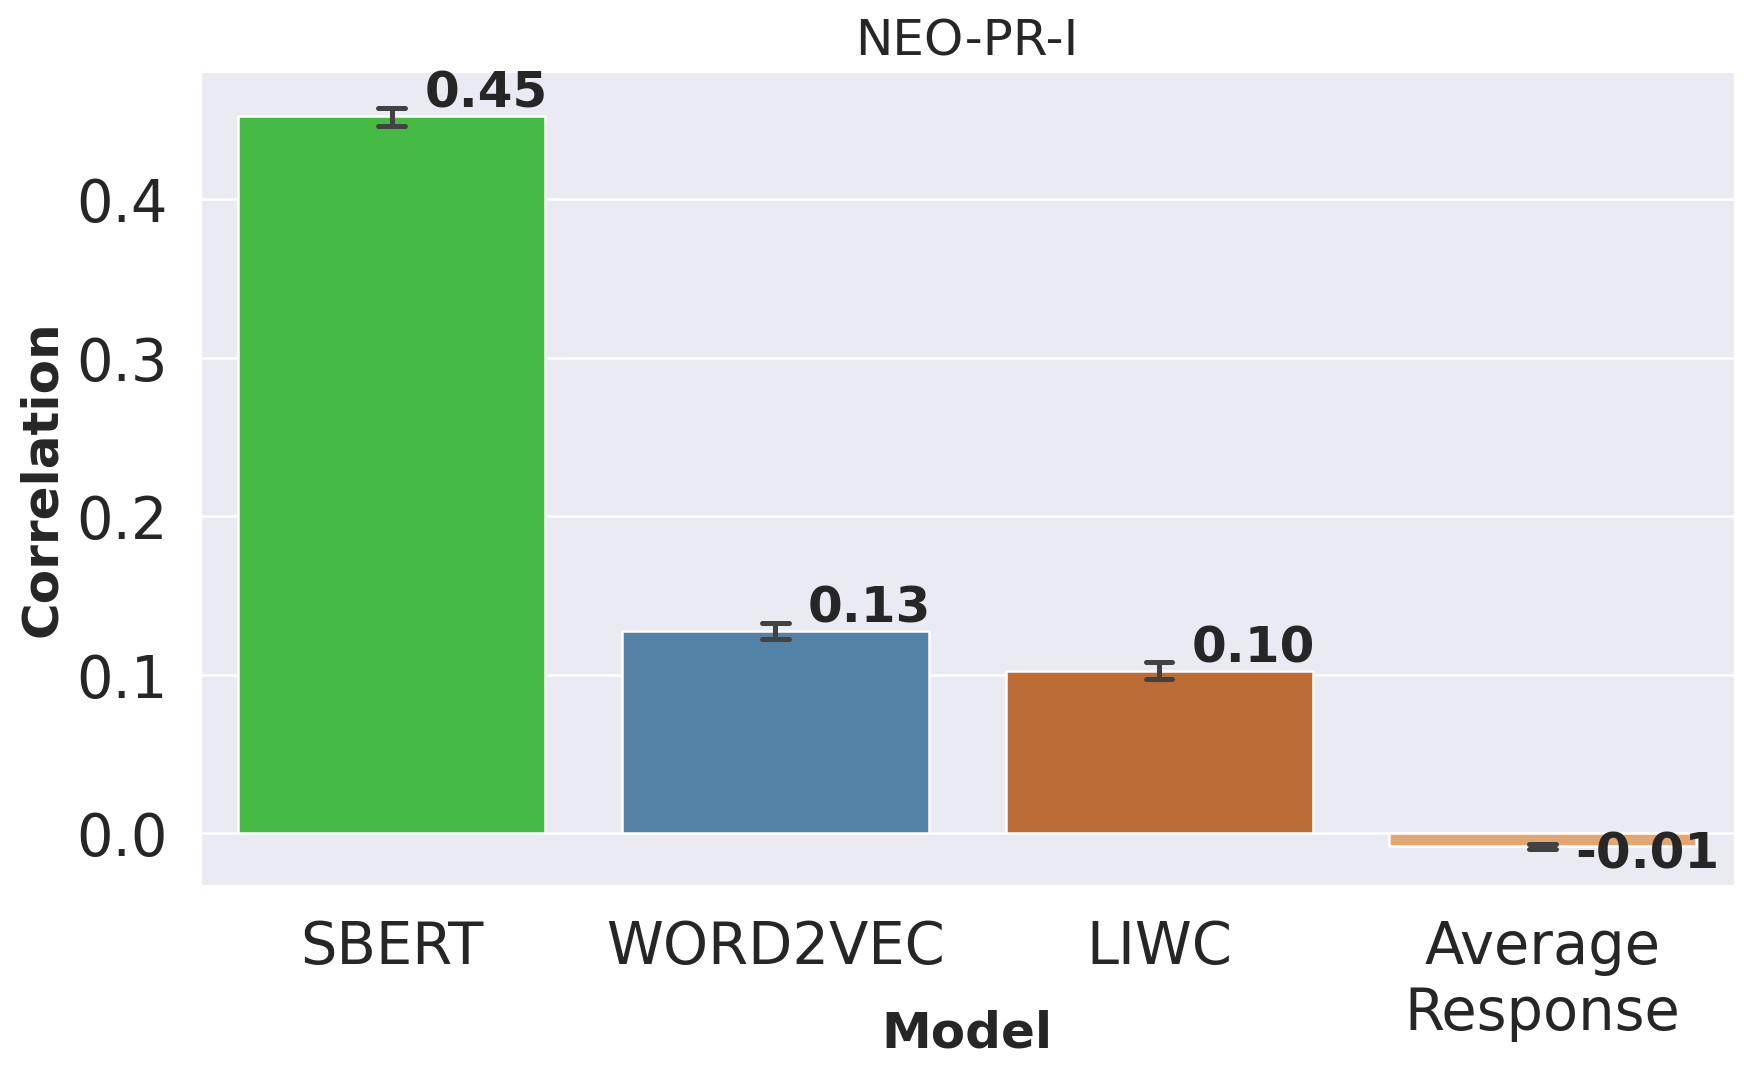

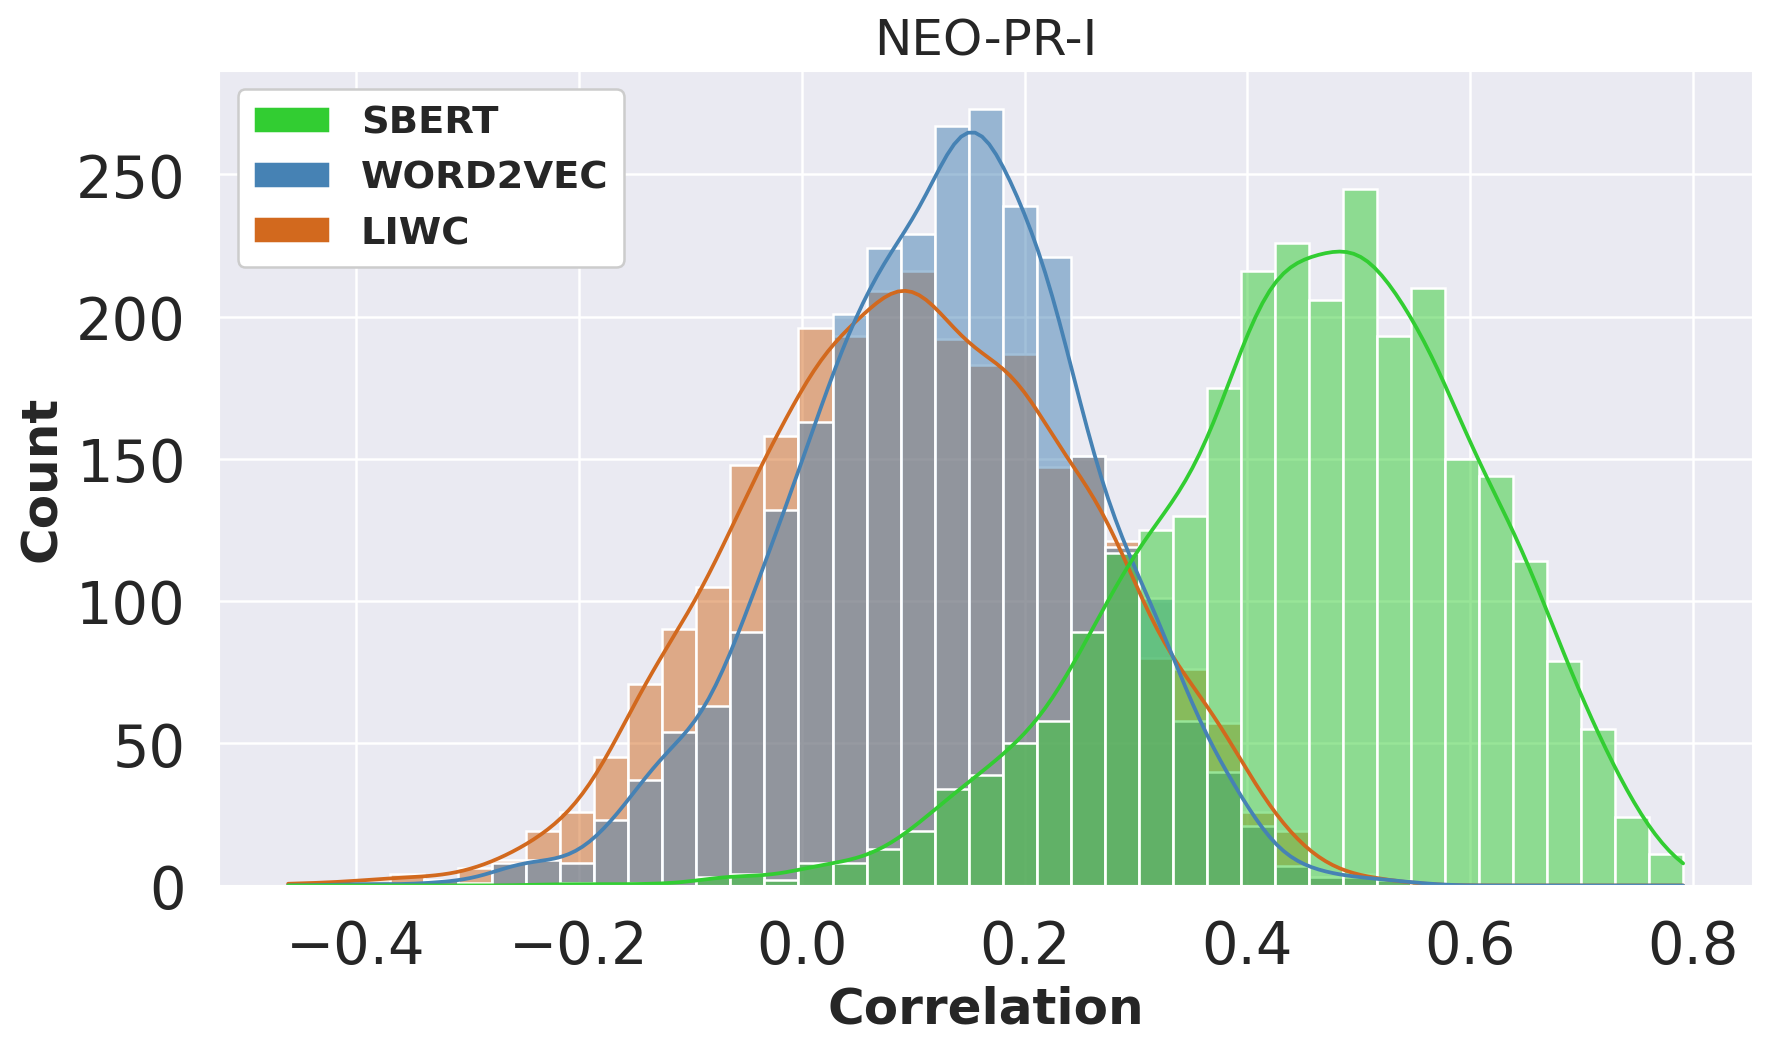

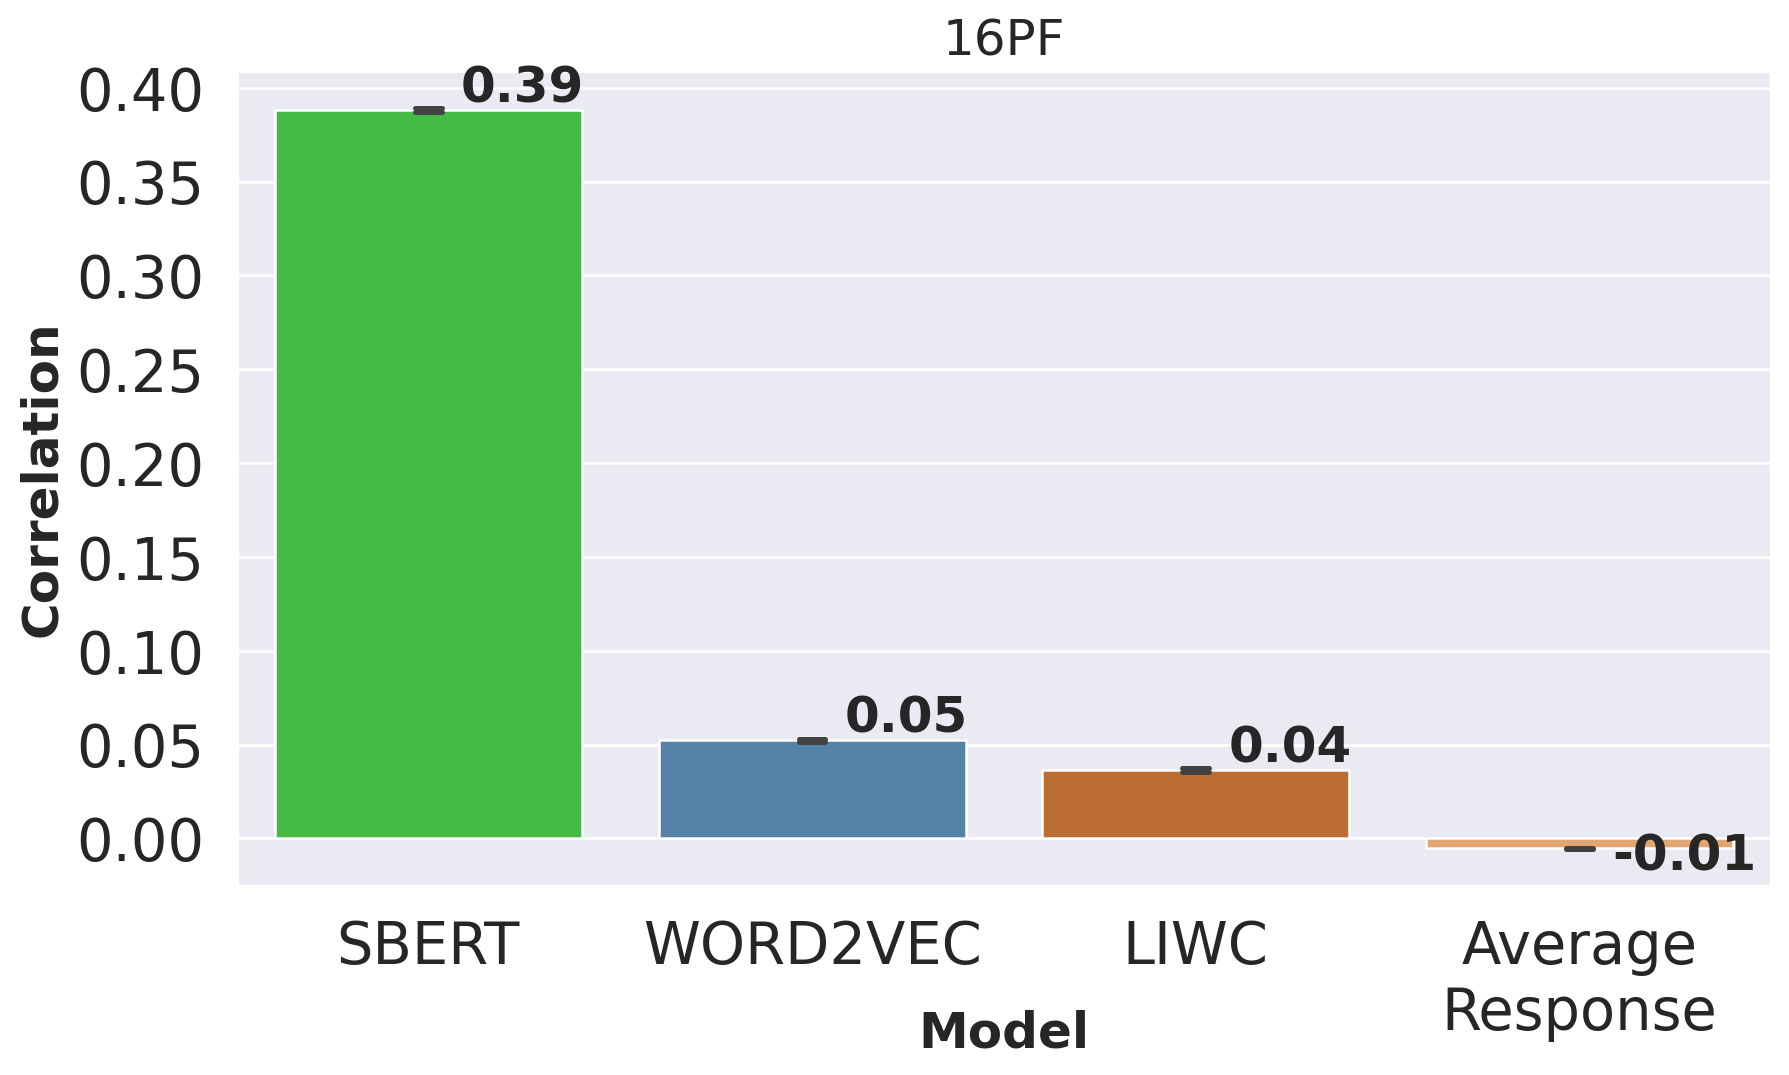

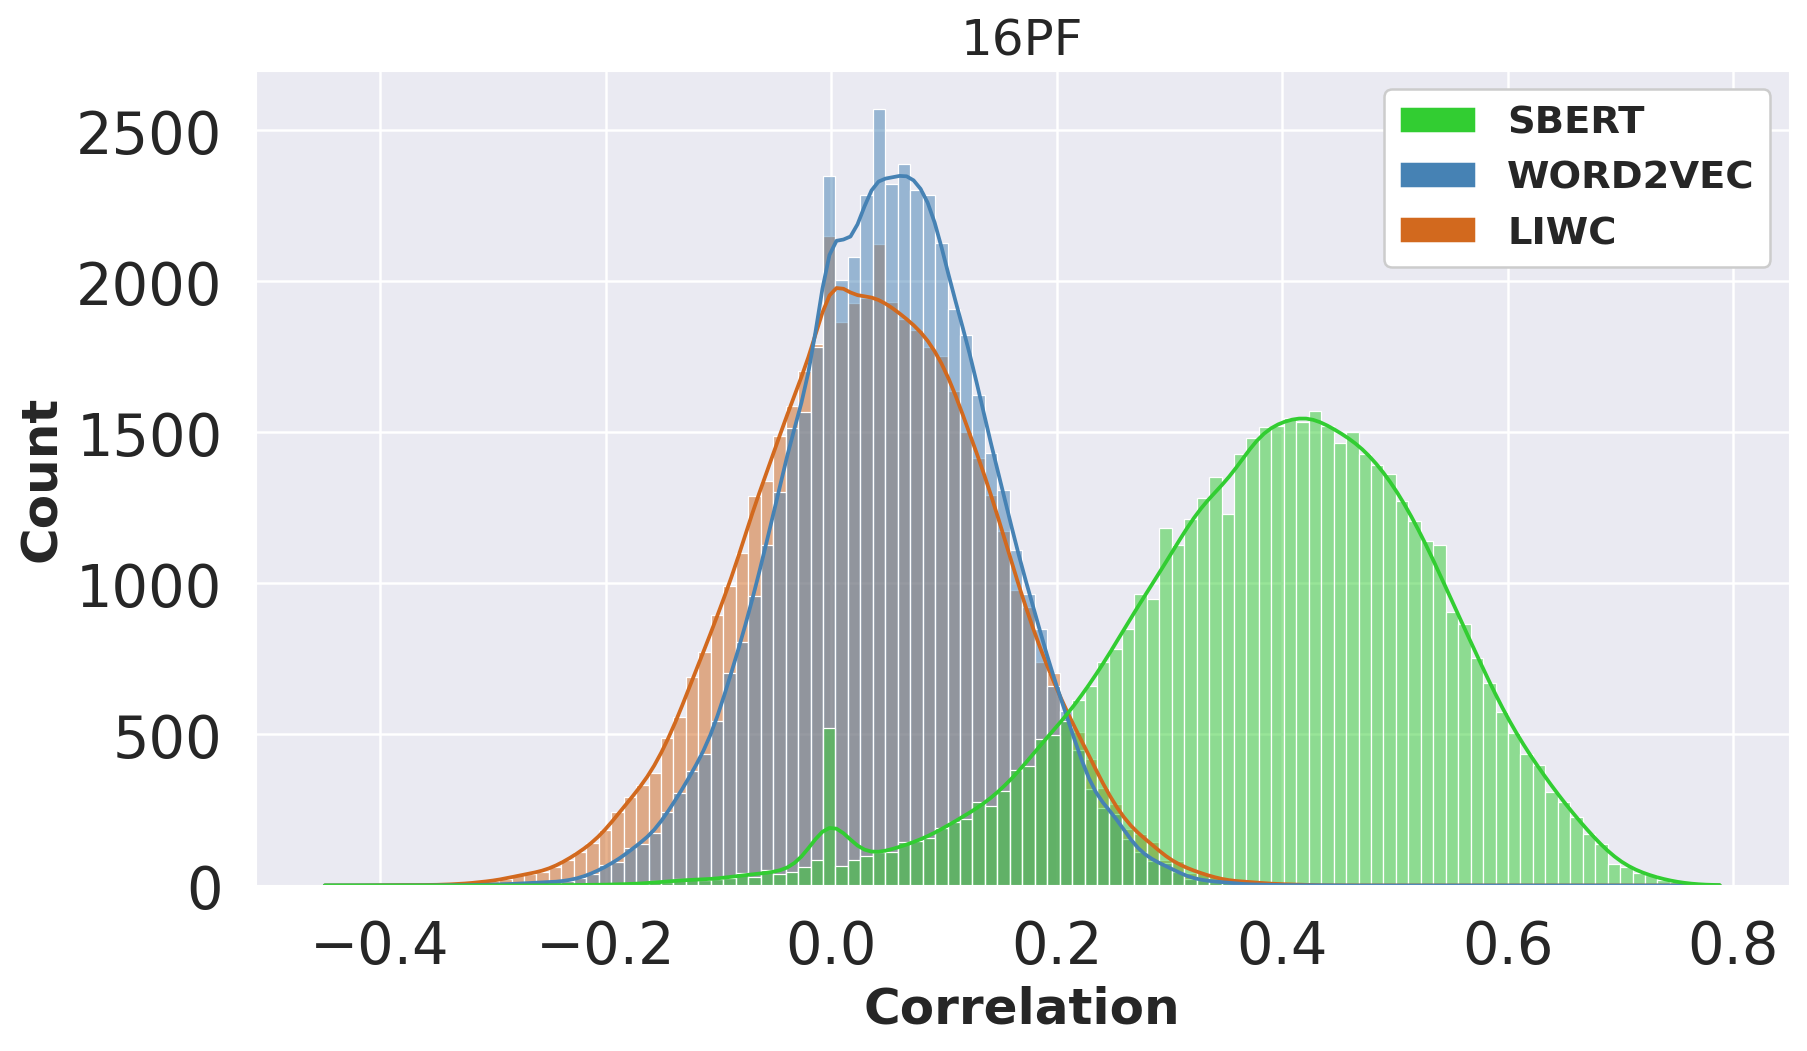

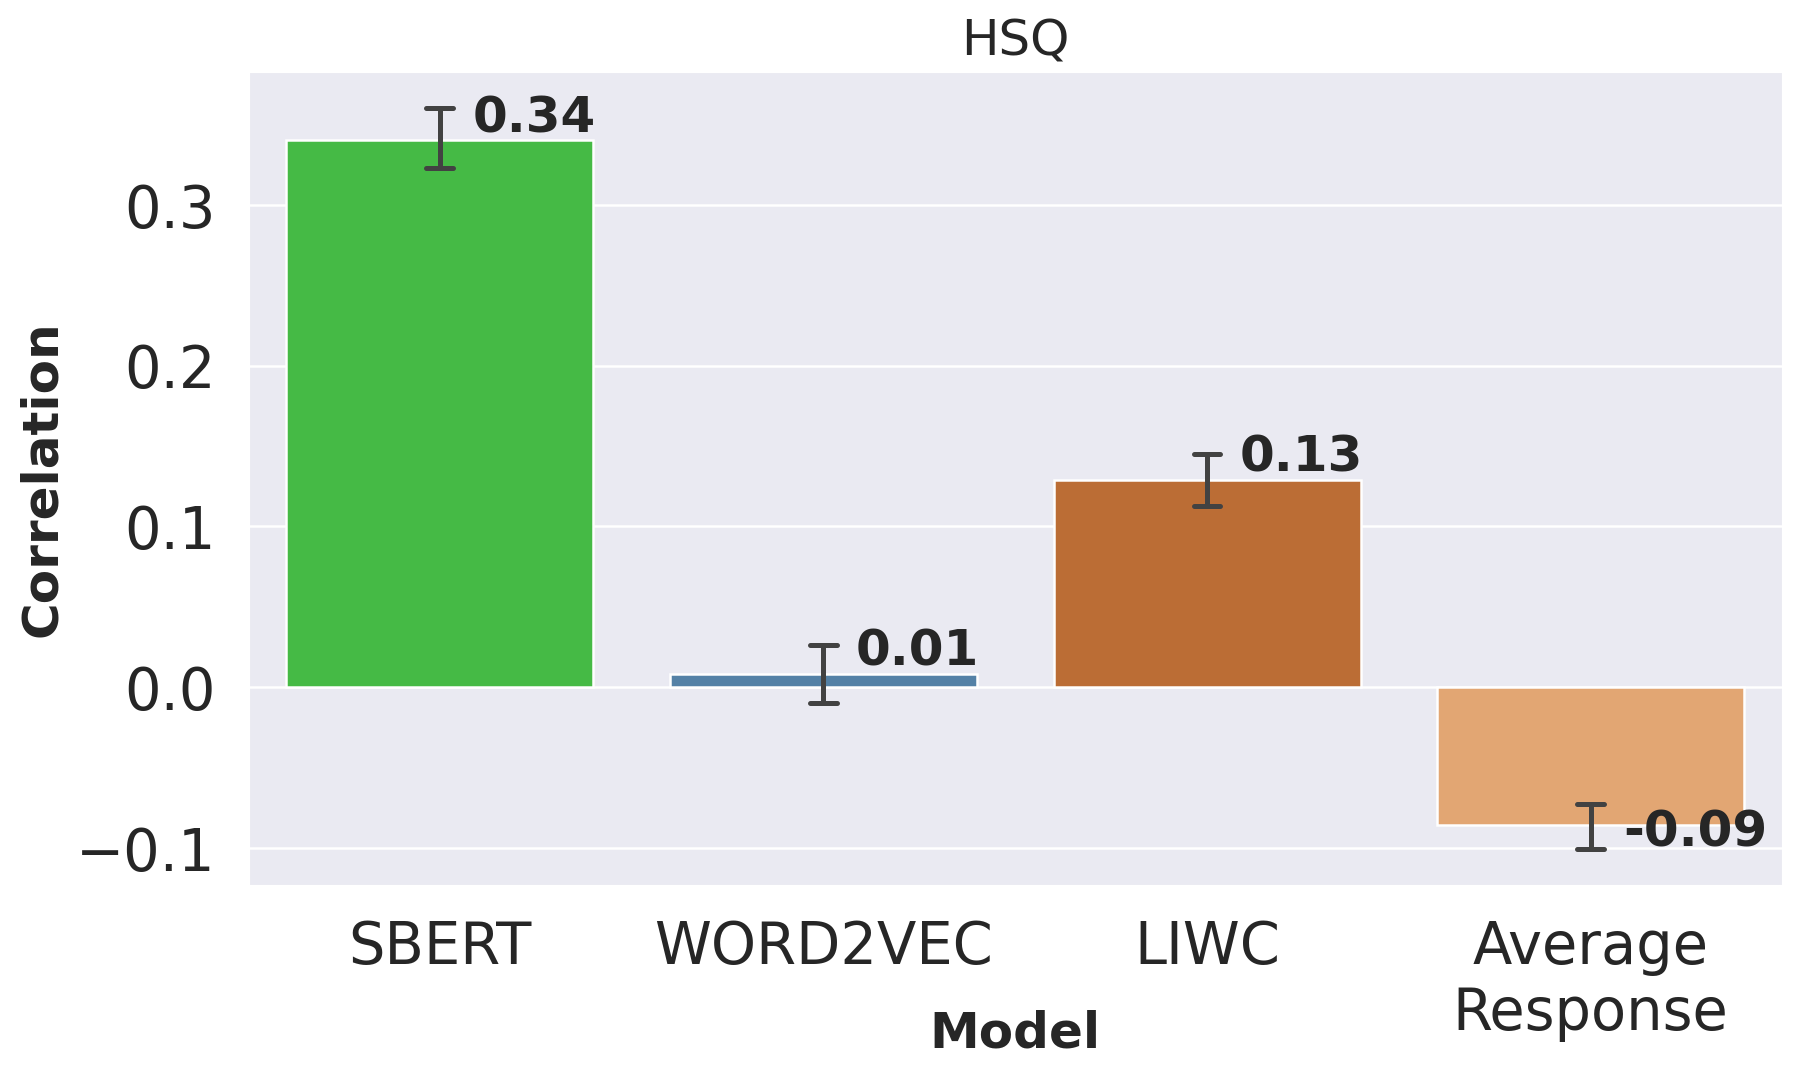

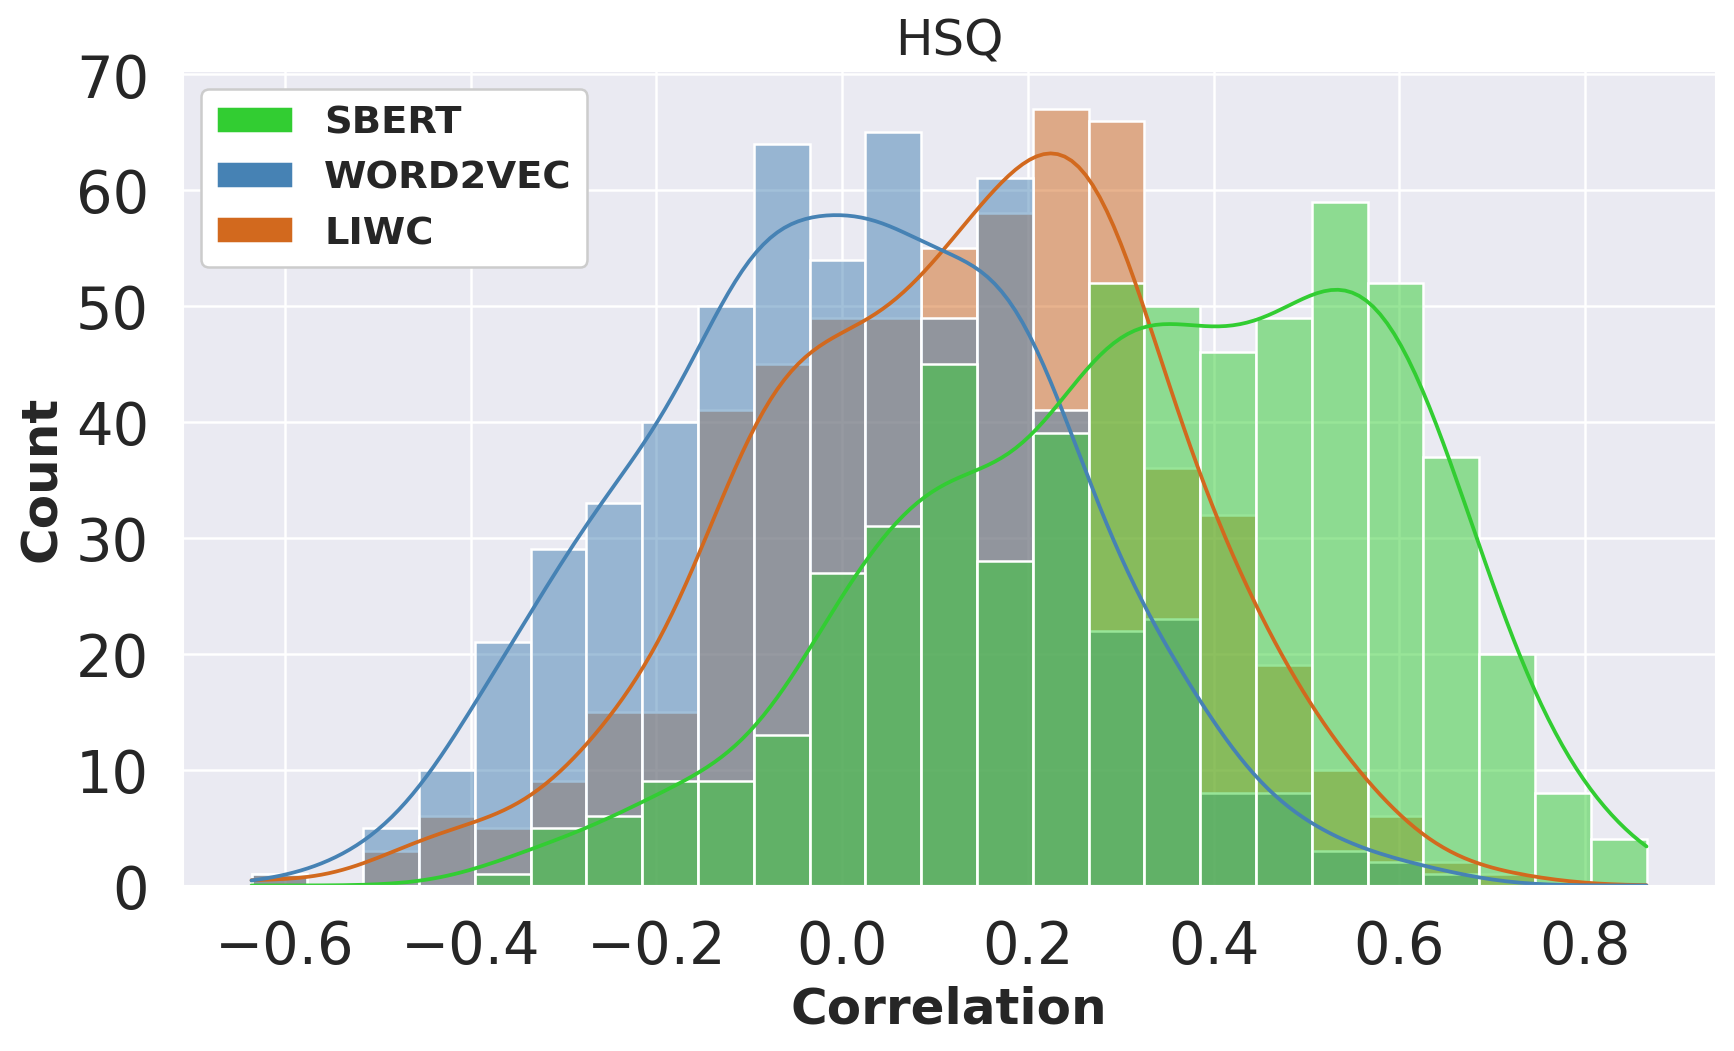

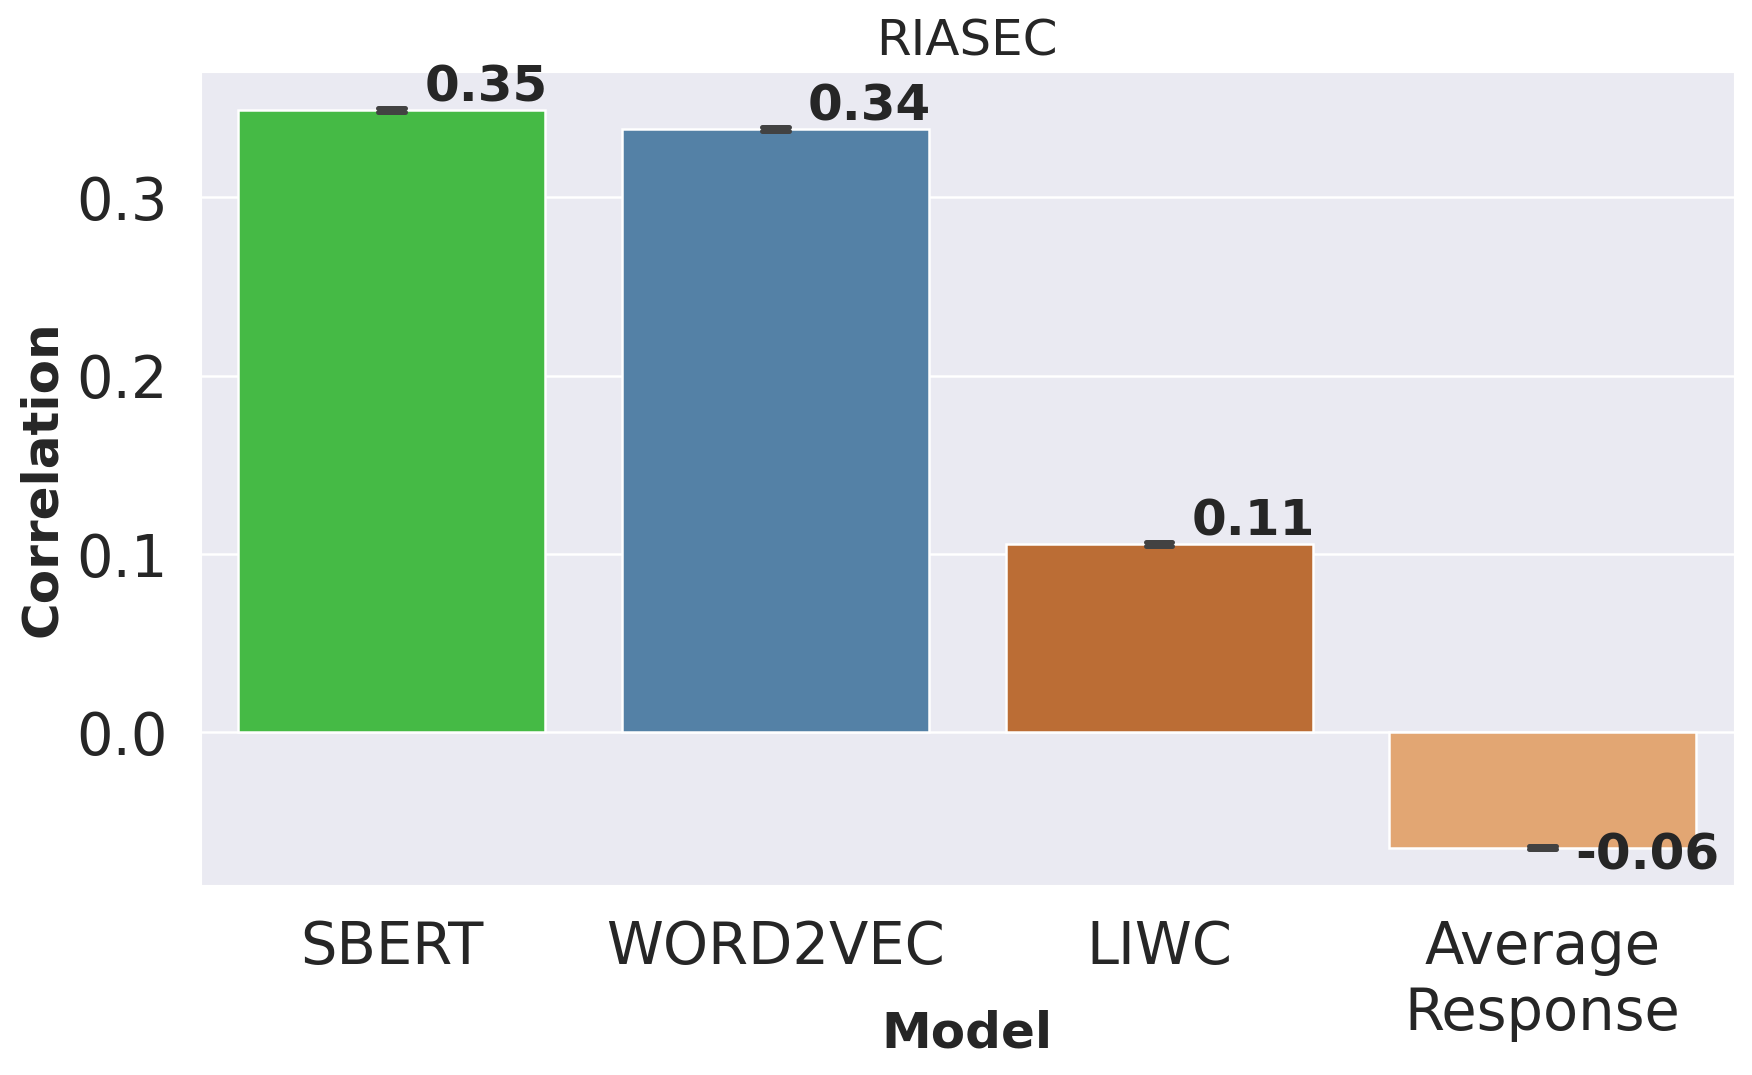

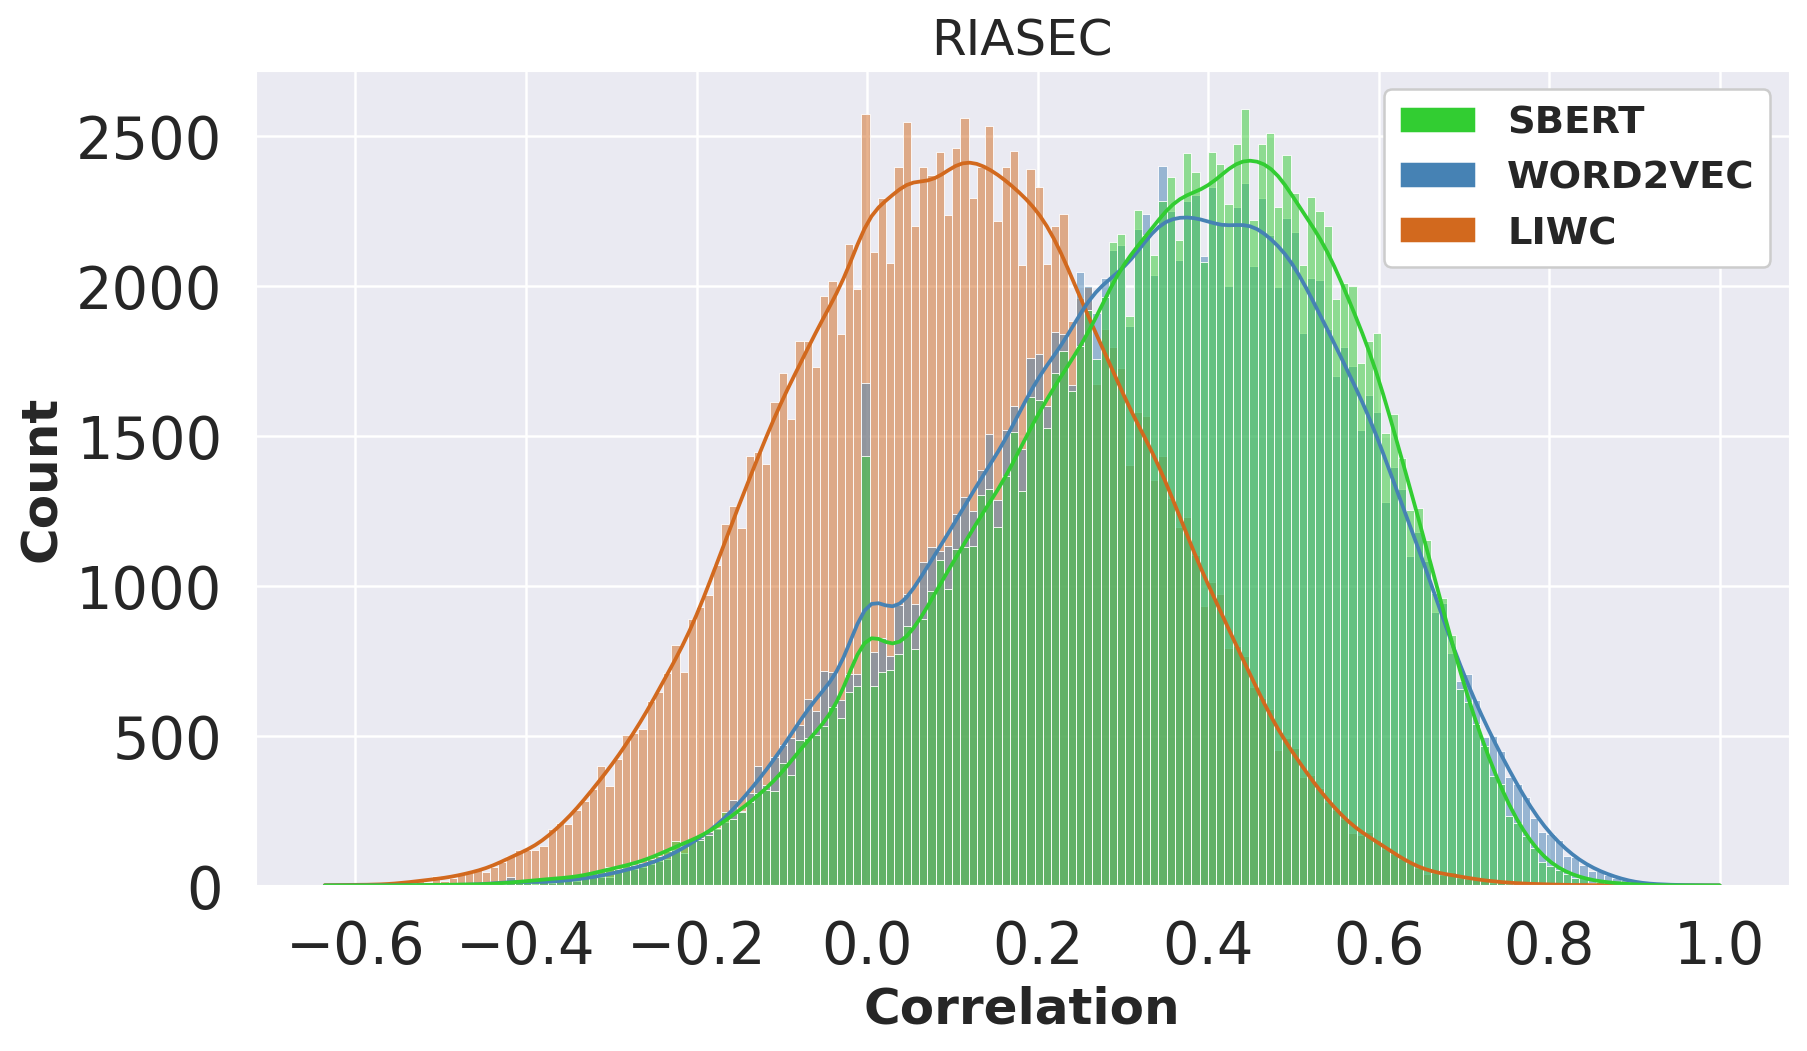

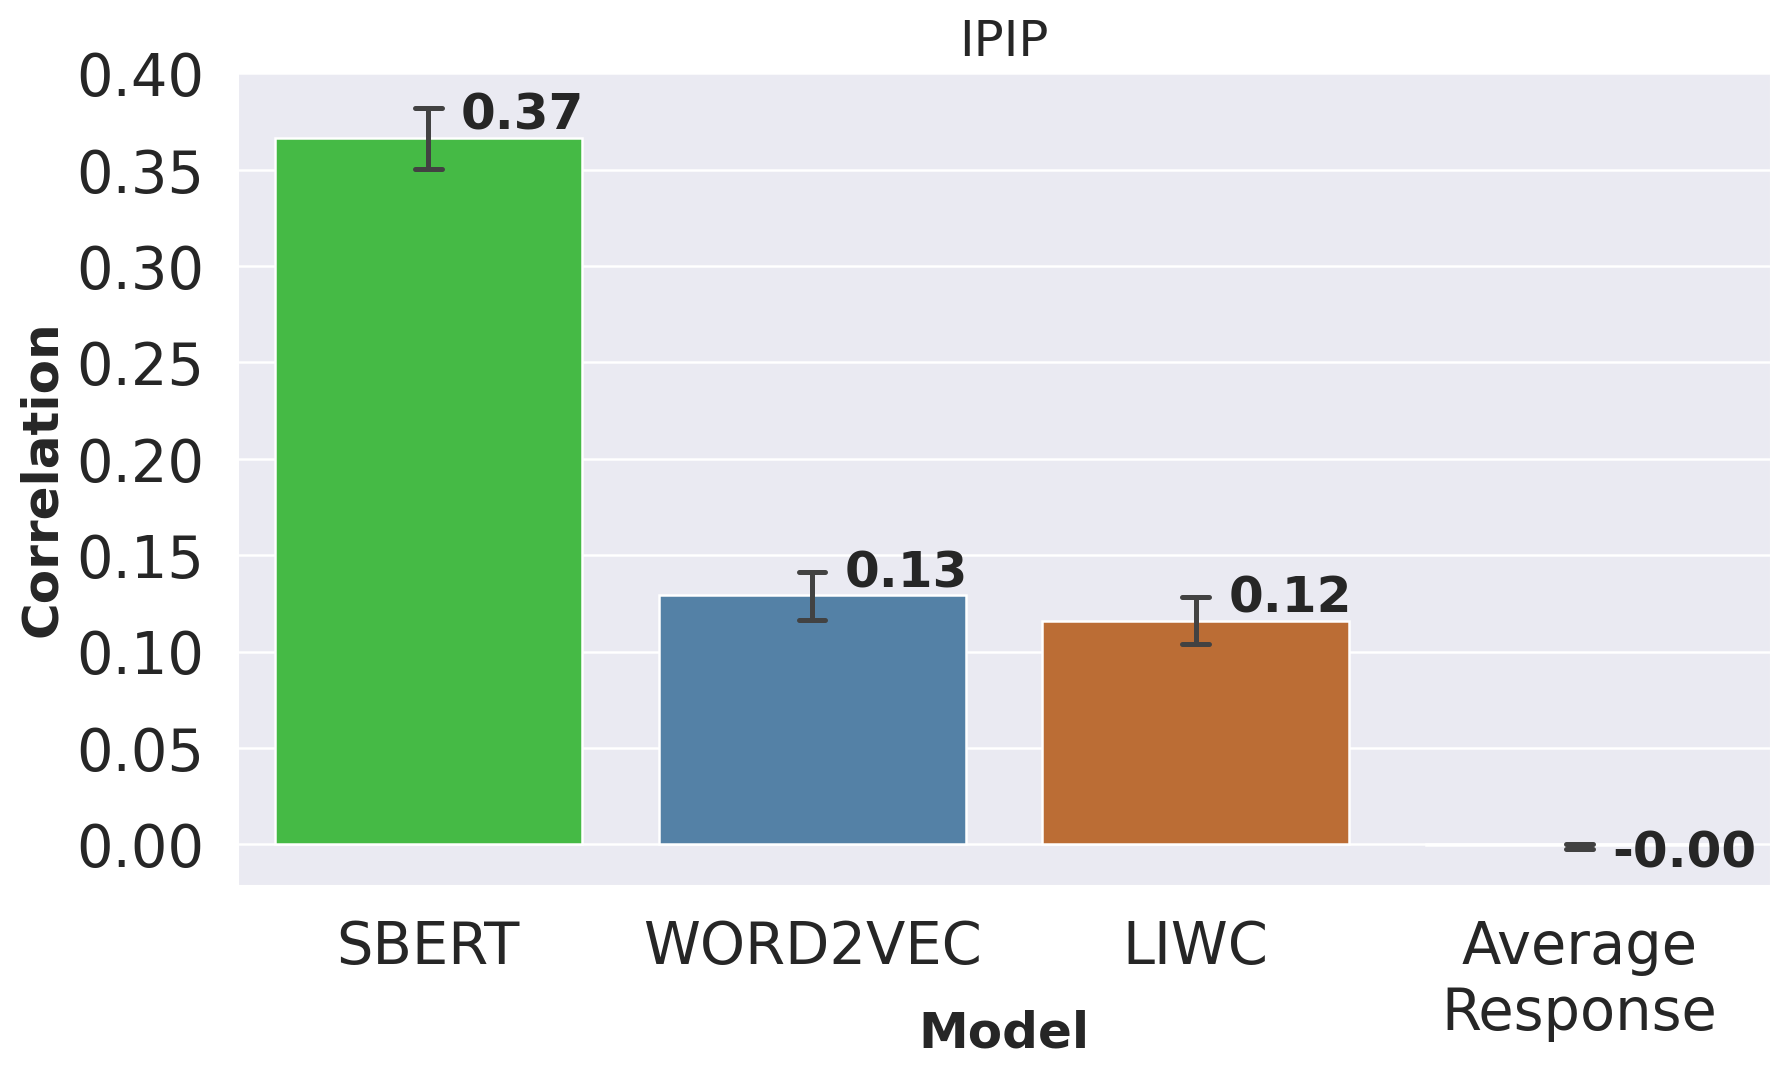

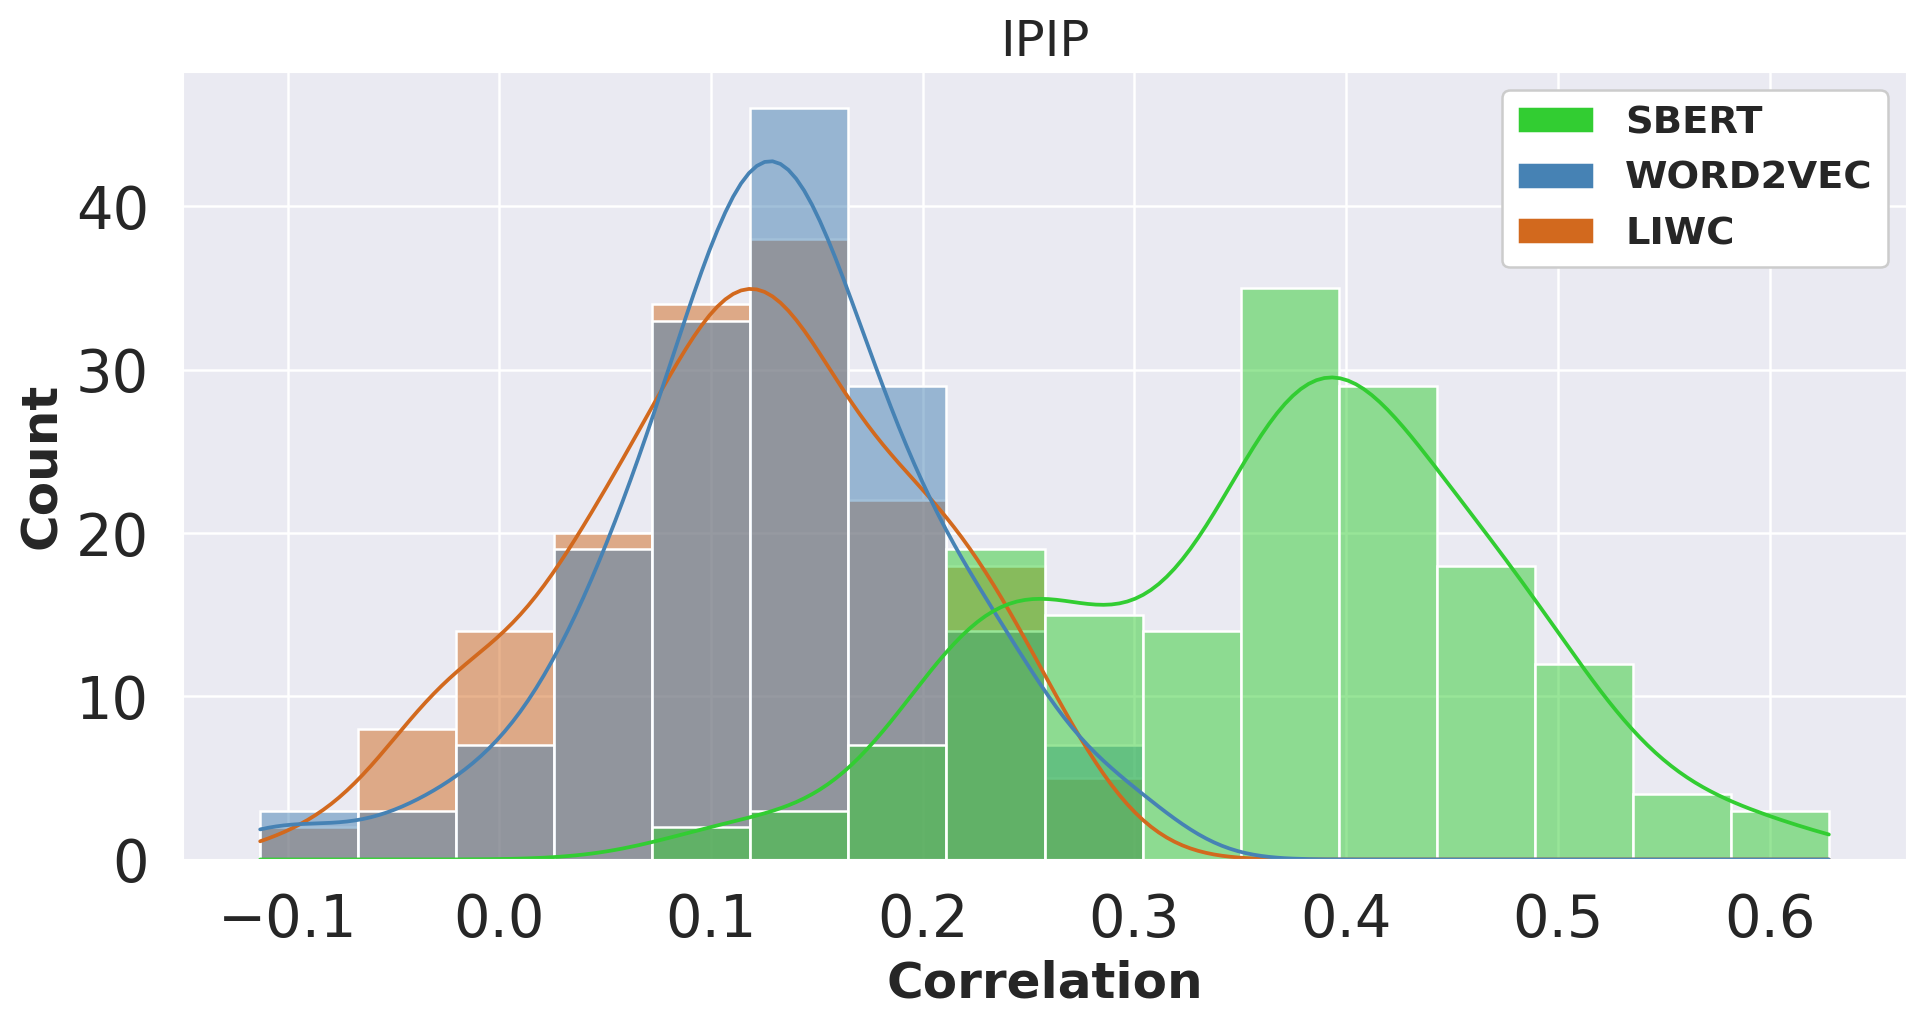

In [62]:
performance = pd.read_csv(path1 + "plot_data/performances2.csv", index_col=0)

cols = performance.columns.drop(['Dataset', 'Model'])
performance[cols] = performance[cols].astype(float)
performance = pd.melt(performance, id_vars=["Dataset", "Model"],var_name="predictor", value_name="metric value")
plot_data = performance[(performance['predictor'] == 'Correlation')].copy()
plot_data.loc[plot_data.Model == "Best Model", 'Model'] = "SBERT"

plot_data['Model'] = ["Average\nResponse" if item=="Average Response" else item for item in plot_data['Model']]

fig  = plt.figure(figsize=(20, 36), dpi= 180)
sns.set(font_scale = 1)
order = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP']
dataset_names = ['NEO-PR-I', '16PF', 'HSQ', 'RIASEC', 'IPIP']

#Plot style and meta
plt.style.use('seaborn')
sns.set_context('paper')
sns.set(font_scale = 1.4)
for i in range(5):


    #Add the performance plots:
    # fig.add_subplot(5, 2, 2*i+1)
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    ax = sns.barplot(y='metric value', x='Model', orient='v', data=plot_data[plot_data['Dataset']== order[i]], ci=95, palette=["limegreen","steelblue", "chocolate", "sandybrown"], capsize=0.07, errwidth=2)
    # plt.legend(loc="upper right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 2, p.get_height()),
              xytext=(13, height + 3), textcoords='offset points', ha="left", va="center", fontweight='bold',fontsize=20)
    plt.ylabel("Correlation", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20, labelpad=-13)
    plt.title(dataset_names[i], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)
    # start, end = ax.get_ylim()
    # print(start)
    # import math
    # print(math.floor(start,1))
    # plt.yticks(fontsize=23, ticks=np.arange(np.floor(start,1), np.ceil(end), 0.1))
    # plt.show()

    # fig_name = "fig2_" + chr(65+2*i) + ".svg"
    fig_name = "fig2_" + chr(65+2*i) + ".pdf"
    from google.colab import files
    plt.savefig(fig_name, bbox_inches='tight')
    files.download(fig_name)

    #Add the distribution plots for each data set:
    # fig.add_subplot(5, 2, 2*i+2)
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    data = plot_data[(plot_data.Dataset == order[i]) & (plot_data.Model != "Average\nResponse")]

    palette=["limegreen","steelblue", "chocolate"]
    ax = sns.histplot(data, x="metric value", kde=True, hue="Model", palette = palette)
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=item) for item in palette]
    labels = data.Model.unique().tolist()
    ax.legend(handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

    plt.ylabel("Count", fontweight='bold', fontsize=20)
    plt.xlabel("Correlation", fontweight='bold', fontsize=20)
    plt.title(dataset_names[i], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)
    # plt.show()

    fig_name = "fig2_" + chr(65+2*i+1) + ".pdf"
    from google.colab import files
    plt.savefig(fig_name, bbox_inches='tight')
    files.download(fig_name)

plt.tight_layout()
# plt.subplots_adjust(hspace = 1)
# plt.show()

# from google.colab import files
# plt.savefig("fig2_option2.svg")
# files.download("fig2_option2.svg")

In [ ]:
data.Model.unique()

array(['SBERT', 'WORD2VEC', 'LIWC'], dtype=object)

Display information from the saved data frame

In [ ]:
performance = pd.read_csv(path1 + "plot_data/performances2.csv", index_col=0)
performance[(performance.Dataset == "HSQ")  & (performance.Model == "WORD2VEC")].mean() #look up specific performances (baseline or model)

Get p-value of average correlation (t-test against zero)

In [ ]:
print('Best Model')
for i in np.unique(performance.Dataset):
  dist = performance[(performance.Dataset == i) & (performance.Model == 'Best Model') & (performance.predictor == 'Correlation')]
  t, p = stats.ttest_1samp(dist['metric value'], popmean=0)
  print(i)
  print([round(t,6), round(p,7)])

print('\nLIWC')
for i in np.unique(performance.Dataset):
  dist = performance[(performance.Dataset == i) & (performance.Model == 'LIWC') & (performance.predictor == 'Correlation')]
  t, p = stats.ttest_1samp(dist['metric value'], popmean=0)
  print(i)
  print([round(t,6), round(p,7)])

print('\nWORD2VEC')
for i in np.unique(performance.Dataset):
  dist = performance[(performance.Dataset == i) & (performance.Model == 'WORD2VEC') & (performance.predictor == 'Correlation')]
  t, p = stats.ttest_1samp(dist['metric value'], popmean=0)
  print(i)
  print([round(t,6), round(p,7)])

print('\nAverage Response')
for i in np.unique(performance.Dataset):
  dist = performance[(performance.Dataset == i) & (performance.Model == 'Average Response') & (performance.predictor == 'Correlation')]
  t, p = stats.ttest_1samp(dist['metric value'], popmean=0)
  print(i)
  print([round(t,6), round(p,7)])

Comparison to other prediction approaches

In [ ]:
""" Plot """
#get dataframes and best model after human experiments
comparison = pd.DataFrame(np.array([['Item Representations', 0.45],
                                      ['Facebook Likes', 0.43],
                                      ['Social Media Profile Pictures', 0.19], 
                                      ['Real Life Facial Pictures', 0.36]]), columns=["Method", "correlation"])
comparison.iloc[:, 1] = comparison.iloc[:, 1].astype(float)

plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10, 6), dpi = 150)
ax = sns.barplot(x="Method", y="correlation", data=comparison)

for p in ax.patches:
    ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(1, 0), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=10)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation', fontweight = "bold")
ax.set_xlabel('Prediction Method', fontweight = "bold")
ax.set_title('Maximum Prediction Performance over Prediction Methods', fontweight = "bold")

Construct wise performance

In [ ]:
# function for construct wise correlations:
def corrUserBased_constr(x,y):
  #dataframe for all results:
  total_results = pd.DataFrame([],columns=["Correlation","p-value","L1 Loss",'construct'])
  #get construct list:
  
  for i in constructs_list:
    #get responses within current construct
    constr_ids = np.where(constrAssigned.construct == i)[0]
    a = x.iloc[:,constr_ids]
    b = y.iloc[:,constr_ids]

    #calculate correlations and p value for every person, then average:
    current_results = pd.DataFrame(np.full(shape=(a.shape[0],4),fill_value=0),index = a.index,columns=["Correlation","p-value","L1 Loss",'construct'])
    
    #new function, much faster, #NOT FOR IPIP, #Can this be made shorter?
    corrVals = a.corrwith(b, 1, method=lambda x, y: np.round(pearsonr(x, y), 3)).fillna(0)
    current_results.iloc[:,:2] = corrVals.values.tolist()
    current_results.iloc[:,2] = np.absolute(a - b).sum(1)/a.shape[1]
    current_results = current_results.fillna(0)
    current_results["construct"] = i
    total_results = total_results.append(current_results)
  return total_results

Create dataframe with construct wise performances of each data set

In [ ]:
# best performing model:
m = 4           #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

datasets = ['BIG5', '16PF', 'HSQ']
performance = pd.DataFrame(columns=["Dataset", "Model", "Correlation", "p-value", "L1 Loss"])

#add LIWC/Word2vec
#iterate through datasets
for i,nr in zip(datasets, range(len(datasets))):
  #load prediction and baseline data
  folder, data = chooseData(i)
  responses, savePath, items = getResponses(path1, folder, data, 2)
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + e.upper() + "_responses.csv", index_col=0)
  total_dumb = pd.read_csv(savePath + 'baseline' + "_responses.csv", index_col=0)
  responses.index = total_preds.index
  #get construct lists
  constrAssigned = pd.read_csv(path1 + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
  constructs_list = constrAssigned.construct.drop_duplicates().values
  #get userbased correlations
  results = corrUserBased_constr(total_preds, responses)
  results_dumb = corrUserBased_constr(total_dumb, responses)
  results.insert(0,'Model',['Best Model']*results.shape[0])
  results.insert(0,'Dataset',[i]*results.shape[0])
  results_dumb.insert(0,'Model',['Baseline']*results_dumb.shape[0])
  results_dumb.insert(0,'Dataset',[i]*results_dumb.shape[0])
  #combine correlations of all datasets in one frame
  performance = performance.append(results)
  performance = performance.append(results_dumb)
performance = performance.reset_index(drop=True)

cols = performance.columns.drop(['Dataset', 'Model', "construct"])
performance[cols] = performance[cols].astype(float)
performance_melt = pd.melt(performance, id_vars=["Dataset", "Model", "construct"],var_name="predictor", value_name="metric value")
plot_data = performance_melt[(performance_melt['predictor'] == 'Correlation')]

plot_data.to_csv(path1 + "plot_data/constr_performances.csv") #save data frame for quick plotting

Create plots from data frame

In [ ]:
# load data frame
plot_data = pd.read_csv(path1 + "plot_data/constr_performances.csv", index_col=0)

#plot for each dataset
for i in datasets:
  plt.figure(figsize=(16, 6))
  current_plot = plot_data[plot_data.Dataset == i]
  ax = sns.barplot(y='metric value', x='construct', hue='Model', orient='v', data=current_plot, ci=95, palette=["steelblue", "lightsteelblue", "darkorange", "gold"])

  for p in ax.patches:
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
              xytext=(5, 0), textcoords='offset points', ha="left", va="bottom")

  #Plot style and meta
  plt.style.use('seaborn')
  # sns.set_context('paper')
  plt.ylabel("Correlation")
  plt.title('Out of sample prediction performance: ' + i + " data set")
  plt.show()

### Bar plot human vs computer performance

#### Functions

In [ ]:
""" Functions """
from numpy import nanmean
def pearsonr_ci(r, p, n, alpha=0.05):
    r_z = np.arctanh(r)
    se = 1/np.sqrt(n-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    a = a[~np.isnan(a)] #remove nan
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def regCorr(target_list, n_steps, model_data): #also calculate model data in the same way
    responses = pd.read_csv(path1 + "BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #read actual participant responses

    corrs_list = []
    pvals_list = []
    comp_corrs_list = []
    comp_pvals_list = []
    for i, (df, df_name) in enumerate(target_list):
        y = responses.loc[:,df.columns[1]].values
        y = y[df.index]
        corrs = []
        pvals = []
        for col in df.iloc[:,2:]:
            full_col = df.loc[:,col]
            for nr_p in range(int(df.shape[0]/n_steps)):
                human_preds = full_col[nr_p*n_steps:(nr_p+1)*n_steps] #there are 10 predictions per person
                y_curr = y[nr_p*10:nr_p*10+10]
                y_curr = y_curr[~np.isnan(human_preds)] #remove nan
                x_curr = human_preds[~np.isnan(human_preds)]
                
                try: #4 participants with not enough ratings!
                    cor, p = pearsonr(y_curr, x_curr)
                except:
                    cor = np.nan
                    p = np.nan
                corrs.append(cor)
                pvals.append(p)
              
        corrs_list.append(corrs)
        pvals_list.append(pvals)            
        
        #computational model's performance
        predictions = model_data.loc[model_data.index[i], model_data.columns[df.index]].values.reshape((10,10))
        actual_values = y.reshape((10,10)) #also check order -> import fold item order!
        comp_corrs = []
        comp_pvals = []
        for i in range(predictions.shape[0]):
            x_curr = predictions[i]
            y_curr = actual_values[i]
            
            try: #4 participants with not enough ratings!
                cor, p = pearsonr(y_curr, x_curr)
            except:
                cor = np.nan
                p = np.nan
            comp_corrs.append(cor)
            comp_pvals.append(p)
            
        comp_corrs_list.append(comp_corrs)
        comp_pvals_list.append(comp_pvals)

    return corrs_list, pvals_list, comp_corrs_list, comp_pvals_list

def crowdWisdom(target_list, model_data):
    responses = pd.read_csv(path1 + "BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #read actual participant responses

    corr_list = []
    pval_list = []
    for df, df_name in target_list:
        y = responses.loc[:,df.columns[1]].values
        y = y[df.index]
        human_ratings = nanmean(df.iloc[:,2:].values, 1) #get the average of all raters for each question -> "crowd wisdom"

        corr, pval = pearsonr(human_ratings, y)
        corr_list.append(corr.round(3))
        pval_list.append(pval.round(3))

    return corr_list, pval_list

""" Data Imports """
import scipy.stats
#change to read from drive
xslx = pd.ExcelFile(path1 + "human_eval_unreversed.xlsx")
target_25 = pd.read_excel(xslx, "25%", index_col=0)
target_50 = pd.read_excel(xslx, "50%", index_col=0)
target_75 = pd.read_excel(xslx, "75%", index_col=0)
target_list = [(target_25, "25%"), (target_50, "50%"), (target_75, "75%")]

model_performance = pd.read_csv(path1 + "best_model_results_userBased.csv", index_col=0)
# predictions = pd.read_csv("/content/drive/My Drive/dataset/Suhaib/BIG5/new_results/by_embeddings/nonReversed/" + "KnnReg_5_SENTENCEBERT_responses.csv", index_col=0)
predictions = pd.read_csv("/content/drive/My Drive/spring_2021/questionaire_project/google_collab/dataset/Suhaib/BIG5/new_results/by_embeddings/nonReversed/" + "KnnReg_5_SENTENCEBERT_responses.csv", index_col=0)    # path for Huy's drive to check code
predictions_targets = predictions.loc[[df[0].columns[1] for df in target_list],:]

def regCorr2(target_list, model_data): #also calculate model data in the same way
    responses = pd.read_csv(path1 + "BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #read actual participant responses

    #arrays with final data
    corrs_list = []
    pvals_list = []
    comp_corrs_list = []
    comp_pvals_list = []
    
    for i, (df, df_name) in enumerate(target_list): #loop over target participants
        y = responses.loc[:,df.columns[1]].values #actual responses
        y = y[df.index] #reorder according to human response data
        corrs = []
        pvals = []
        for col in df.iloc[:,2:]:
            human_preds = df.loc[:,col] #10 human raters concatenated
            try: #4 participants with not enough ratings!
                cor, p = pearsonr(human_preds, y)
            except:
                cor = np.nan
                p = np.nan
            corrs.append(cor)
            pvals.append(p)
            
        corrs_list.append(corrs)
        pvals_list.append(pvals)            

        #computational model's performance
        predictions = model_data.loc[model_data.index[i], model_data.columns[df.index]].values

        comp_corr, comp_p = pearsonr(predictions, y)
        comp_pvals_list.append(comp_p)
        comp_corrs_list.append(comp_corr)

        # print("Model performance: ")
        # print("Mean: " + str(comp_mean_corr.round(3)) + ", p-value: " + str(comp_mean_p.round(3)))
    return corrs_list, pvals_list, comp_corrs_list, comp_pvals_list

def compPercentile(target_list, n_steps, model_data): #also calculate model data in the same way
  responses = pd.read_csv(path1 + "BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #read actual participant responses

  t_percentiles = []
  corr_human = []
  corr_comp = []
  for i, (df, df_name) in enumerate(target_list):
      predictions = model_data.loc[model_data.index[i], model_data.columns[df.index]].values.reshape((10,10))
      y = responses.loc[:,df.columns[1]].values
      y = y[df.index]
      fold_corrs_c = []
      percentiles = []
      total_folds_h = []
      for nr_p in range(int(df.shape[0]/n_steps)):
        fold_corrs_h = []
        fold_pvals_h = []
        x_curr_c = predictions[nr_p]
        y_curr = y[nr_p*10:nr_p*10+10]
        try: #4 participants with not enough ratings!
          cor_c, p_c = pearsonr(y_curr, x_curr_c)
        except:
            cor_c = np.nan
            p_c = np.nan
        fold_corrs_c.append(cor_c)

        # print("Model: " + str(cor_c))
        
        for col in df.iloc[:,2:]:
            full_col = df.loc[:,col]
            human_preds = full_col[nr_p*n_steps:(nr_p+1)*n_steps] #there are 10 predictions per person
            y_curr = y[nr_p*10:nr_p*10+10]
            y_curr = y_curr[~np.isnan(human_preds)] #remove nan
            x_curr_h = human_preds[~np.isnan(human_preds)]
            
            try: #4 participants with not enough ratings!
                cor_h, p_h = pearsonr(y_curr, x_curr_h)
            except:
                cor_h = np.nan
                p_h = np.nan

            fold_corrs_h.append(cor_h)
        # print("Humans: " + str(nanmean(fold_corrs_h)))
        total_folds_h.extend(fold_corrs_h)
        #get current percentile:
        percentiles.append(round(stats.percentileofscore(fold_corrs_h, cor_c),3))    
      t_percentiles.append(percentiles)  
      corr_comp.append(fold_corrs_c)
      corr_human.append(total_folds_h) 
  return t_percentiles, corr_comp, corr_human

#### Plots

##### Plot 1: <br>
Computational model's performance as correlation of test fold predictions and test fold observations. <br>
Report mean fold performance and 95% CI. <br>
Human performance as analgeously.

In [ ]:
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations
corrs_means = [np.nanmean(x).round(3) for x in cor_h] #humans
pvals_means = [np.nanmean(x).round(3) for x in p_h]
corrs_comps = [np.nanmean(x).round(3) for x in cor_comp] #computational model
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

# CI
ci_corr_model = [mean_confidence_interval(x) for x in cor_comp] #comp model
yerr_model = [(x[2]-x[1])/2 for x in ci_corr_model]
ci_corr_human = [mean_confidence_interval(x) for x in cor_h] #humans
yerr_human = [(x[2]-x[1])/2 for x in ci_corr_human]

#plot dataframe
performance = pd.DataFrame(np.array([["25th percentile", 'Computational Model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'Computational Model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'Computational Model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'Human Raters', corrs_means[0], yerr_human[0]],
                                          ["50th percentile",'Human Raters',  corrs_means[1], yerr_human[1]],
                                          ["75th percentile", 'Human Raters',  corrs_means[2], yerr_human[2]]]), columns=["target", "model", "correlation", "yerr"])
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist() #bar labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Get p-values of average correlations

In [ ]:
for i in range(3):
  print('Target ' + str(i) + ": ")
  dropna_comp = [x for x in cor_comp[i] if str(x) != 'nan']
  dropna_h = [x for x in cor_h[i] if str(x) != 'nan']
  print('Human judges: ' + str(stats.ttest_1samp(dropna_h,0)))
  print('Best Model: ' + str(stats.ttest_1samp(dropna_comp,0)))
  print('\n')

Target 0: 
Human judges: Ttest_1sampResult(statistic=17.800193713748794, pvalue=7.008119407112596e-43)
Best Model: Ttest_1sampResult(statistic=4.071970551225439, pvalue=0.0027913890947931963)


Target 1: 
Human judges: Ttest_1sampResult(statistic=31.537491955551964, pvalue=5.6963106163828155e-80)
Best Model: Ttest_1sampResult(statistic=4.856291553782079, pvalue=0.0009004474742004147)


Target 2: 
Human judges: Ttest_1sampResult(statistic=17.513968359926476, pvalue=5.897518785914799e-42)
Best Model: Ttest_1sampResult(statistic=9.745964664738912, pvalue=4.4310395252383395e-06)




/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


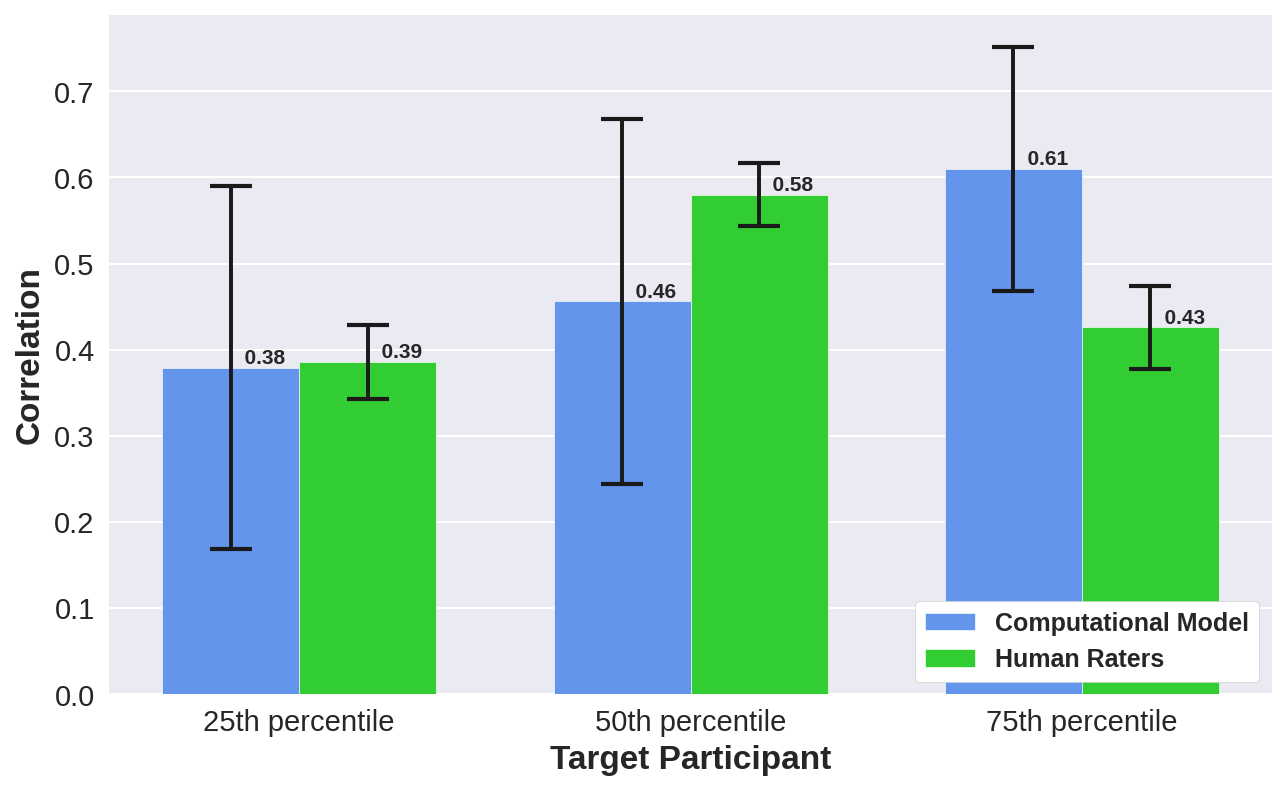

In [ ]:
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations
corrs_means = [np.nanmean(x).round(3) for x in cor_h] #humans
pvals_means = [np.nanmean(x).round(3) for x in p_h]
corrs_comps = [np.nanmean(x).round(3) for x in cor_comp] #computational model
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

# CI
ci_corr_model = [mean_confidence_interval(x) for x in cor_comp] #comp model
yerr_model = [(x[2]-x[1])/2 for x in ci_corr_model]
ci_corr_human = [mean_confidence_interval(x) for x in cor_h] #humans
yerr_human = [(x[2]-x[1])/2 for x in ci_corr_human]

#plot dataframe
performance = pd.DataFrame(np.array([["25th percentile", 'Computational Model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'Computational Model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'Computational Model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'Human Raters', corrs_means[0], yerr_human[0]],
                                          ["50th percentile",'Human Raters',  corrs_means[1], yerr_human[1]],
                                          ["75th percentile", 'Human Raters',  corrs_means[2], yerr_human[2]]]), columns=["target", "model", "correlation", "yerr"])
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist() #bar labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
comp = performance[performance.model == 'Computational Model'] #comp model bars
hum = performance[performance.model == 'Human Raters'] #human bars
rects1 = ax.bar(x - width/2, comp.correlation.values, width, label='Computational Model', yerr = comp.yerr.values, capsize=0.2, color = 'cornflowerblue') #bar plots
plt.errorbar(x - width/2, comp.correlation.values,  yerr=comp.yerr.values, fmt=' ', markersize=8, capsize=10, capthick=2, ecolor='k')
rects2 = ax.bar(x + width/2, hum.correlation.values, width, label='Human Raters', yerr = hum.yerr.values, capsize=0.2, color = 'limegreen')
plt.errorbar(x + width/2, hum.correlation.values,  yerr=hum.yerr.values, fmt=' ', markersize=8, capsize=10, capthick=2, ecolor='k')
ax.grid(False, axis='x')

for p in ax.patches:
    ax.annotate("  %.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(34, 0), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=10)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation', fontweight = "bold", fontsize = 16)
ax.set_xlabel('Target Participant', fontweight = "bold", fontsize = 16)
# ax.set_title('Comparison of computational model\'s vs human raters\' prediction performance', fontweight = "bold")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 14)
plt.yticks(fontsize = 14)
ax.legend(loc="lower right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold', 'size':12})

from google.colab import files
plt.savefig("fig3a.svg")
# files.download("fig3a.svg") 

##### Plot 2: (crowd approach) <br>
Human predictions as average across all human raters on each questionnaire item. <br>
Computational performance as in Plot 1.

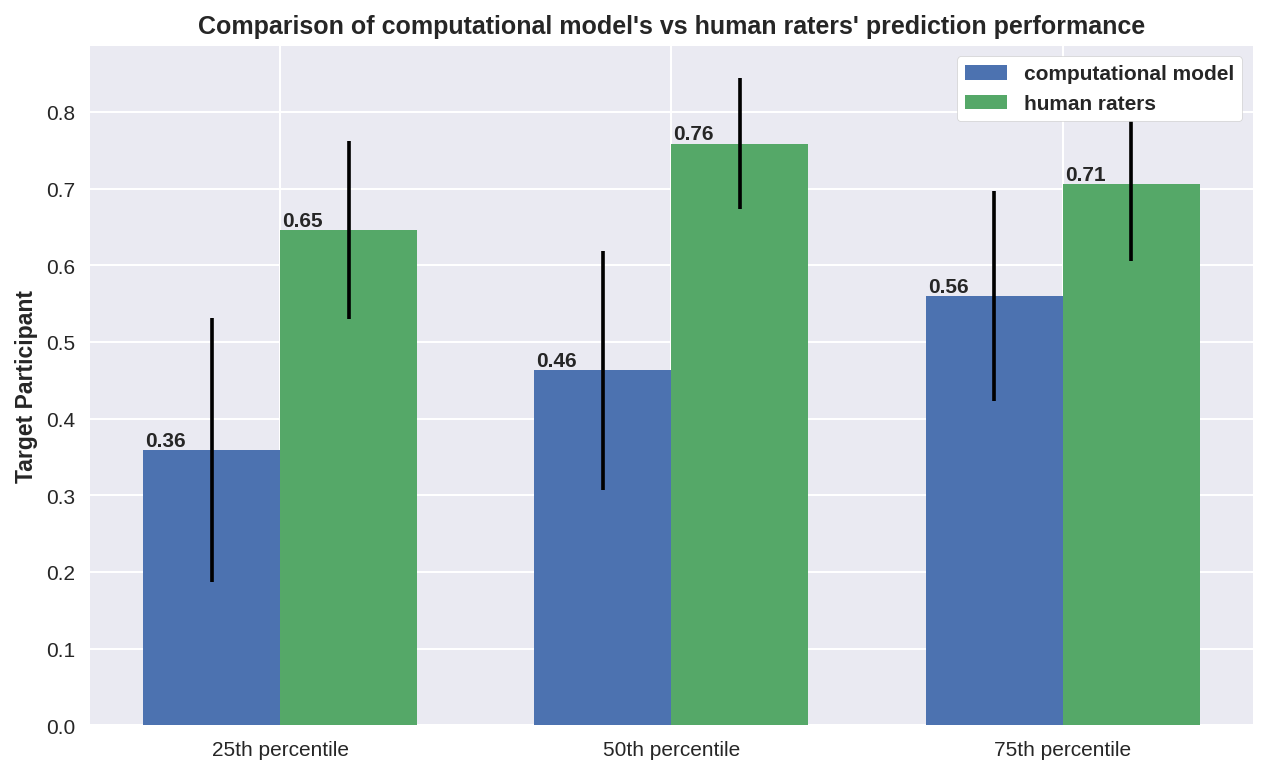

In [ ]:
""" Run Functions """
n_steps = 10  #how many items where rated by a single human rater
corrs_w, pvals_w = crowdWisdom(target_list, predictions_targets) #human crowd performance
#computational model
corrs_comps = [model_performance.loc[df[0].columns[1], "Correlation"].round(3) for df in target_list]
pvals_comps = [model_performance.loc[df[0].columns[1], "p-value"].round(3) for df in target_list]

#CI
ci_corr_model = [pearsonr_ci(corrs_comps[i], pvals_comps[i], n=100) for i in range(len(corrs_comps))] #comp model
yerr_model = [(x[3]-x[2])/2 for x in ci_corr_model] #error range
ci_corr_w = [pearsonr_ci(x, y, n=100) for x,y in zip(corrs_w, pvals_w)] #humans
yerr_w = [(x[3]-x[2])/2 for x in ci_corr_w]

""" Plot """

#get dataframes and best model after human experiments
performance_w = pd.DataFrame(np.array([["25th percentile", 'computational model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'computational model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'computational model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'human raters', corrs_w[0], yerr_w[0]],
                                          ["50th percentile",'human raters',  corrs_w[1], yerr_w[1]],
                                          ["75th percentile", 'human raters',  corrs_w[2], yerr_w[2]]]), columns=["target", "model", "correlation", "yerr"])
performance_w.iloc[:, -2:] = performance_w.iloc[:, -2:].astype(float)
labels_w = performance_w.target.drop_duplicates().tolist()
x = np.arange(len(labels_w))  # the label locations
width = 0.35  # the width of the bars

plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10, 6), dpi = 150)
comp = performance_w[performance_w.model == "computational model"]
hum_w = performance_w[performance_w.model == "human raters"]
rects1 = ax.bar(x - width/2, comp.correlation.values, width, label='computational model', yerr = comp.yerr.values, capsize=0.02)
rects2 = ax.bar(x + width/2, hum_w.correlation.values, width, label='human raters', yerr = hum_w.yerr.values, capsize=0.02)

for p in ax.patches:
    ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(1, 0), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=10)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation', fontweight = "bold")
ax.set_ylabel('Target Participant', fontweight = "bold")
ax.set_title('Comparison of computational model\'s vs human raters\' prediction performance', fontweight = "bold")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

##### Plot 3:<br>
Concatenate 10 human raters into one output array (that covers all BIG5 questions). Then get the correlations for each set and report mean including 95% CI

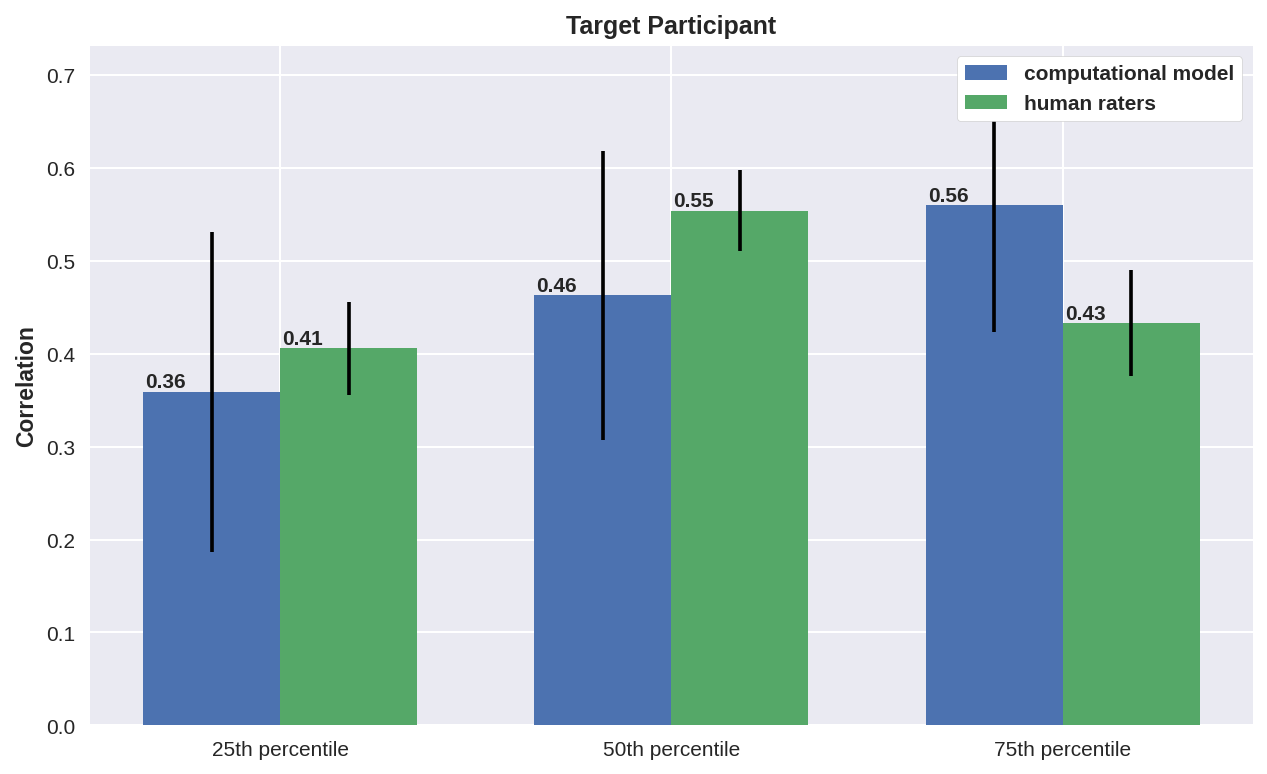

In [ ]:
cor_h, p_h, cor_comp, p_comp = regCorr2(target_list, predictions_targets)
corrs_means = [np.nanmean(x).round(3) for x in cor_h]
pvals_means = [np.nanmean(x).round(3) for x in p_h]
corrs_comps = [np.nanmean(x).round(3) for x in cor_comp]
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

ci_corr_model = [pearsonr_ci(corrs_comps[i], pvals_comps[i], n=100) for i in range(len(corrs_comps))]
yerr_model = [(x[3]-x[2])/2 for x in ci_corr_model]
ci_corr_human = [mean_confidence_interval(x) for x in cor_h]
yerr_human = [(x[2]-x[1])/2 for x in ci_corr_human]

performance = pd.DataFrame(np.array([["25th percentile", 'computational model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'computational model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'computational model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'human raters', corrs_means[0], yerr_human[0]],
                                          ["50th percentile",'human raters',  corrs_means[1], yerr_human[1]],
                                          ["75th percentile", 'human raters',  corrs_means[2], yerr_human[2]]]), columns=["target", "model", "correlation", "yerr"])
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10, 6), dpi = 150)
comp = performance[performance.model == "computational model"]
hum = performance[performance.model == "human raters"]
rects1 = ax.bar(x - width/2, comp.correlation.values, width, label='computational model', yerr = comp.yerr.values, capsize=0.02)
rects2 = ax.bar(x + width/2, hum.correlation.values, width, label='human raters', yerr = hum.yerr.values, capsize=0.02)

for p in ax.patches:
    ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(1, 0), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=10)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation', fontweight = "bold")
ax.set_title('Target Participant', fontweight = "bold")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

##### Plot 4: <br>
Show the models performance on each test fold as a percentile of the human raters' performance

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[Text(0, 0, '25th percentile'),
 Text(0, 0, '50th percentile'),
 Text(0, 0, '75th percentile')]

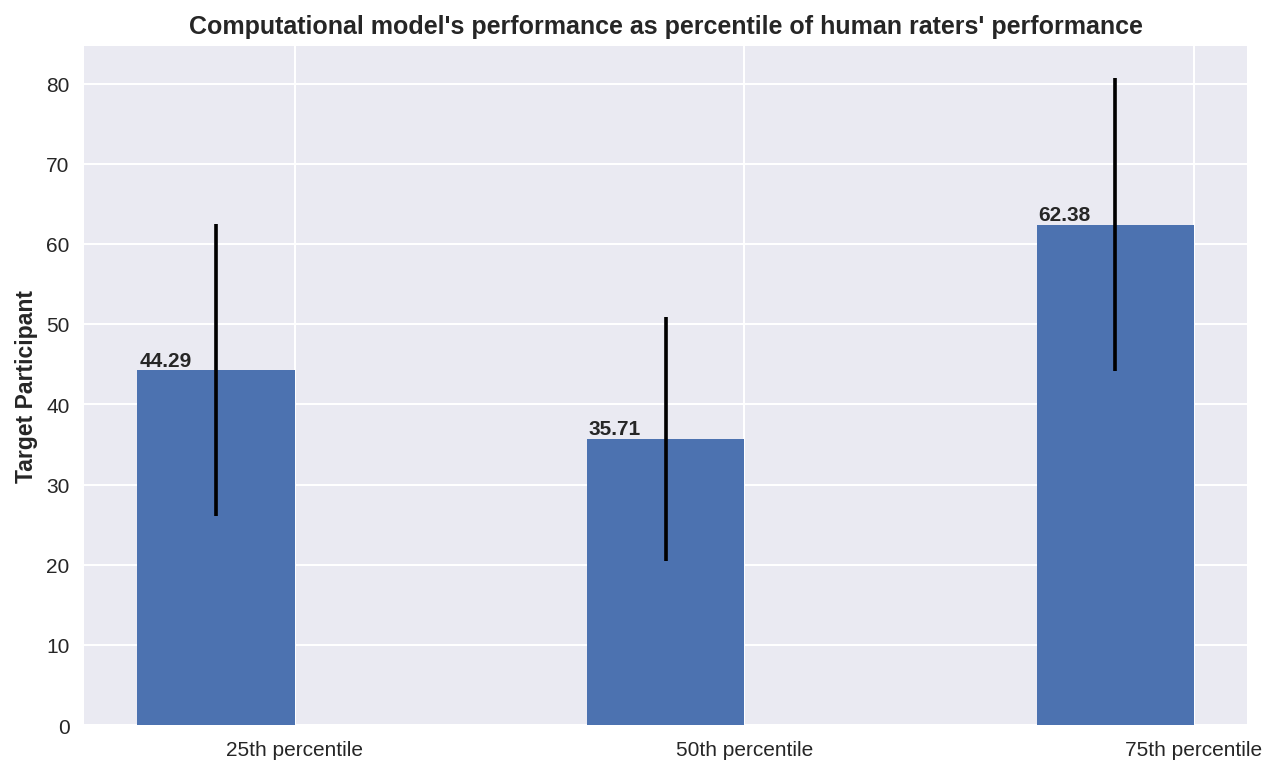

In [ ]:
n_steps = 10
percentiles, corr_c, corr_h = compPercentile(target_list, n_steps, predictions_targets)
comp_perc = [np.nanmean(x).round(3) for x in percentiles] #computational model
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

# CI
ci_corr_model = [mean_confidence_interval(x) for x in percentiles] #comp model
yerr_model = [(x[2]-x[1])/2 for x in ci_corr_model]

#plot dataframe
performance = pd.DataFrame(np.array([["25th percentile", 'computational model', comp_perc[0], yerr_model[0]],
                                      ["50th percentile",'computational model', comp_perc[1], yerr_model[1]],
                                      ["75th percentile", 'computational model', comp_perc[2], yerr_model[2]]]), columns=["target", "model", "correlation", "yerr"])
                                          # ["25th percentile", 'human raters', corrs_means[0], yerr_human[0]],
                                          # ["50th percentile",'human raters',  corrs_means[1], yerr_human[1]],
                                          # ["75th percentile", 'human raters',  corrs_means[2], yerr_human[2]]]),
                                          
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist() #bar labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
comp = performance[performance.model == "computational model"] #comp model bars
hum = performance[performance.model == "human raters"] #human bars
rects1 = ax.bar(x - width/2, comp.correlation.values, width, label='computational model', yerr = comp.yerr.values, capsize=0.02) #bar plots

for p in ax.patches:
    ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(1, 0), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=10)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation', fontweight = "bold")
ax.set_ylabel('Target Participant', fontweight = "bold")
ax.set_title('Computational model\'s performance as percentile of human raters\' performance', fontweight = "bold")
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.legend(loc="upper right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

##### Plot 5: Scatter plot

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


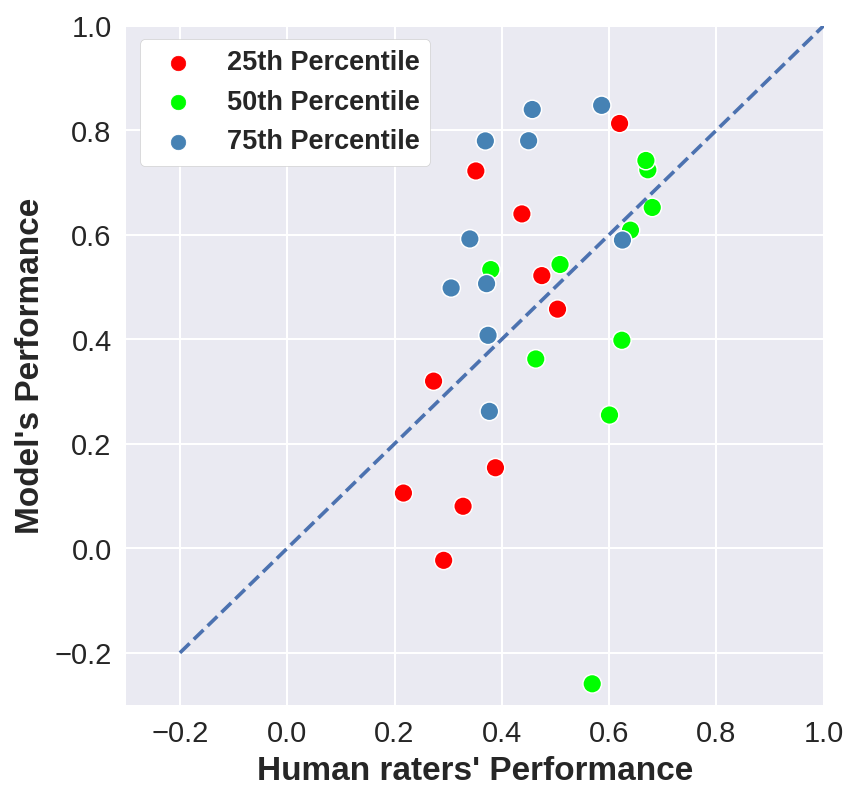

In [ ]:
n_steps = 10
percentiles, corr_c, corr_h = compPercentile(target_list, n_steps, predictions_targets)

#plot dataframe
rows = []
targets=["25th Percentile", "50th Percentile", "75th Percentile"]
for i in range(3):
  humans = nanmean(np.reshape(corr_h[i], (10,21)), 1)
  model = corr_c[i]
  target = [targets[i]]*10
  rows.extend(list(zip(humans, model, target)))
df = pd.DataFrame(rows, columns=["humans", "model", "target"])
color_mapping = {'25th Percentile':'red', '50th Percentile':'white', '75th Percentile':'blue'}
                                          
# plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(6, 6), dpi = 150) #figure specs
# sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','lime','blue'], alpha=0.7)
sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','lime',"steelblue"], alpha=1.0)
# sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','limegreen','deepskyblue'], alpha=0.7)
    
# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model\'s Performance', fontweight = "bold", fontsize=16)
ax.set_xlabel('Human raters\' Performance', fontweight = "bold", fontsize=16)
# ax.set_title('Human vs computational performances for each target participant', fontweight = "bold")
ax.legend(loc="upper left", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold','size':13})
ax.plot((-0.2, 1),(-0.2, 1), ls='--')
plt.xlim(-0.3,1)
plt.ylim(-0.3,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.show()

from google.colab import files
plt.savefig("fig3b.svg")
# files.download("fig3b.svg") 

Correlation of humans and model

In [ ]:
df.humans.corr(df.model)

0.3546540157212505

In [ ]:
# total performances across all targets
print("Model performance: " + str(round(nanmean(corr_c),3)))
print("Human performance: " + str(round(nanmean(corr_h),3)))

Model performance: 0.482
Human performance: 0.465


In [ ]:
# get question order and target ids
q_order = target_25.index.tolist()
target_id1 = predictions_targets.index[0]
target_id2 = predictions_targets.index[1]
target_id3 = predictions_targets.index[2]

In [ ]:
# get predictions and real responses for each target

#target1
p1 = predictions_targets.iloc[0, q_order]
r1 = responses.loc[target_id1, responses.columns[q_order]]

#target2
p2 = predictions_targets.iloc[1, q_order]
r2 = responses.loc[target_id2, responses.columns[q_order]]

#target3
p3 = predictions_targets.iloc[2, q_order]
r3 = responses.loc[target_id3, responses.columns[q_order]]

##### Plot 6
Split Plot 5 by target as facetGrid

In [ ]:
n_steps = 10
percentiles, corr_c, corr_h = compPercentile(target_list, n_steps, predictions_targets)

#plot dataframe
rows = []
targets=["25th Percentile", "50th Percentile", "75th Percentile"]
for i in range(3):
  humans = nanmean(np.reshape(corr_h[i], (10,21)), 1)
  model = corr_c[i]
  target = [targets[i]]*10
  rows.extend(list(zip(humans, model, target)))
df = pd.DataFrame(rows, columns=["Humans", "Model", "Target"])
                                          
plt.style.use("seaborn")
# fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
g = sns.FacetGrid(df, col="Target")
g.map(sns.scatterplot, "Humans", "Model")
g.fig.set_size_inches(45,15)
ax1, ax2, ax3 = g.axes[0]
ax1.plot((0,1), ls='--')
ax2.plot((0,1), ls='--')
ax3.plot((0,1), ls='--')
g.fig.suptitle('Human vs Computational Model\'s Performance for all targets', fontweight = "bold")
g.set_xlabels('Human Performance (correlation)', fontweight = "bold")
g.set_ylabels('Model Performance (correlation)', fontweight = "bold")

##### Plot 7

Show plot 5 as three different scatter plots: <br>
Human vs model correlations by target

In [ ]:
n_steps = 10
percentiles, corr_c, corr_h = compPercentile(target_list, n_steps, predictions_targets)

#create plot dataframe
rows = []
targets=["25th Percentile", "50th Percentile", "75th Percentile"]
for i in range(3):
  humans = nanmean(np.reshape(corr_h[i], (10,21)), 1)
  model = corr_c[i]
  target = [targets[i]]*10
  rows.extend(list(zip(humans, model, target)))
df = pd.DataFrame(rows, columns=["Humans", "Model", "Target"])

# Make three separate plots
for i in targets:
  fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
  df_plot = df[df.Target == i]
  ax = sns.scatterplot(data=df_plot, x="Humans", y="Model")
  ax.set_title("Human vs Computational Model's Performance for target: " + i, fontweight = "bold")
  ax.set_xlabel("Human Performance (correlation)", fontweight = "bold")
  ax.set_ylabel("Model Performance (correlation)", fontweight = "bold")
  ax.plot((0,1), ls='--')

##### Plot 8
Show overlay of human and computational model's Performance as test fold correlations

In [ ]:
# show humans and model in single plot -> might be less clear
df2 = pd.melt(df,id_vars="Target", value_vars=["Model", "Humans"], value_name="correlation", var_name="Predictor")
ax = sns.scatterplot(data=df2, y="correlation", x="Target", hue="Predictor")
ax.scatter(x="25th Percentile", y = nanmean(corr_c[0]), color = "r")
ax.scatter(x="50th Percentile", y = nanmean(corr_c[1]), color = "r")
ax.scatter(x="75th Percentile", y = nanmean(corr_c[2]), color = "r")
#mark human averages
ax.scatter(x="25th Percentile", y = nanmean(corr_h[0]), color = "k")
ax.scatter(x="50th Percentile", y = nanmean(corr_h[1]), color = "k")
ax.scatter(x="75th Percentile", y = nanmean(corr_h[2]), color = "k")
ax.set_title("Human raters' and computational model's performance as test fold correlations")

##### Plot 9:
Computational Model's Performance as test fold correlations

In [ ]:
df2 = pd.melt(df,id_vars="Target", value_vars=["Model", "Humans"], value_name="correlation", var_name="Predictor")
ax = sns.scatterplot(data=df, y="Model", x="Target")
ax.scatter(x="25th Percentile", y = nanmean(corr_c[0]), color = "r")
ax.scatter(x="50th Percentile", y = nanmean(corr_c[1]), color = "r")
ax.scatter(x="75th Percentile", y = nanmean(corr_c[2]), color = "r")
ax.set_ylabel("Correlations")
ax.set_title("Computational model's performance as test fold correlations")

##### Plot 10:
Show human performance as its correlations by fold

In [ ]:
ax = sns.scatterplot(data=df, y="Humans", x="Target")
ax.scatter(x="25th Percentile", y = nanmean(corr_h[0]), color = "r")
ax.scatter(x="50th Percentile", y = nanmean(corr_h[1]), color = "r")
ax.scatter(x="75th Percentile", y = nanmean(corr_h[2]), color = "r")
ax.set_ylabel("Correlations")
ax.set_title("Human raters' performance as test fold correlations")

### Bar plot for construct/key prediction performance

#### Function for context plot creation

In [7]:
#create functions:
def contextAccuracy(context="construct", i='Big5'):
  performance = pd.DataFrame(columns=["Dataset", "Target", "Model", "Accuracy"])
  #get the output data and path for respective context
  if context=="keys":
    m = 1
    par = 10  
    model, modelName = predModel(m,par) 
    e = "sentencebert"
    ending = "_encodings_constrBased"
    #load path and necessary variables:
    folder, data = chooseData(i)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
    embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
    savePath = path1 + folder + "new_results/by_embeddings/nonReversed/"
    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]
    # import required data and labels:
    embeddings_df = pd.read_csv(path1 + folder + data +  embeddings,index_col=0)
    constructs = pd.read_csv(path1 + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
    constrAssigned = constructs.loc[embeddings_df.index,:] #only take constructs/encodings of items with embeddings
    constrAssigned = constrAssigned[constrAssigned.construct != 'not assigned']
    constructs_list = constrAssigned.construct.drop_duplicates().values
    y = constrAssigned.encoding.replace([-1,1],[1,0])
    func = accuracy_keys
  elif context=="construct":
    ending = "_constructs"
    m = 1
    par = 1000 
    model, modelName = predModel(m,par) 
    e = "sentencebert"
    #load path and necessary variables:
    folder, data = chooseData(i)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
    embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
    savePath = path1 + folder + "new_results/by_embeddings/nonReversed/"
    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]
    # import required data and labels:
    embeddings_df = pd.read_csv(path1 + folder + data +  embeddings,index_col=0)
    constructs = pd.read_csv(path1 + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
    constrAssigned = constructs.loc[embeddings_df.index,:] #only take constructs/encodings of items with embeddings
    constrAssigned = constrAssigned[constrAssigned.construct != 'not assigned']
    constructs_list = constrAssigned.construct.drop_duplicates().values
    # print(constructs_list)
    #dicts to convert number to constructs and vice versa
    y_constr = constrAssigned.construct
    constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
    y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= y_constr.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)    
    func = accuracy_constr
  
  # get predicted responses of chosen model:
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + ending + ".csv", index_col=0)
  total_preds.index = total_preds.index.map(str)
  total_preds = total_preds.astype(float)

  total_preds2 = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + 'LIWC' + ending + ".csv", index_col=0)
  total_preds2.index = total_preds2.index.map(str)
  total_preds2 = total_preds2.astype(float)

  total_preds3 = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + 'WORD2VEC' + ending + ".csv", index_col=0)
  total_preds3.index = total_preds3.index.map(str)
  total_preds3 = total_preds3.astype(float)

  total_dumb = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + ending + '_dumb' + ".csv", index_col=0)
  total_dumb.index = total_dumb.index.map(str)
  total_dumb = total_dumb.astype(float)

  #get performance metrict
  results  = func(total_preds, y, constructs_list)
  results2 = func(total_preds2, y, constructs_list)
  results3 = func(total_preds3, y, constructs_list)
  results_dumb = func(total_dumb, y, constructs_list)

  #combine in single frame
  performance.loc[len(performance)] = [i, context, "Best Model",  results]
  performance.loc[len(performance)] = [i, context, "WORD2VEC",    results2]
  performance.loc[len(performance)] = [i, context, "LIWC",        results3]
  performance.loc[len(performance)] = [i, context, "Baseline", results_dumb]
  #combine correlations of all datasets in one frame
  return performance

def change_width(ax, new_value) :
  for patch in ax.patches :
      current_width = patch.get_width()
      diff = current_width - new_value

      # we change the bar width
      patch.set_width(new_value)

      # we recenter the bar
      patch.set_x(patch.get_x() + diff * .5)

#### Bar plots for all datasets

constructs

running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

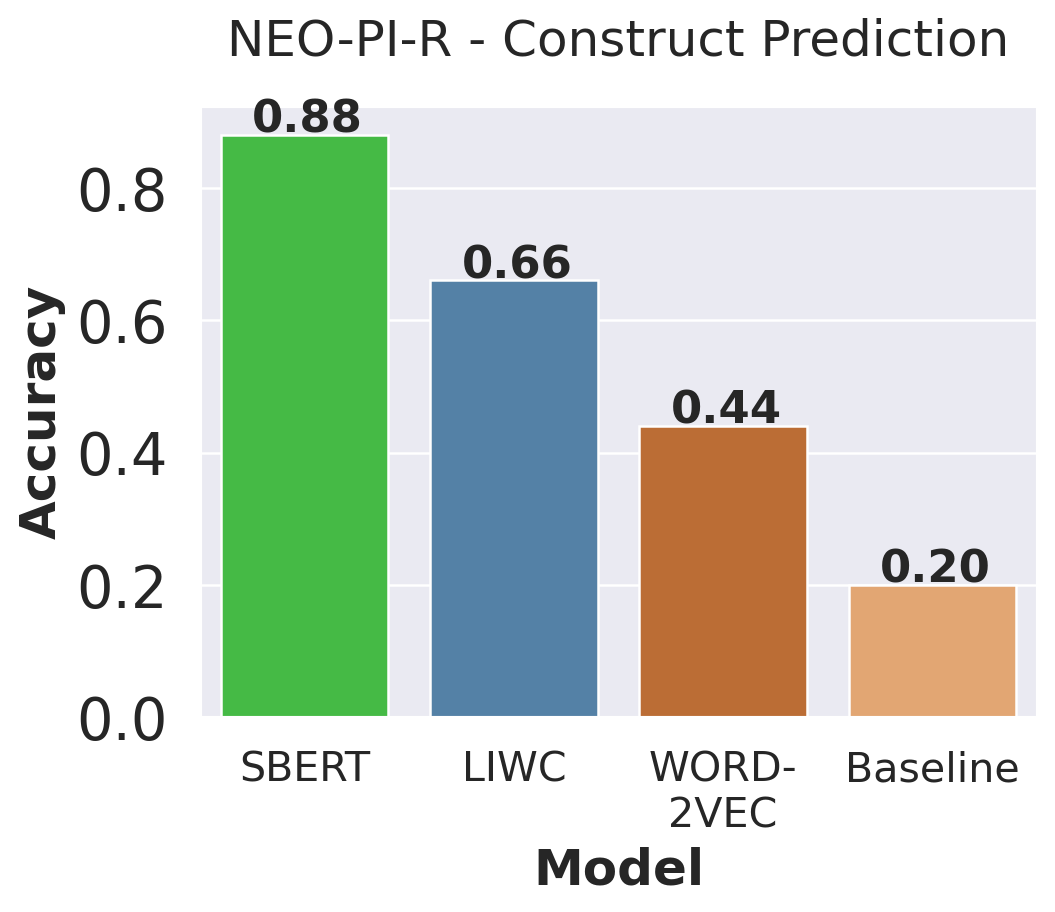

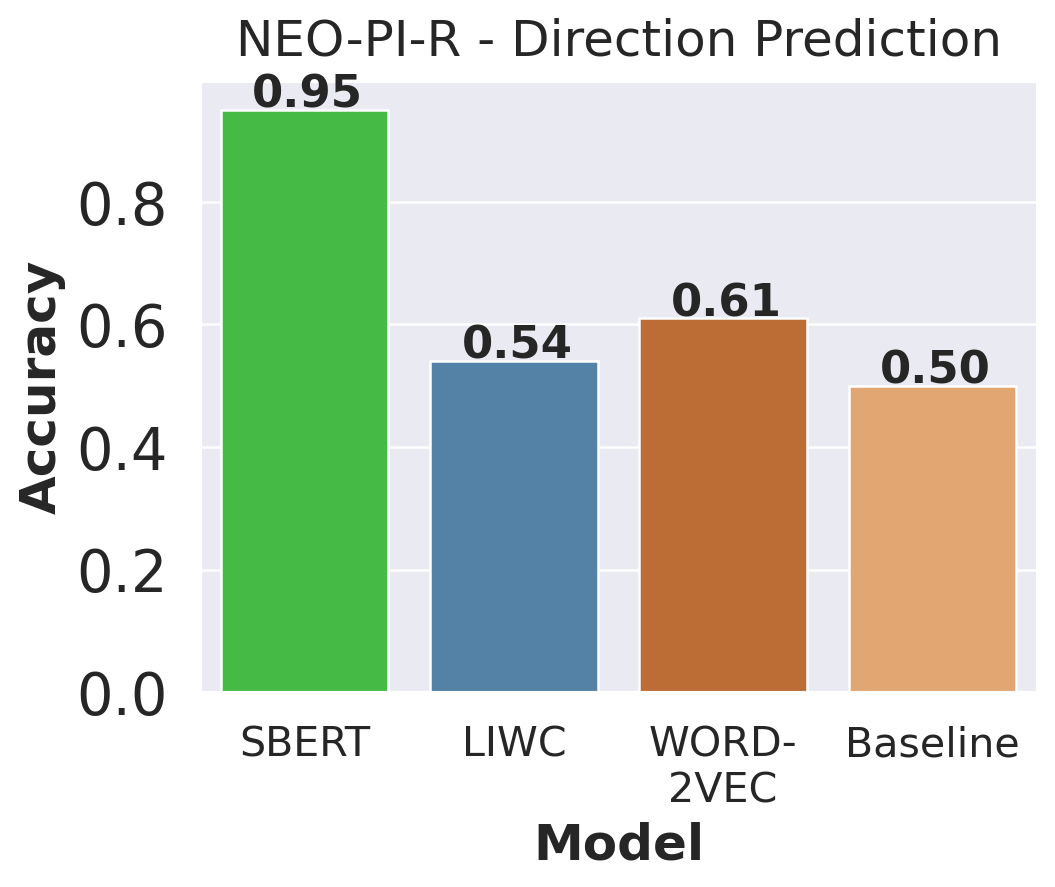

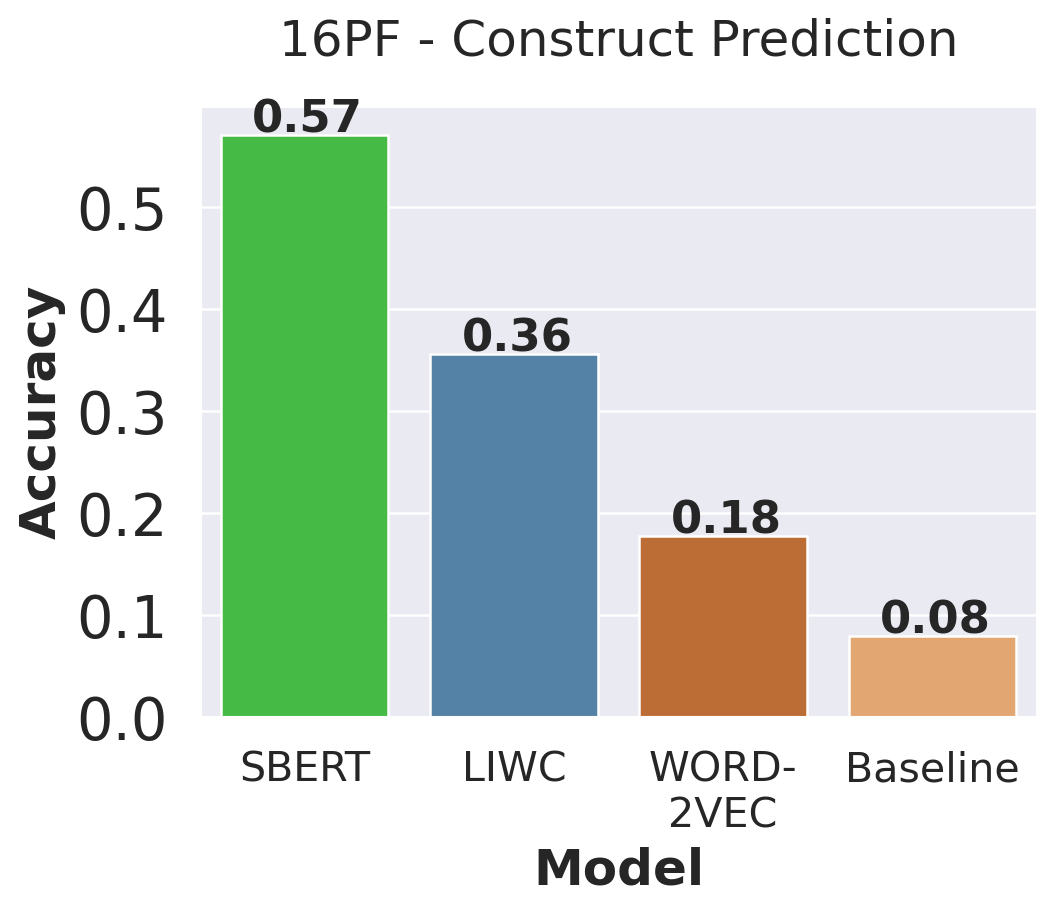

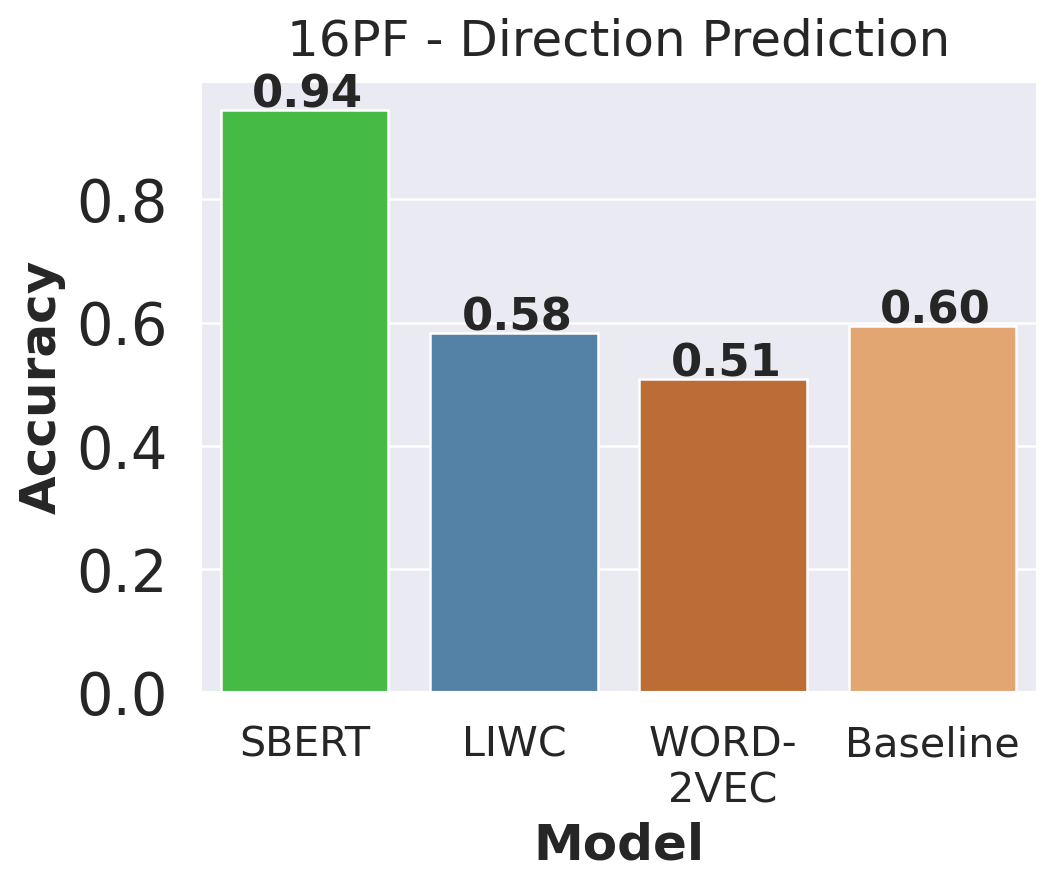

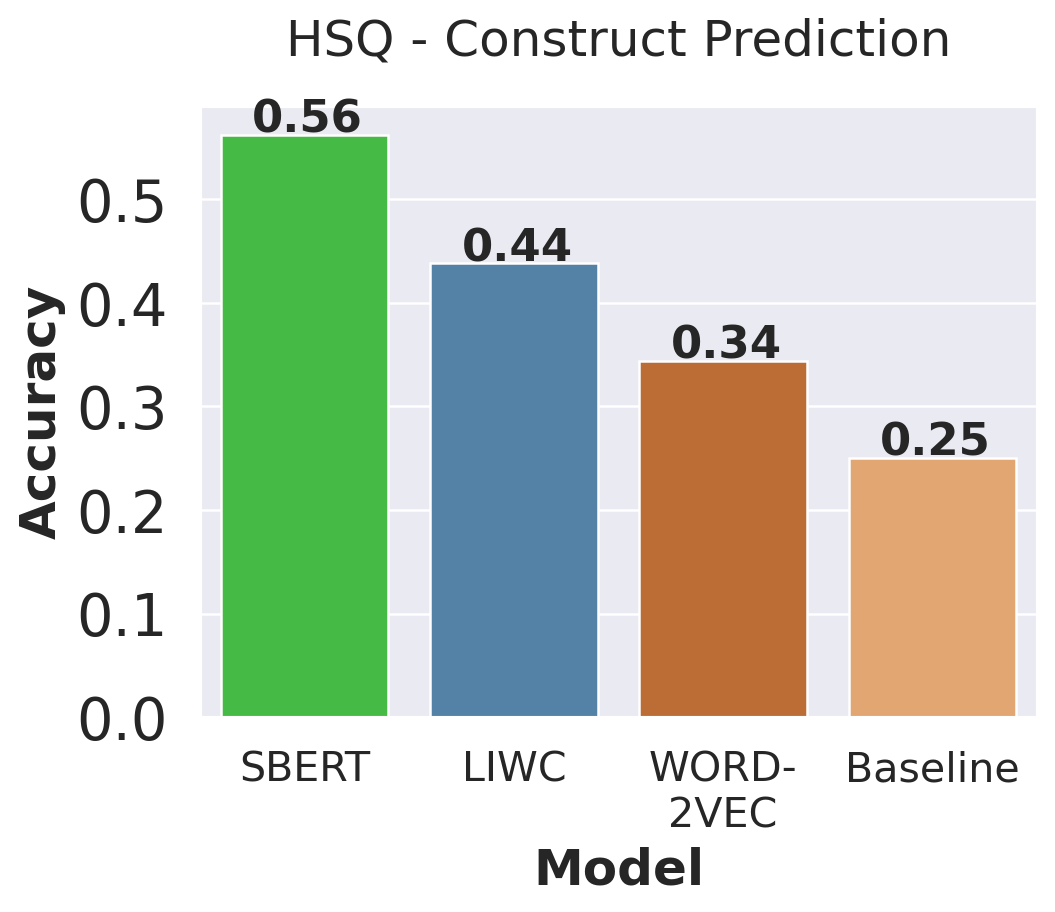

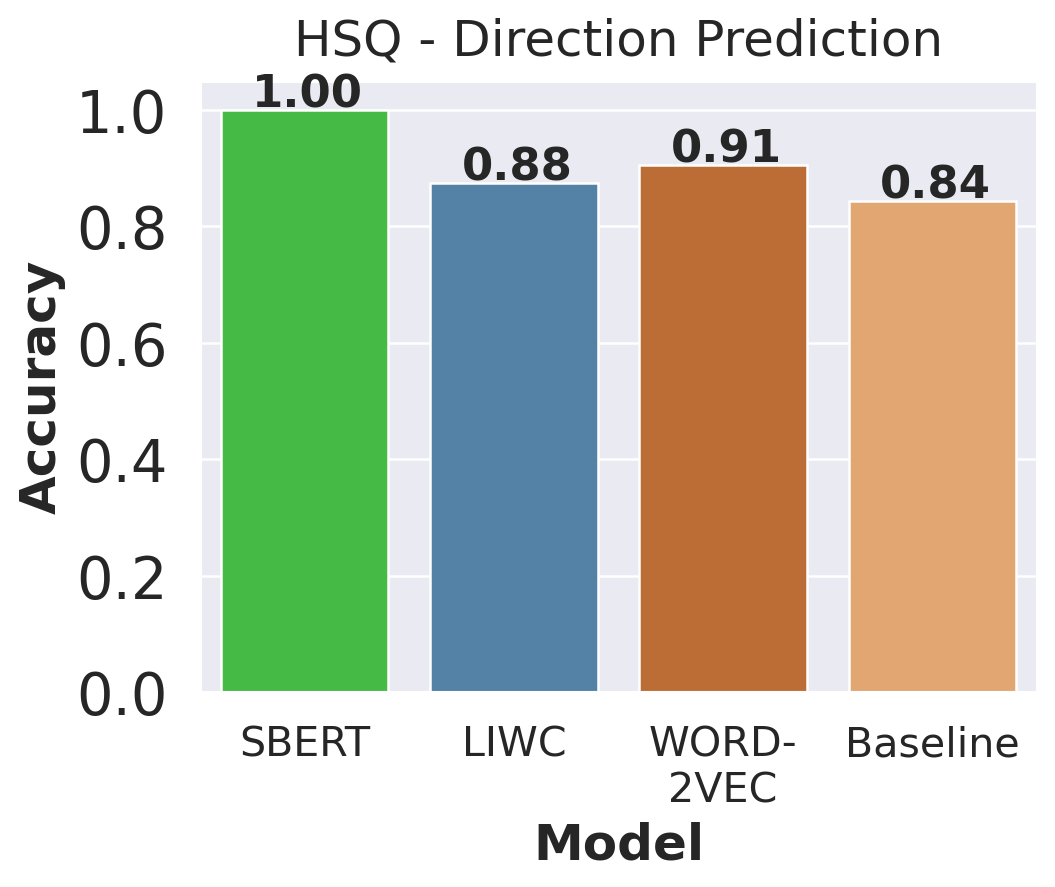

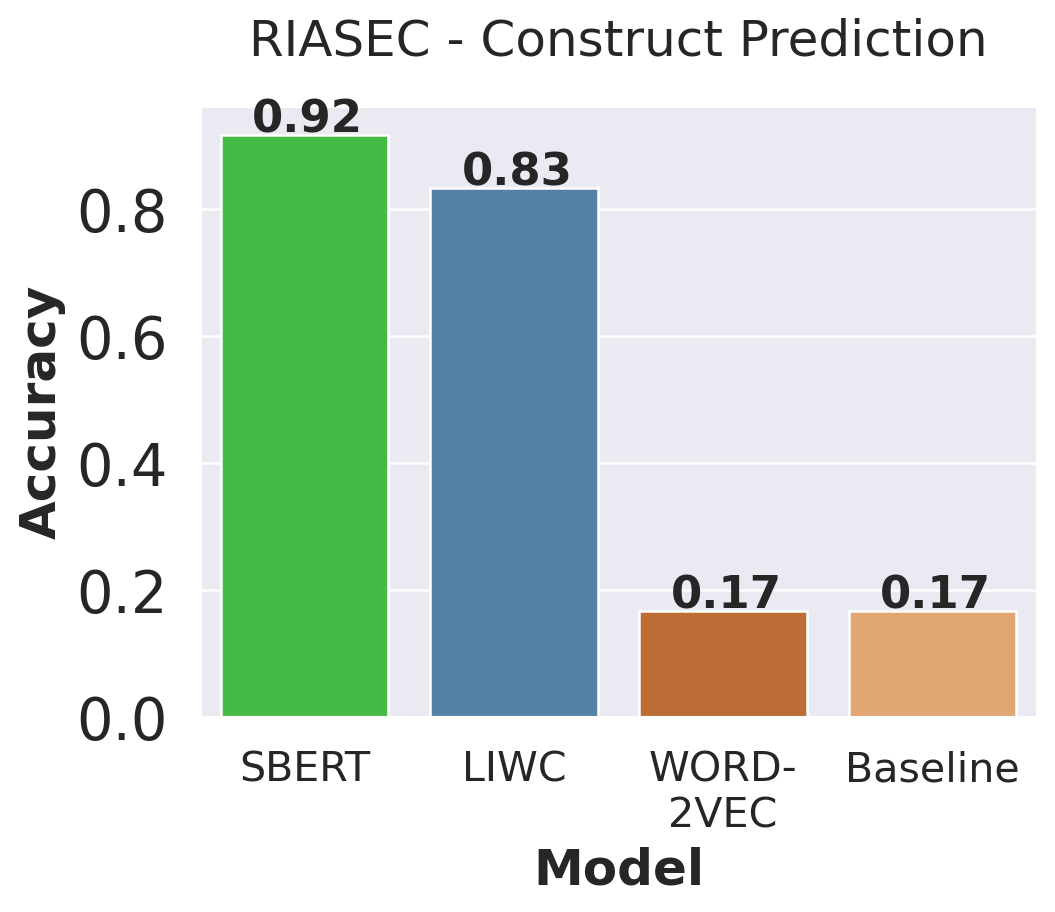

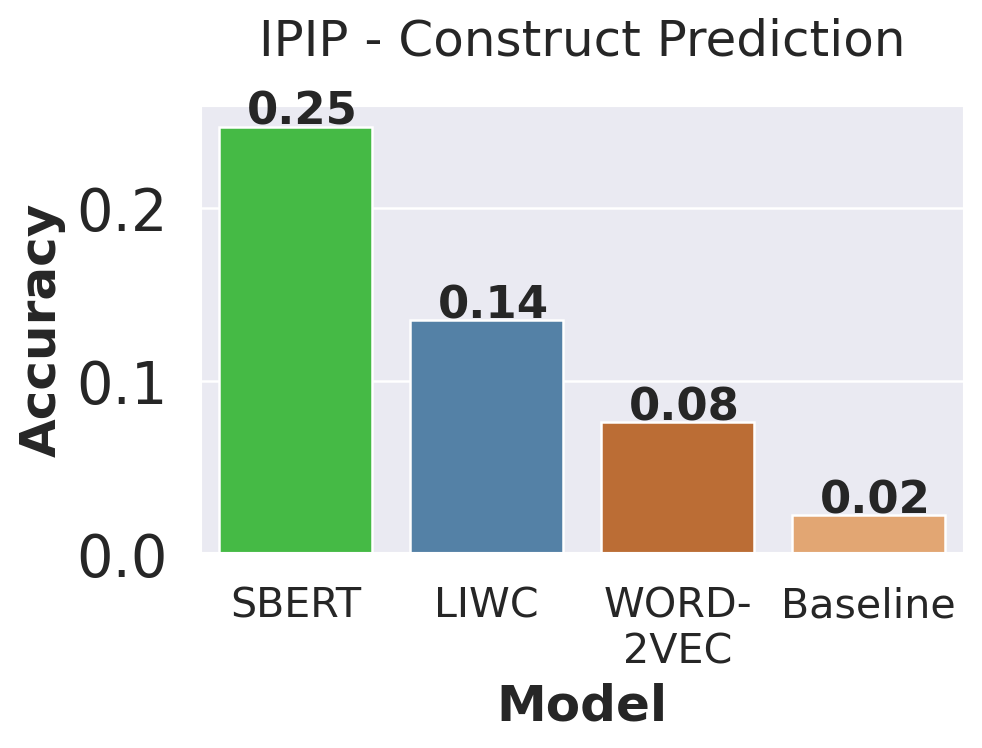

In [51]:
# change to separate panels (subplots)

#new bar plots:
datasets_con = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP2']
datasets_dir = ['BIG5', '16PF', 'HSQ']
names_con = ['NEO-PI-R', '16PF', 'HSQ', 'RIASEC', 'IPIP']
names_dir = ['NEO-PI-R', '16PF', 'HSQ']
performance_con = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])
performance_dir = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])

#iterate through datasets for construct data
for i,nr in zip(datasets_con, range(len(datasets_con))):
  results_con = contextAccuracy("construct", i)
  performance_con = performance_con.append(results_con)

#iterate through datasets for direction data
for i,nr in zip(datasets_dir, range(len(datasets_dir))):
  results_dir = contextAccuracy("keys", i)
  performance_dir = performance_dir.append(results_dir)

cols = performance_con.columns.drop(['Dataset', 'Target', 'Model'])
performance_con[cols] = performance_con[cols].astype(float)
performance_dir[cols] = performance_dir[cols].astype(float)

performance_con['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_con['Model']]
performance_dir['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_dir['Model']]
performance_con['Model'] = ["WORD-\n2VEC" if item=="WORD2VEC" else item for item in performance_con['Model']]
performance_dir['Model'] = ["WORD-\n2VEC" if item=="WORD2VEC" else item for item in performance_dir['Model']]

#Plot style and meta
plt.style.use('seaborn')
sns.set_context('paper')
sns.set(font_scale = 1.5)

# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 12), squeeze=False, sharex=False)
l=0 #for labelling of the panels (if only one type of plot is plotted)
for i in range(5):
    # fig.add_subplot(5, 2, 2*i+1)
    fig  = plt.figure(figsize=(6, 4.5), dpi= 180)
    ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "LIWC", "WORD-\n2VEC", "Baseline"] , orient='v', data=performance_con[performance_con['Dataset']== datasets_con[i]], 
                     palette=["limegreen", "steelblue", "chocolate", "sandybrown"])
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 4, p.get_height()),
              xytext=(18, height), textcoords='offset points', ha="center", va="center", fontweight='bold',fontsize=18)

    plt.ylabel("Accuracy", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20)
    plt.title(names_con[i] + " - Construct Prediction", fontsize=20, pad=20)
    plt.yticks(size = 23)
    # ax.set_yticklabels(ax.get_yticks(), size = 20)
    
    fig_name = "fig5_" + chr(65+2*i) + ".pdf"
    from google.colab import files
    plt.savefig(fig_name, bbox_inches='tight')
    files.download(fig_name)

    #Add the direction plots for each data set:
    if i<3:
      # fig.add_subplot(5, 2, 2*i+2)
      fig  = plt.figure(figsize=(6, 4.5), dpi= 180)
      ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "LIWC", "WORD-\n2VEC", "Baseline"] , orient='v', data=performance_dir[performance_dir['Dataset']== datasets_dir[i]], 
                      palette=["limegreen","steelblue", "chocolate", "sandybrown"])
      for p in ax.patches:
        if p.get_height() < 0:
          height = -6
        else:
          height = 6
        ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 4, p.get_height()),
                xytext=(18, height), textcoords='offset points', ha="center", va="center", fontweight='bold',fontsize=18)

      plt.ylabel("Accuracy", fontweight='bold', fontsize=20)
      plt.xlabel("Model", fontweight='bold', fontsize=20)
      plt.title(names_dir[i] + " - Direction Prediction", fontsize=20, pad=10)
      plt.yticks(size = 23)
      l=0
      fig_name = "fig5_" + chr(65+2*i+1) + ".pdf"
      from google.colab import files
      plt.savefig(fig_name, bbox_inches='tight')
      files.download(fig_name)
    else:
      l=1



plt.tight_layout()

# from google.colab import files
# plt.savefig("fig4a.svg")
# files.download("fig4a.svg")

keys

### Visualise Construct score performance

running KnnReg: 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

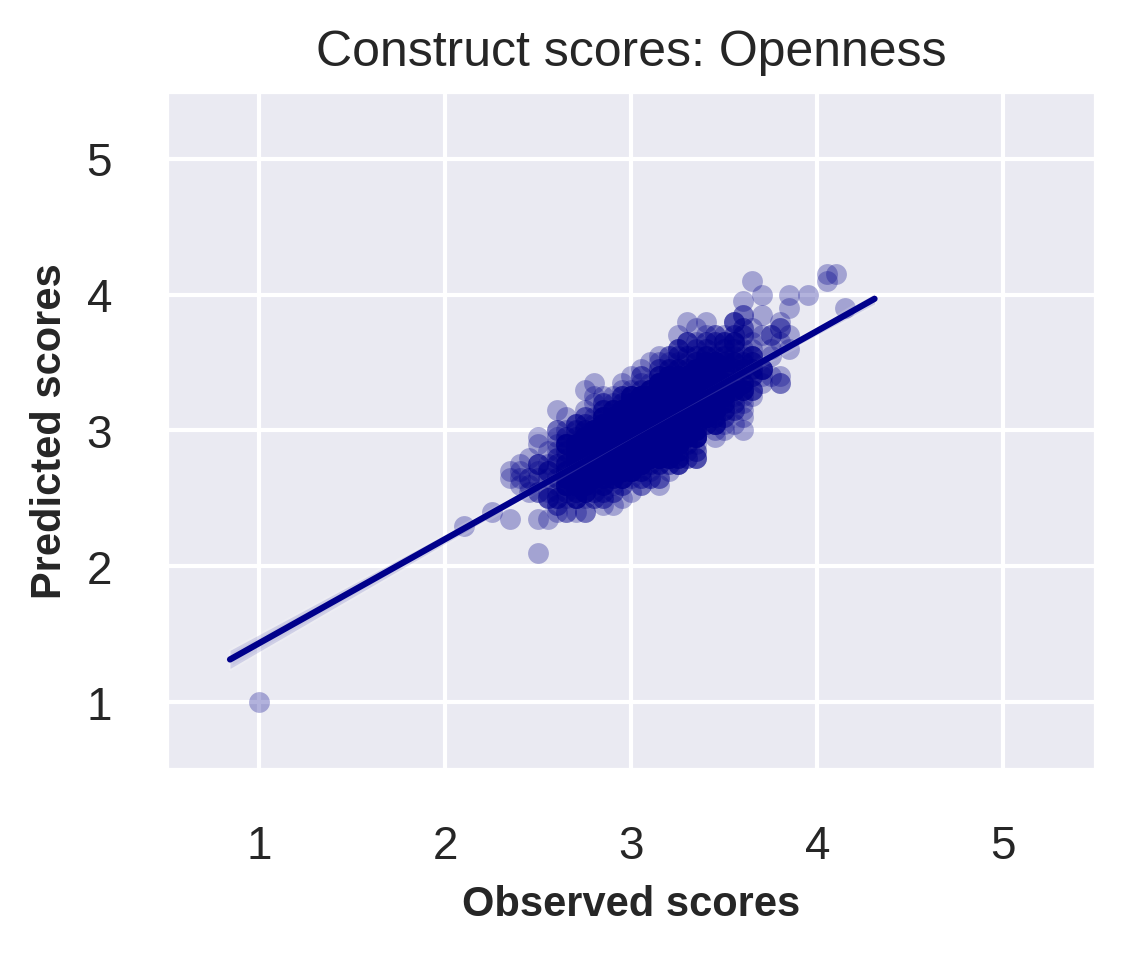

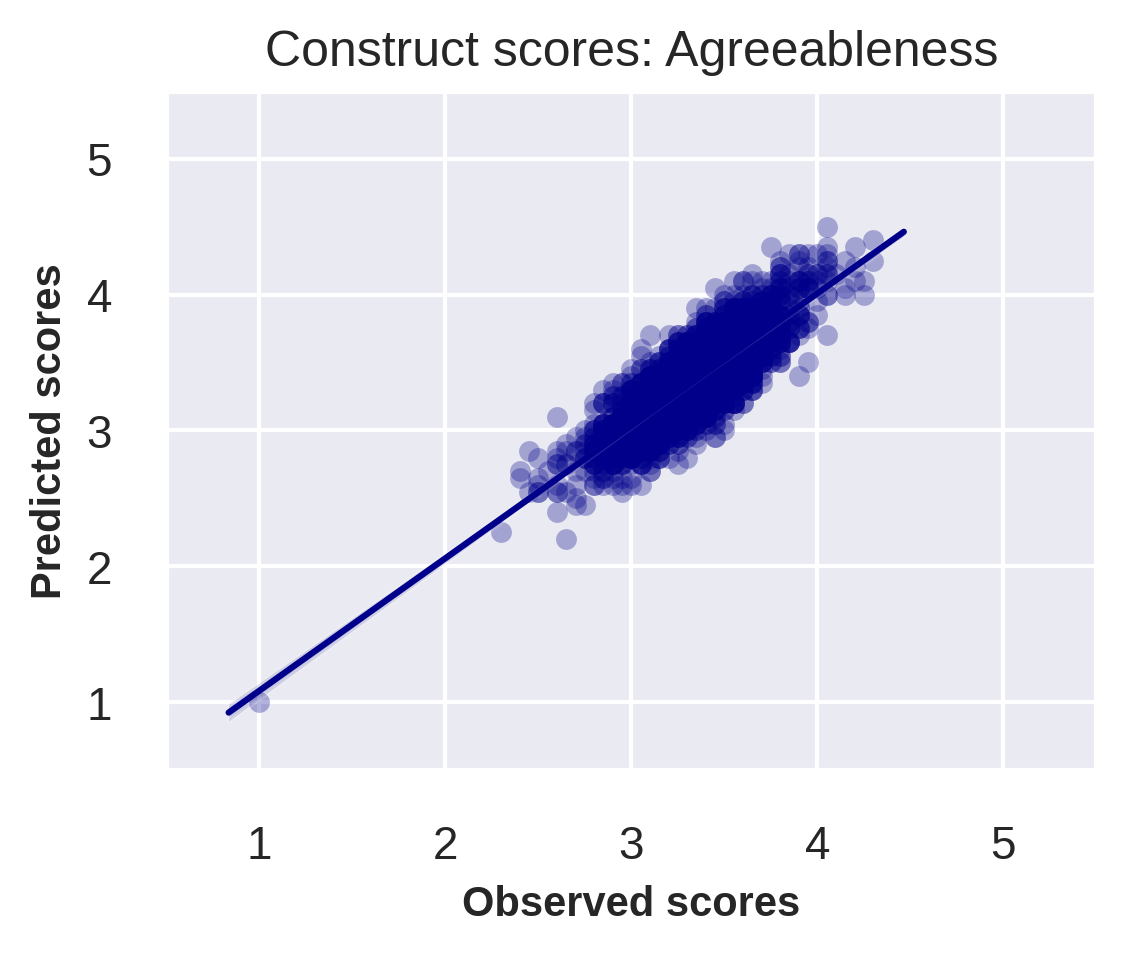

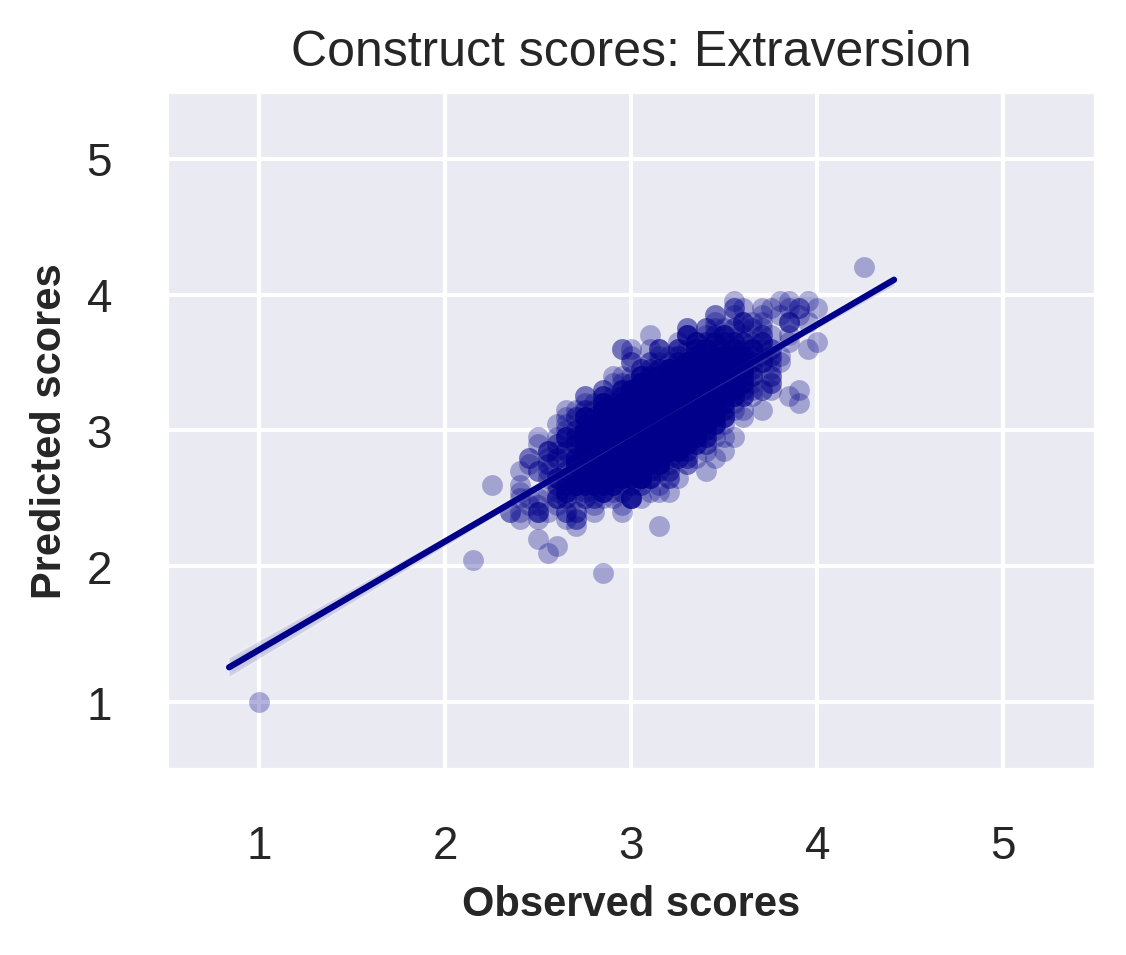

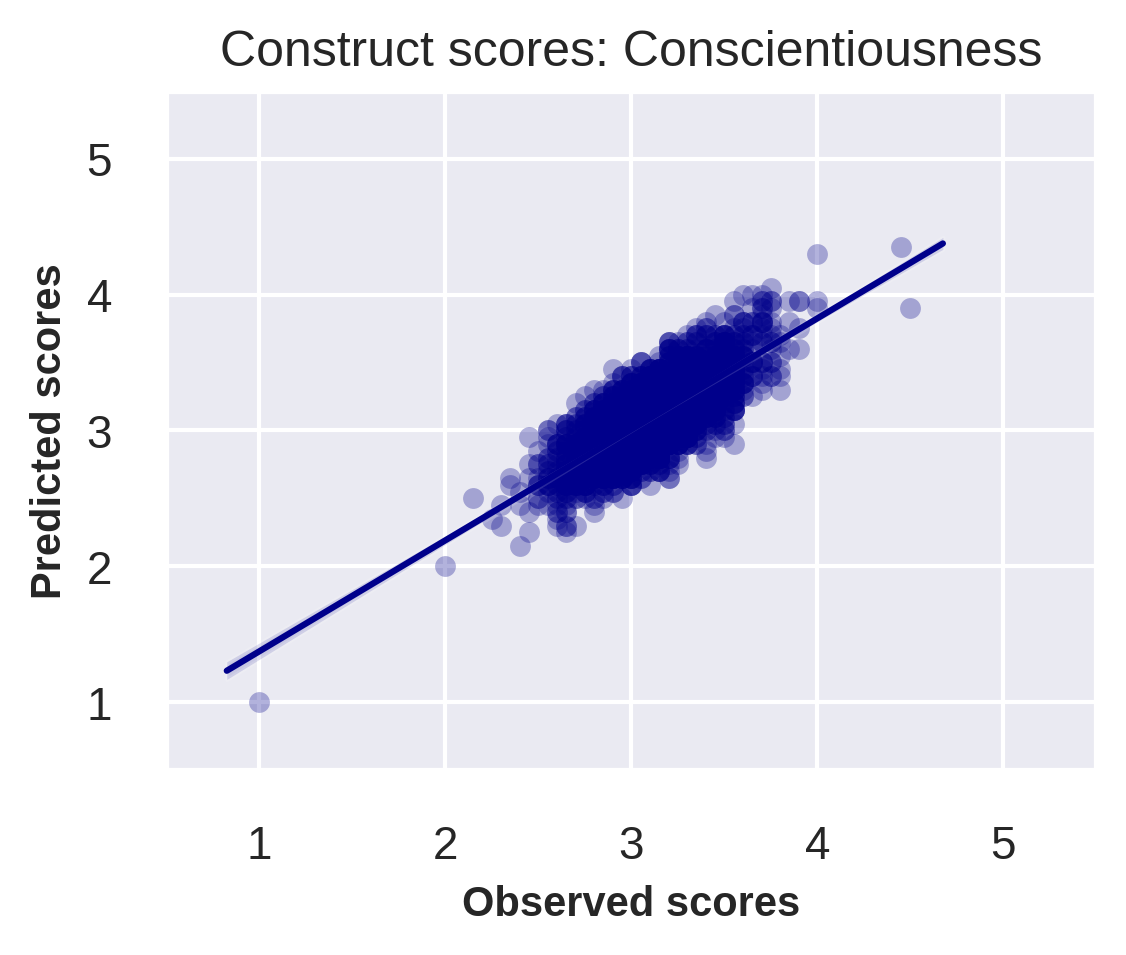

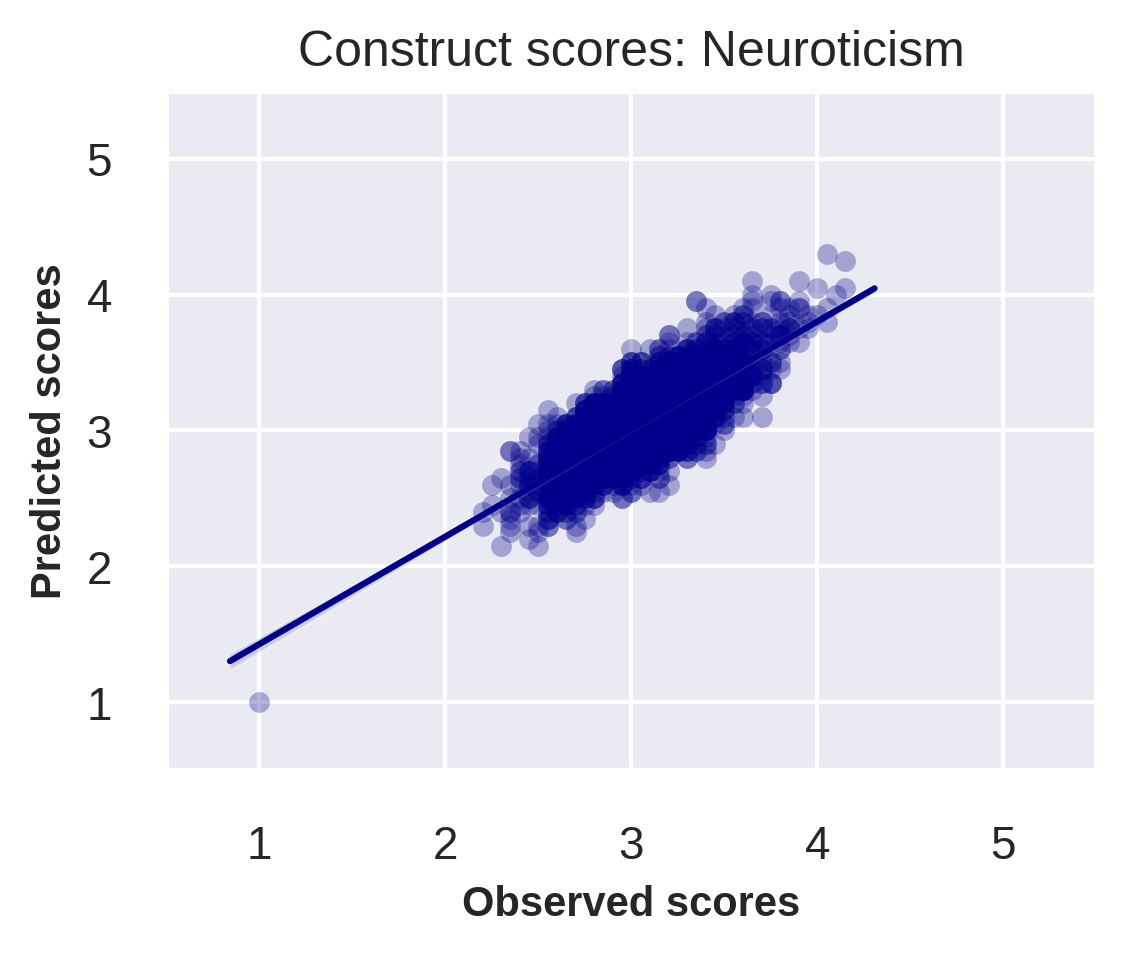

In [ ]:
import seaborn as sns

#load Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "big5"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

questions = total_preds.columns
constr_dict = {"O":"Openness", "C": "Conscientiousness", "E": "Extraversion", "A":"Agreeableness", "N":"Neuroticism"}
#get ocean scores
for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
  #labels and predictions for current construct 
  #find questions of current construct
  constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
  constr_idx = np.where(constrValues == i)[0]  
  # config figure
  plt.figure(figsize=(4, 3), dpi=300)
  # sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
  sns.set(font_scale=1.0)
  # use the function regplot to make a scatterplot
  sns.regplot(truncate=False, scatter_kws={"color": "darkblue", 'alpha': 0.3,'s':25}, x=total_preds.iloc[:,constr_idx].mean(1), y=responses.iloc[:,constr_idx].mean(1), line_kws={"color": "darkblue", 'linewidth':1.5}).set_title('Construct scores: ' + constr_dict[i])
  plt.ylim(0.5,5.5)
  plt.xlim(0.5,5.5)
  plt.xlabel("Observed scores", fontweight="bold", fontsize=10)
  plt.ylabel("Predicted scores", fontweight="bold", fontsize=10)
  plt.style.use('seaborn')
  # plt.show()

  from google.colab import files
  plt.savefig(constr_dict[i]+'_construct_score.pdf',bbox_inches='tight')
  files.download(constr_dict[i]+'_construct_score.pdf')

In [ ]:
questions

Index(['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11',
       'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20', 'q21',
       'q22', 'q23', 'q24', 'q25', 'q26', 'q27', 'q28', 'q29', 'q30', 'q31',
       'q32', 'q33', 'q34', 'q35', 'q36', 'q37', 'q38', 'q39', 'q40', 'q41',
       'q42', 'q43', 'q44', 'q45', 'q46', 'q47', 'q48', 'q49', 'q50', 'q51',
       'q52', 'q53', 'q54', 'q55', 'q56', 'q57', 'q58', 'q59', 'q60', 'q61',
       'q62', 'q63', 'q64', 'q65', 'q66', 'q67', 'q68', 'q69', 'q70', 'q71',
       'q72', 'q73', 'q74', 'q75', 'q76', 'q77', 'q78', 'q79', 'q80', 'q81',
       'q82', 'q83', 'q84', 'q85', 'q86', 'q87', 'q88', 'q89', 'q90', 'q91',
       'q92', 'q93', 'q94', 'q95', 'q96', 'q97', 'q98', 'q99', 'q100'],
      dtype='object')

Look up specific construct score performances

In [ ]:
i = "A" #construct abbreviation
constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
constr_idx = np.where(constrValues == i)[0]  
pearsonr(total_preds.iloc[:,constr_idx].mean(1), responses.iloc[:,constr_idx].mean(1))

(0.8317703721051959, 0.0)

### Visualising Question Embeddings: Wordclouds

Define Dataset and embeddings type:

In [ ]:
d = "ipip"      #IPIP: all items, IPIP2: only assigned
e = "use"

nAssigned = 0 #0: only assigned items, #1: include non-assigned items

#choose data set, embeddings, encoding
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items = getResponses(path1, folder, data, 2) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(0)

embeddings = X.values

Clustering based on question embeddings

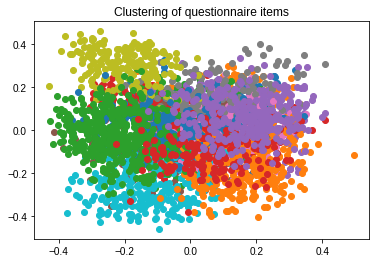

In [ ]:
#Number of clusters
k = 15
#include/exclude non assigned items
nAssigned = 1

if nAssigned == 0:
  plt_emb = X.iloc[np.where(constrAssigned.construct != 'not assigned')]
else:
  plt_emb = X

#K-Means clustering
model = KMeans(n_clusters = k, random_state=randState)
model.fit(plt_emb)
yhat = model.predict(plt_emb)
#2D reduction for plotting
all_emb = PCA(2, random_state=0).fit_transform(plt_emb.values) #2D dimension reduction

clusters = np.unique(yhat) # retrieve unique clusters
# create scatter plot for samples from each cluster
for cluster in clusters:
	row_ix = np.where(yhat == cluster)[0]                 # get row indexes for samples with this cluster
	plt.scatter(all_emb[row_ix, 0], all_emb[row_ix, 1]) # create scatter plot
plt.title("Clustering of questionnaire items")
plt.style.use('seaborn')
plt.show()

#createa dataframe that contains all items grouped by cluster
itemlist = constrAssigned.loc[plt_emb.index,'item'].drop_duplicates()
clusterOverview = pd.DataFrame(np.full((1,k),0))
clusters = []
for i in range(k):
  clusters.append(np.where(yhat==i)[0])
find = list(range(len(itemlist)))
replace = itemlist
clusterOverview = pd.DataFrame(clusters).T.replace(find, replace)

Define Functions for preprocessing

In [ ]:
#load libraries and define preprocessing function (most preprocessing has already been done previously for other tasks)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

import nltk
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

#Define tokenisation functions
def preprocess(items):
  #remove symbols
  symbols = "!#$%&()*+-./:;<=>?@[\]^_`{|}~"
  for i in symbols:
      items = [word.replace(i, ' ') for word in items]
  docs = [[lemmatizer.lemmatize(word) for word in sublist.split()] for sublist in items] #lemmatise
  items = [" ".join(sublist) for sublist in docs] #unflatten list
  return items, docs

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Find most frequent terms in the IPIP

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


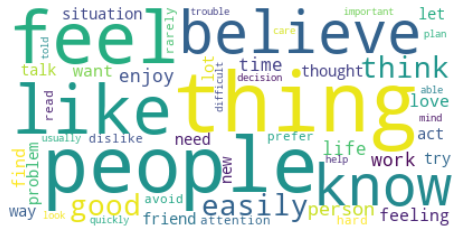

In [ ]:
# find good stop words:
#get the texts 
texts = pd.DataFrame(clusterOverview.values.flatten()).dropna().values.flatten()
docs = texts.tolist() #all items as individual strings in list

#preprocess: remove symbols, stopwords, lemmatise, stemming
total_items, total_docs = preprocess(docs)
#eliminate basic stop words
# stopwords=stop_words.ENGLISH_STOP_WORDS
sp_words, _ = preprocess(STOP_WORDS)

# use tf-idf, calculate frequencies and find the most frequent ones in the document -> add to stop words list
vec=TfidfVectorizer(max_df=0.85,stop_words=sp_words, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()))
tfidf_vector=vec.fit_transform(total_items)
feature_names = vec.get_feature_names()
dense = tfidf_vector.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
frequency = df.T.sum(1)
Cloud = WordCloud(background_color="white", max_words=50, random_state=0, stopwords=sp_words).generate_from_frequencies(frequency)#.generate(" ".join(total_items))#
plt.imshow(Cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# remove words frequent across all documents -> improve wordclouds by removing too generic terms
a = list(sp_words)
a.extend(frequency.sort_values()[::-1][0:8].index.tolist())

Word Clouds by cluster

In [ ]:
#create word clouds for each cluster
import random
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    c1 = round(random.randint(50, 90),3)
    c2 = round(random.randint(30, 50),3)
    return "hsl(235, " + str(c1) + "%, " + str(c2) + "%)"

for nc in range(clusterOverview.shape[1]):
  # preprocess
  cluster_texts = clusterOverview[nc].dropna().values # all cluster item texts
  cluster_items, cluster_docs = preprocess(cluster_texts)
  Cloud = WordCloud(background_color="white", stopwords=a, max_words=85, random_state=0, collocations=False, width=1920, height=1080).generate(" ".join(cluster_items))#.generate_from_frequencies(cluster_frequency)
  plt.figure(figsize=(20,10))
  plt.imshow(Cloud, interpolation='bilinear')
  plt.imshow(Cloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
  plt.axis("off")
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

Check which constructs are in the clusters

In [ ]:
#get the constructs from the IPIP that are in our new clusters
clusterConstructs = pd.DataFrame()
for i in range(clusterOverview.shape[1]):
  items = clusterOverview.iloc[:,i]
  #get construct
  constructs_idx = np.where(constrAssigned.item.isin(items))[0]
  constructs = constrAssigned.construct[constructs_idx].values
  #summarise which constructs occur how often
  summary = Counter(constructs)
  #get 5 (excluding "not assigned") most frequent one with number:
  clusterConstructs[i] = summary.most_common(10)
clusterConstructs

0   ...                                                 14
0                                (not assigned, 164)  ...                                (not assigned, 166)
1  (risk-taking/sensation-seeking/thrill-seeking,...  ...                                    (depression, 8)
2                                   (sociability, 9)  ...                                (health anxiety, 6)
3                                     (curiosity, 7)  ...                                       (anxiety, 6)
4     (aesthetic appreciation/artistic interests, 6)  ...                                 (hope/optimism, 5)
5                                  (introversion, 5)  ...                                     (self-harm, 4)
6                          (intellectual-breadth, 4)  ...                                   (neuroticism, 3)
7                                 (exhibitionism, 4)  ...                      (vitality/enthusiasm/zest, 3)
8                      (vitality/enthusiasm/zest, 4)  ...       (conformity/dependence/need for approval, 3)
9                               (adventurousness, 4)  ...  (risk-taking/sensation-seeking/thrill-seeking, 2)

[10 rows x 15 columns]

Find items of interest in a cluster

In [ ]:
cl = 14 #cluster
search = "life" #search word
mask = clusterOverview.iloc[:,cl].str.contains(search).fillna(False)
df = clusterOverview.loc[(mask),clusterOverview.columns[cl]].copy(deep=True)
df

9      am afraid that my life will be cut short by il...
18                               am content with my life
27                                 am happy with my life
34                    am not sure where my life is going
46                             am satisfied with my life
94                          feel life is boring or bland
112                           feel short-changed in life
124                        feel that life has no meaning
130                    feel that my life lacks direction
131    feel that my life would be better if i owned c...
136               feel that the pace of life is too fast
137    feel that work is not an important part of my ...
148                                  find life difficult
163    have all the material things i really need to ...
167         have become extremely jealous in my lifetime
168              have been depressed for much of my life
185    have never given serious thought to ending my ...
186         have no plan for my

### Construct/Item similarities

Get embeddings of items in each construct

running KnnReg: 




BIG5
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     103.5
Date:                Fri, 17 Sep 2021   Prob (F-statistic):          3.28e-104
Time:                        13:55:29   Log-Likelihood:                 2757.0
No. Observations:                4950   AIC:                            -5502.
Df Residuals:                    4944   BIC:                            -5463.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2898     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>





HSQ
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     8.744
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           7.98e-07
Time:                        13:55:30   Log-Likelihood:                 244.77
No. Observations:                 496   AIC:                            -479.5
Df Residuals:                     491   BIC:                            -458.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5785      0.022   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Index(['Realistic', 'Investigative', 'Artistic', 'Social', 'Enterprising',
       'Conventional'],
      dtype='object')




RIASEC
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     66.10
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           1.99e-70
Time:                        13:55:57   Log-Likelihood:                 1044.5
No. Observations:                1128   AIC:                            -2075.
Df Residuals:                    1121   BIC:                            -2040.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.9

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>





16PF
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     58.10
Date:                Fri, 17 Sep 2021   Prob (F-statistic):          5.09e-181
Time:                        13:56:07   Log-Likelihood:                 7540.5
No. Observations:               13203   AIC:                        -1.505e+04
Df Residuals:                   13186   BIC:                        -1.492e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3316      0.007     47.313

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

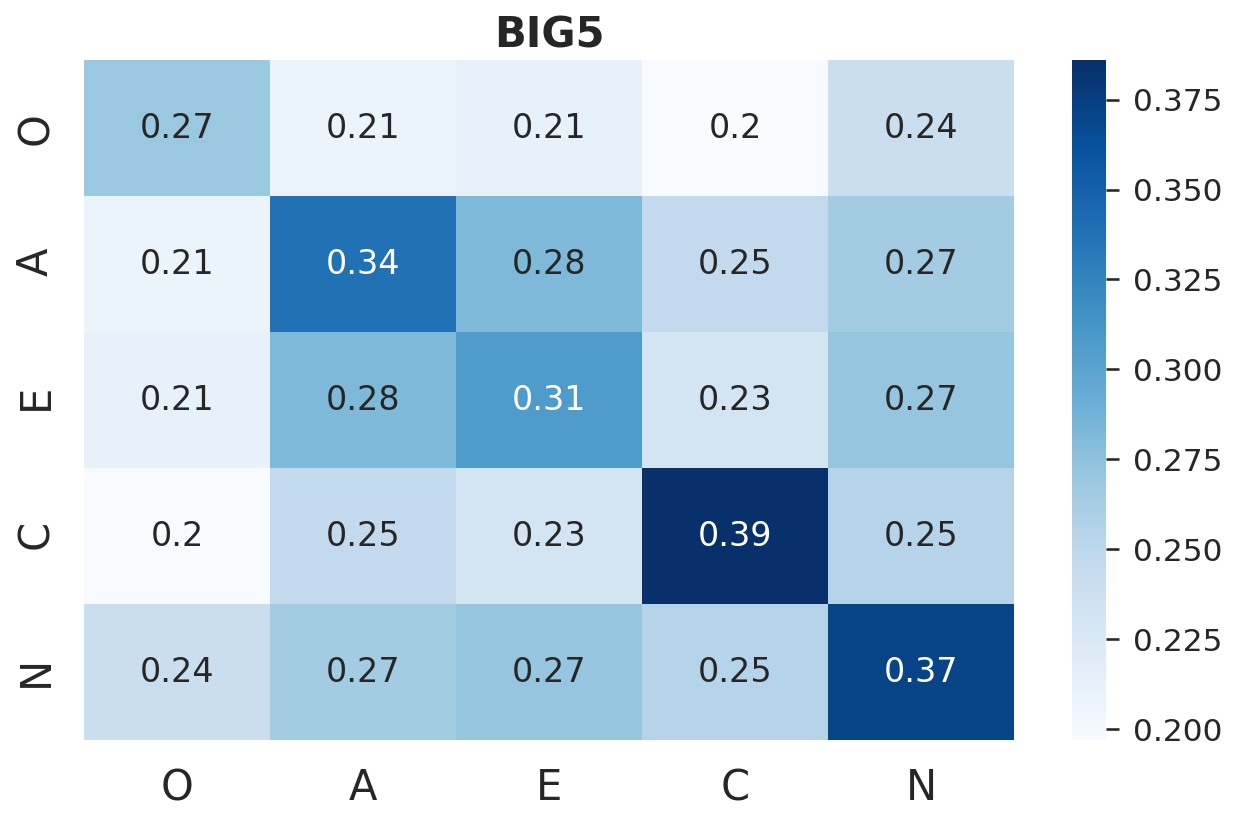

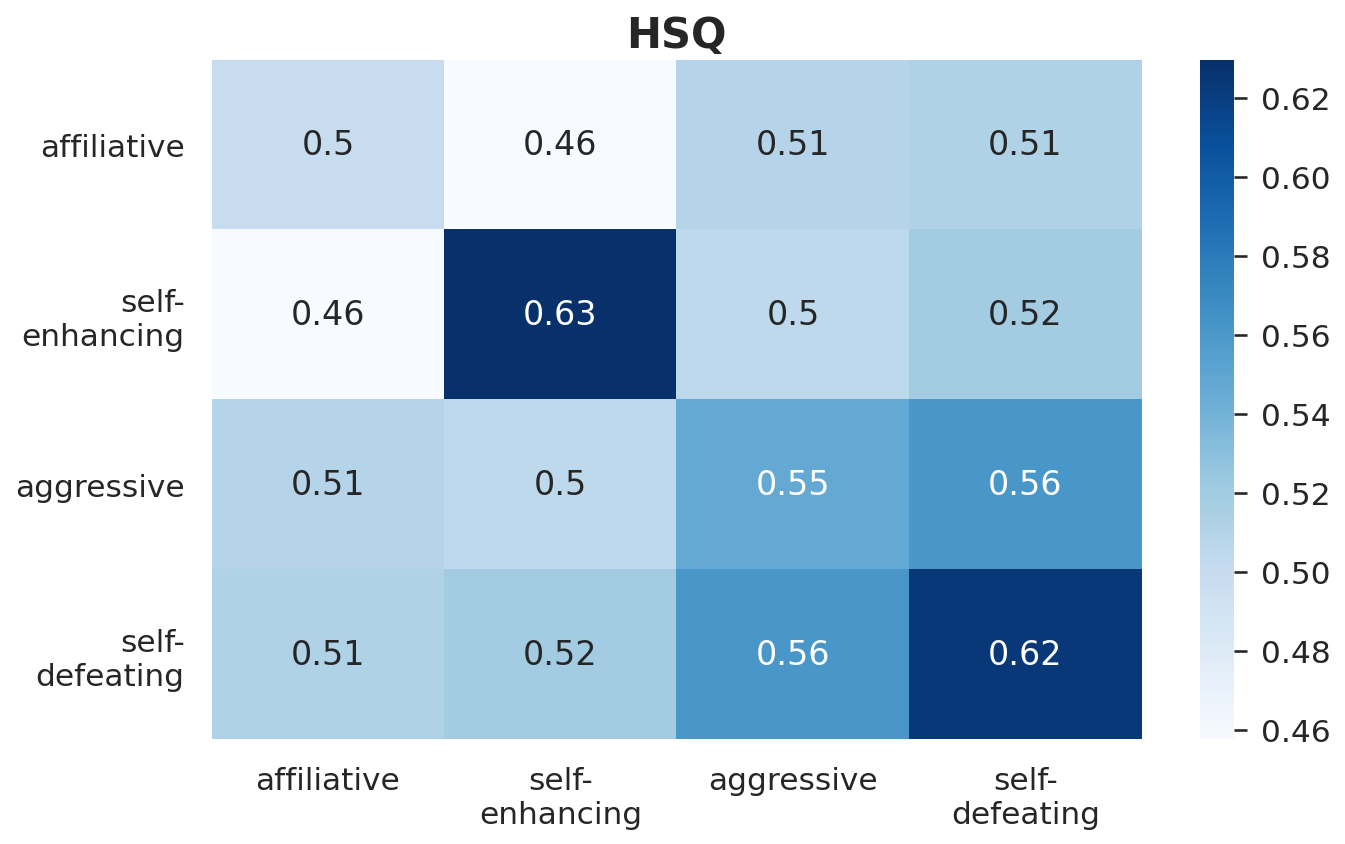

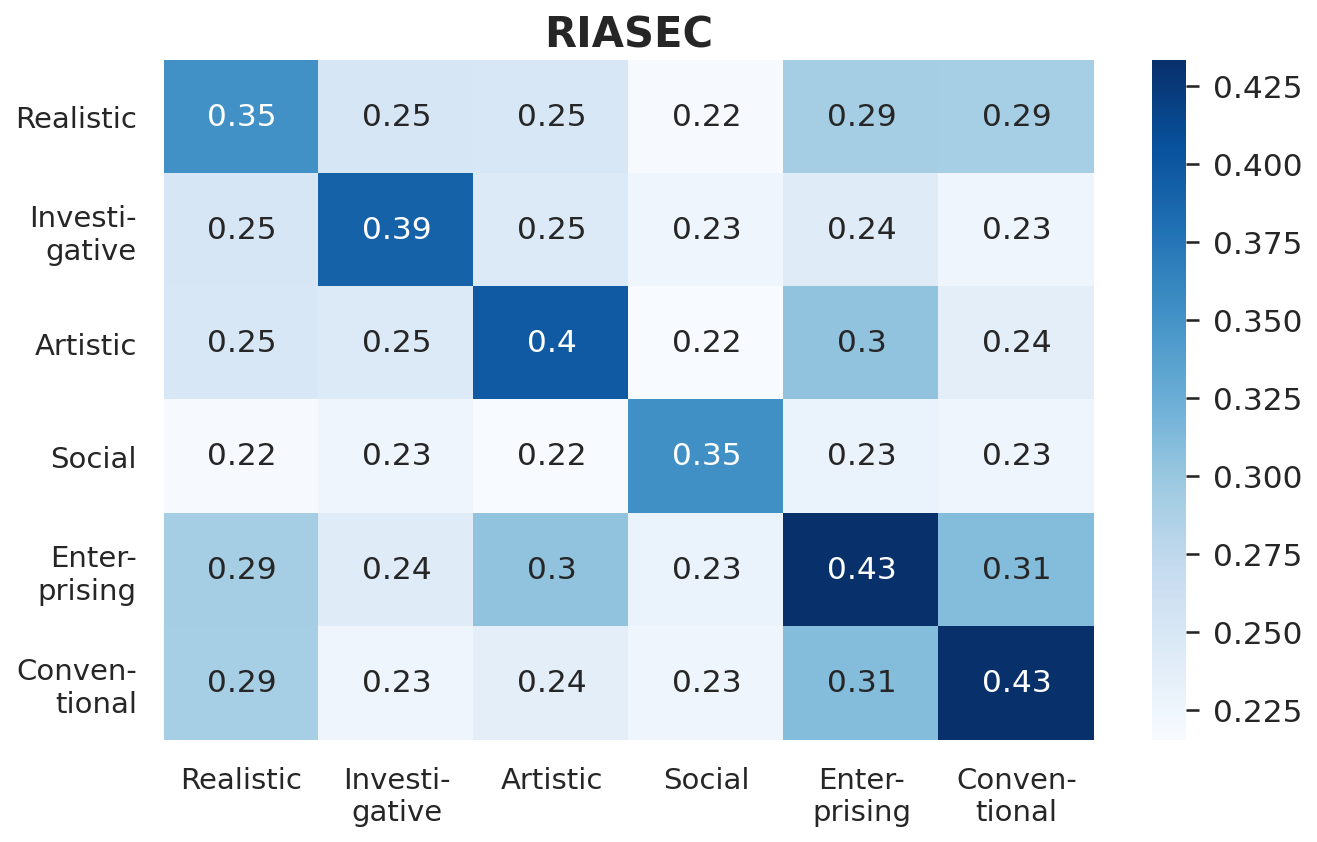

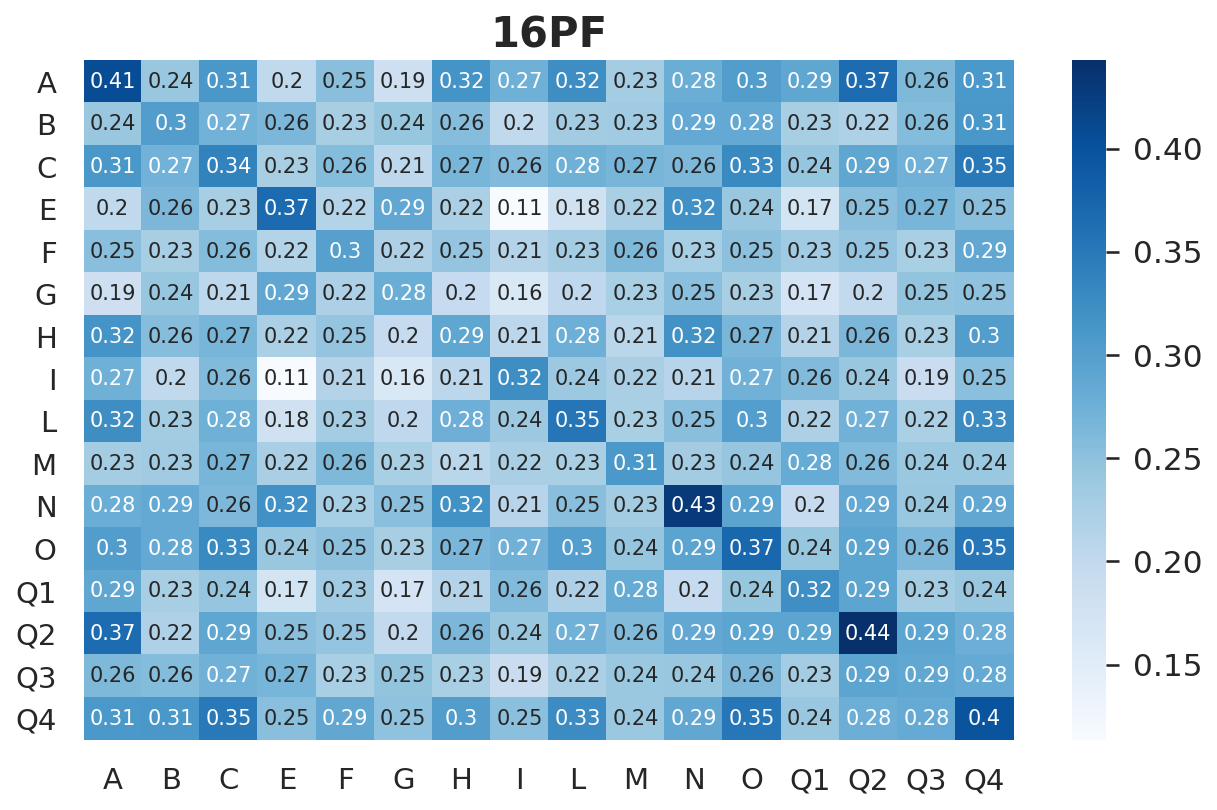

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.formula.api as sm
import itertools

# BIG5

#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
datasets = ["BIG5", 'HSQ', 'RIASEC', "16PF"]
# d = "BIG5"      #BIG5, 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 


#load path and necessary variables:
for d in datasets:
  folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
  embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
  responses, savePath, items = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
  responses = responses.astype(float) #get observed responses as floats
  X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

  # import required data and labels:
  data_q, constructs_list, list_par, constrAssigned = getData(1)

  #calculate construct similarities
  item_values = pd.DataFrame(columns=constructs_list, index=constructs_list)
  item_groups = pd.DataFrame(columns=constructs_list, index=constructs_list)
  sim_df = pd.DataFrame(columns=constructs_list, index=constructs_list)
  for constr_A in constructs_list:
    idx_A = np.where(constrAssigned.construct == constr_A)[0]
    for constr_B in constructs_list:
      idx_B = np.where(constrAssigned.construct == constr_B)[0]
      if constr_B == constr_A:
        sim = cosine_similarity(X.iloc[idx_A], X.iloc[idx_B])
        similarity_cleaned = []
        for i in range(sim.shape[0]):
          temp = sim[i][i+1:]
          similarity_cleaned.extend(temp)
        sim = similarity_cleaned
        similarity = np.array(sim).mean()
        item_values.loc[constr_A, constr_B] = sim        #save item level similarity over the whole constructs
        item_groups.loc[constr_A, constr_B] = [constr_A + "-" + constr_B]*len(sim)
      else:
        sim = cosine_similarity(X.iloc[idx_A], X.iloc[idx_B])
        similarity = sim.mean()
        item_values.loc[constr_A, constr_B] = sim.flatten().tolist()        #save item level similarity over the whole constructs
        item_groups.loc[constr_A, constr_B] = [constr_A + "-" + constr_B]*len(sim.flatten().tolist())
      sim_df.loc[constr_A, constr_B] = similarity      #save average similarity
  sim_df = sim_df.astype(float)

  # change construct name to make it shorter to fit into figure
  if d=="BIG5":
    construct_list = sim_df.columns
  elif d=="HSQ":
    construct_list = sim_df.columns
    construct_list = ["self-\nenhancing" if item=="selfenhancing" else item for item in construct_list]
    construct_list = ["self-\ndefeating" if item=="selfdefeating" else item for item in construct_list]
    sim_df.columns = construct_list
    sim_df.index = construct_list
  elif d=="RIASEC":
    construct_list = sim_df.columns
    print(construct_list)
    construct_list = ["Investi-\ngative" if item=="Investigative" else item for item in construct_list]
    construct_list = ["Enter-\nprising" if item=="Enterprising" else item for item in construct_list]
    construct_list = ["Conven-\ntional" if item=="Conventional" else item for item in construct_list]
    sim_df.columns = construct_list
    sim_df.index = construct_list
  if d=="16PF":  
    construct_list = sim_df.columns 


  #show plots
  fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
  if d=="BIG5":
    # sns.set(font_scale=1.5)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":16})
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="HSQ":
    # sns.set(font_scale=1.5)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":16})
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="RIASEC":
    # sns.set(font_scale=1.3)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":15})
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="16PF":
    # sns.set(font_scale=0.7)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":10})
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)

  ########################### test for significance:

  print("\n\n\n")
  print(d)

  outclass_values = []
  outclass_groups = []
  inclass_values = []
  inclass_groups = []

  for n in range(len(constructs_list)):
    
    # inclass_df = pd.DataFrame(columns=["in_class", "similarity"])
    # inclass_df.similarity = item_values.iloc[n,n]
    # inclass_df.in_class = [1]*len(item_values.iloc[n,n])


    # for i in range(item_values.shape[0]):
    #   if i!=n:
    #     outclass_list.extend(item_values.iloc[i,n])
    #   else:
    #     inclass_list.extend(item_values.iloc[i,n])
    # len(outclass_values)
    if n!= len(constructs_list)-1:
      outclass_values.extend(list(itertools.chain.from_iterable(item_values.iloc[n+1:,n]))) #items below diagonal are between constructs (matrix is symmetric so only take values below diagonal)
      outclass_groups.extend(list(itertools.chain.from_iterable(item_groups.iloc[n+1:,n]))) #get the names of the item pairs' constructs
    inclass_values.extend(item_values.iloc[n,n]) #values on the diagonal are within construct
    inclass_groups.extend(item_groups.iloc[n,n]) 

  outclass_df = pd.DataFrame(columns=["in_class", "similarity", "construct_1", "construct_2"])
  outclass_df.similarity = outclass_values
  outclass_df.construct_1 = [x.split("-")[0] for x in outclass_groups]
  outclass_df.construct_2 = [x.split("-")[1] for x in outclass_groups]
  outclass_df.in_class = [0]*len(outclass_values)
  
  inclass_df = pd.DataFrame(columns=["in_class", "similarity", "construct_1", "construct_2"])
  inclass_df.similarity = inclass_values
  inclass_df.construct_1 = [x.split("-")[0] for x in inclass_groups]
  inclass_df.construct_2 = [x.split("-")[1] for x in inclass_groups]
  inclass_df.in_class = [1]*len(inclass_values)
  merged_df = pd.concat([inclass_df,outclass_df])
  
  c1 = pd.get_dummies(merged_df["construct_1"])
  c2 = pd.get_dummies(merged_df["construct_2"])
  combined = c1 | c2

  final_df = pd.concat([merged_df.iloc[:,:-2], combined], axis=1)

  model = sm.ols(formula = "similarity ~ in_class + " + "+".join(constructs_list[:-1]), data=final_df)
  res = model.fit()
  # print(constructs_list[n])
  print(res.summary())
  # break

  from google.colab import files
  fig_name = "similarities_" + d + ".pdf"
  plt.title(d, fontsize=20, fontweight="bold")
  plt.savefig(fig_name, bbox_inches='tight')
  files.download(fig_name)

  # plt.show()

Plot regression summary over one data set

In [ ]:
models = []

for n in range(len(constructs_list)):
  
  outclass_list = []
  
  inclass_df = pd.DataFrame(columns=["in_class", "similarity"])
  inclass_df.similarity = item_values.iloc[n,n]
  inclass_df.in_class = [1]*len(item_values.iloc[n,n])

  for i in range(item_values.shape[0]):
    if i!=n:
      outclass_list.extend(item_values.iloc[i,n])
  # len(outclass_list)

  outclass_df = pd.DataFrame(columns=["in_class", "similarity"])
  outclass_df.similarity = outclass_list
  outclass_df.in_class = [0]*len(outclass_list)
  merged_df = pd.concat([inclass_df,outclass_df])

  model = sm.ols(formula = "similarity ~ in_class", data=merged_df)
  res = model.fit()
  models.append(res)

NameError: ignored

In [ ]:
for c, i in zip(constructs_list, range(len(models))):
  print(c + ": \n")
  print(models[i].summary())

# Reverse-coding responses (auxiliary code)

Import responses

In [ ]:
#data:
d = "hsq"         # BIG5, IPIP2, RIASEC, HSQ,

#choose data set, embeddings, encoding
folder, data = chooseData(d) 
embeddings, save = chooseEmb('use') 
responses, _, _ = getResponses(path1, folder, data, 1)
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)
_, _, _, constrAssigned = getData(1)

#rename:
responses_df = responses
questions_df = constrAssigned

Check min/max values, removing non-defined values (out of scale)

In [ ]:
# # check max values
print(responses_df.max().max())
print(responses_df.min().min())

# remove all rows with 0
#responses_df = responses_df.iloc[:,:-2]
responses_df = responses_df[(responses_df != 0).all(1)]
responses_df = responses_df[(responses_df != -1).all(1)]

responses_df.shape #check dataframe dimensions

Reversing responses

In [ ]:
# Changing from reverse-coded to non-reverse-coded and vice versa

max_response_value = responses_df.values.max() #find max value

#find questions that have to be reversed coded
question_key = questions_df.encoding == -1           

#flip responses
responses_df.loc[:,question_key] = max_response_value - responses_df.loc[:,question_key] + 1

Save reversed responses

In [ ]:
#responses_df.to_csv(dataset_path+folder+data+"responses.csv", header=True)

# Human rater evaluation

Load best model

In [ ]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "big5"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items = getResponses(path1, folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

#get performance:
corr, means = corrUserBased(total_preds, responses)

running KnnReg: 


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Find Target Participant

In [ ]:
S = corr.Correlation.sort_values()
for q in [0.25, 0.5, 0.75]:
  percentage_rank = S.rank(method="max", pct=True)
  idx = S.index[percentage_rank >= q]
  print('ID: ' + idx[0])
  print("Correlation: " + str(S[idx[0]]))

ID: 9be501c46d5f0c57bd272d182e4f5549
Correlation: 0.359
ID: b4b898afa6447bc978203884c4d23e92
Correlation: 0.463
ID: aa145b4e23e08e4f7340e1fa57f41332
Correlation: 0.56
